In [1]:
import pickle
import pandas as pd
import numpy as np
import torch
import transformers
import bitsandbytes as bnb
import networkx as nx
import random

random_state = 1

random.seed(random_state)

In [2]:
def euclid(list1, list2):
    return sum((p-q)**2 for p, q in zip(list1, list2)) ** .5

In [3]:
with open('df_policies_embeddings.pkl', 'rb') as f:
    df = pickle.load(f)
df

name                                               text Level  \
0        Category                                ACCOUNT INFORMATION  None   
1     SubCategory                                          your name  None   
2     SubCategory                                      email address  None   
3     SubCategory                                           password  None   
4     SubCategory                                      date of birth  None   
...           ...                                                ...   ...   
4113     Category                           your contact information  None   
4114  SubCategory                     information from third parties  None   
4115          cat  Or, if you provide us with your contact inform...     2   
4116          cat            Other Information, With Your Permission     2   
4117          cat  Additionally, there may be instances when you ...     2   

     document_name    Type                                         embeddings  
0       Fitbit.txt  Closed  [1.376953125, -1.1220703125, 1.982421875, 1.12...  
1       Fitbit.txt  Closed  [0.276123046875, 0.7734375, 0.53076171875, 1.2...  
2       Fitbit.txt  Closed  [1.5146484375, -0.07098388671875, 0.3347167968...  
3       Fitbit.txt  Closed  [0.436279296875, -0.021484375, 0.6201171875, -...  
4       Fitbit.txt  Closed  [0.5732421875, -1.681640625, -0.114990234375, ...  
...            ...     ...                                                ...  
4113  Snapchat.txt  Closed  [1.708984375, -0.94384765625, 0.984375, 0.6762...  
4114  Snapchat.txt    Open  [0.6962890625, -1.0859375, 0.611328125, 0.6069...  
4115  Snapchat.txt    None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt    None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt    None  [0.82421875, -0.7568359375, -0.057342529296875...  

[4118 rows x 6 columns]

In [4]:
validation_set = ['X_Twitter.txt', 'LinkedIn.txt', 'Zoom.txt', 'Fitbit.txt', 'Western Union.txt', 'Ubisoft.txt']
test_set =  ['Yahoo.txt', 'TikTok.txt', 'MySugr.txt', 'Deliveroo.txt', 'Paypal.txt', 'AdobePhotoshop.txt']
nontrain_set = validation_set + test_set
nontrain_set

['X_Twitter.txt',
 'LinkedIn.txt',
 'Zoom.txt',
 'Fitbit.txt',
 'Western Union.txt',
 'Ubisoft.txt',
 'Yahoo.txt',
 'TikTok.txt',
 'MySugr.txt',
 'Deliveroo.txt',
 'Paypal.txt',
 'AdobePhotoshop.txt']

In [5]:
df_train = df[~df.document_name.isin(nontrain_set)]
df_train = df_train.dropna(subset = ['Level'])
df_train

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[419 rows x 6 columns]

In [6]:
df_train_lv1 = df_train[df_train['Level'] == '1']
df_train_lv1

name                                               text Level  \
170   cat  Personal Identifiers\ta real name, birth date,...     1   
200   cat  Geolocation data\tPhysical location or movemen...     1   
222   cat  When you contact AliveCor directly, such as wh...     1   
223   cat                               When You Contact Us.     1   
241   cat  If you choose to buy a Product on our Site, we...     1   
...   ...                                                ...   ...   
3713  cat  For example, we create a permanent URL to your...     1   
3996  cat  We may use your information, including your fu...     1   
4086  cat  To do this, we ask you to provide us with acco...     1   
4088  cat  If you use our commerce products to buy someth...     1   
4094  cat  Lastly, when you contact Support (content and ...     1   

     document_name  Type                                         embeddings  
170     Kardia.txt  None  [-0.73779296875, -0.94873046875, 2.50390625, 0...  
200     Kardia.txt  None  [-0.74658203125, -0.58056640625, 1.771484375, ...  
222     Kardia.txt  None  [1.3701171875, -0.783203125, 0.92431640625, -0...  
223     Kardia.txt  None  [0.00887298583984375, -0.51806640625, 0.136352...  
241        Ava.txt  None  [1.1845703125, -1.4677734375, 2.27734375, 0.14...  
...            ...   ...                                                ...  
3713   Groupon.txt  None  [0.69921875, -1.24609375, 0.68017578125, 1.434...  
3996    Airbnb.txt  None  [0.94873046875, -1.134765625, 0.73291015625, -...  
4086  Snapchat.txt  None  [0.5029296875, -1.318359375, 1.25390625, -0.39...  
4088  Snapchat.txt  None  [0.88720703125, -1.203125, 1.712890625, 0.3522...  
4094  Snapchat.txt  None  [1.0888671875, -0.52783203125, 0.7236328125, -...  

[102 rows x 6 columns]

In [7]:
df_train_lv2 = df_train[df_train['Level'] == '2']
df_train_lv2

name                                               text Level  \
177   cat   Race, Color, Age, National origin, or Disability     2   
178   cat  Characteristics of protected classifications u...     2   
183   cat    Biometric information\tPhotos, video, and voice     2   
195   cat  Internet or other electronic network activity ...     2   
205   cat  User Generated Content\tYou may use your mobil...     2   
...   ...                                                ...   ...   
4110  cat  The last category of data we collect is inform...     2   
4112  cat  This includes linked third-party service data ...     2   
4115  cat  Or, if you provide us with your contact inform...     2   
4116  cat            Other Information, With Your Permission     2   
4117  cat  Additionally, there may be instances when you ...     2   

     document_name  Type                                         embeddings  
177     Kardia.txt  None  [-0.06195068359375, -0.273681640625, -0.146484...  
178     Kardia.txt  None  [0.59326171875, -0.6298828125, -0.58984375, 1....  
183     Kardia.txt  None  [-0.38134765625, -1.7529296875, 1.4677734375, ...  
195     Kardia.txt  None  [-0.671875, -0.97802734375, 0.314208984375, 1....  
205     Kardia.txt  None  [-0.335693359375, -1.3212890625, 1.5400390625,...  
...            ...   ...                                                ...  
4110  Snapchat.txt  None  [0.80078125, -1.2626953125, 0.30419921875, 0.0...  
4112  Snapchat.txt  None  [-0.57177734375, -1.00390625, 0.8095703125, -0...  
4115  Snapchat.txt  None  [0.485107421875, -2.080078125, 0.92724609375, ...  
4116  Snapchat.txt  None  [0.6630859375, -1.1650390625, 0.44580078125, 1...  
4117  Snapchat.txt  None  [0.82421875, -0.7568359375, -0.057342529296875...  

[317 rows x 6 columns]

In [8]:
df_test = df[df.document_name.isin(test_set)]
df_test = df_test.dropna(subset = ['Level'])
df_test

name                                               text Level  \
492   cat  We collect information that you provide when y...     1   
496   cat                                      User Content.     2   
498   cat  We collect the content you create or publish t...     2   
508   cat  We also collect content (such as text, images,...     2   
509   cat  In addition, we collect location information (...     1   
...   ...                                                ...   ...   
3564  cat          Information about your imported contacts.     2   
3575  cat  Information you disclose when you respond to s...     1   
3577  cat  This may include information about others if y...     1   
3586  cat  For example, if you choose to participate in O...     2   
3595  cat  This optional data is collected and processed ...     2   

     document_name  Type                                         embeddings  
492     TikTok.txt  None  [1.44921875, -0.89892578125, 1.8203125, 0.1143...  
496     TikTok.txt  None  [0.123291015625, -1.8173828125, 1.369140625, 1...  
498     TikTok.txt  None  [-0.5400390625, -1.1865234375, 2.10546875, 0.4...  
508     TikTok.txt  None  [-0.35302734375, -1.4091796875, 1.4365234375, ...  
509     TikTok.txt  None  [0.58251953125, -0.2344970703125, 2.423828125,...  
...            ...   ...                                                ...  
3564    Paypal.txt  None  [0.5029296875, -1.8271484375, 0.68701171875, 1...  
3575    Paypal.txt  None  [0.62158203125, -2.248046875, 1.111328125, 0.2...  
3577    Paypal.txt  None  [0.7802734375, -1.66796875, -0.4091796875, 0.7...  
3586    Paypal.txt  None  [1.154296875, -0.71728515625, -0.791015625, 0....  
3595    MySugr.txt  None  [1.1552734375, -1.6357421875, 1.333984375, -0....  

[160 rows x 6 columns]

In [9]:
device = torch.device('cuda')
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"

In [10]:
pipeline = transformers.pipeline(
    "text-generation",
    model=model_id,
    model_kwargs={"torch_dtype": torch.bfloat16,
                  "quantization_config": {"load_in_4bit": True}},
    device_map="cuda:0"
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Device set to use cuda:0


In [11]:
training_graph = pickle.load(open('all_lvl_graph_Level_.005.pickle', 'rb'))


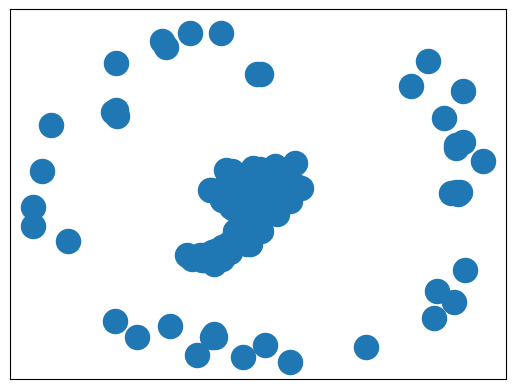

In [12]:
nx.draw_networkx(training_graph, with_labels = False)

In [13]:
def test(template, nexamples):

    count = 0
    lv1TP = 0
    lv1FN = 0
    lv1FP = 0
    lv2TP = 0
    lv2FN = 0
    lv2FP = 0

    for i in range(len(df_test)):

        subgraph_radius = 65.73/2              #SET MANUALLY, on the training set, on average these yield a subgraph of size (N*50)**0.5

        query = 'Text: '+ df_test.iloc[i]['text']+'\n'+'label = '

        test_graph = training_graph.copy()     

        for j in range(len(training_graph)):
            if euclid(df_train.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > subgraph_radius:
                test_graph.remove_node(j)


        while(len(test_graph)) < nexamples:     #If the subgraph doesn't have enough nodes, increment the radius
            subgraph_radius *= 1.1
            test_graph = training_graph.copy()
            for j in range(len(training_graph)):
                if euclid(df_train.iloc[j]['embeddings'], df_test.iloc[i]['embeddings']) > subgraph_radius:
                    test_graph.remove_node(j)
            #print(subgraph_radius)






        
        selected_nodes = []
        communities = nx.community.louvain_communities(test_graph, seed = random_state)
        sorted_communities = sorted(communities, key = lambda x: len(x), reverse = True)
        #print(sorted_communities)
        #print(len(sorted_communities))



        if len(sorted_communities) >= nexamples:    #If there are enough communities:
            for l in range(nexamples):
                subgraph = test_graph.subgraph(sorted_communities[l])
                selected_nodes.append(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True )[0][0])
                #print(sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True ))
        else:                                       #If there are less communities than nodes to choose:
            numberofelements = 2
            while len(selected_nodes) < nexamples:
                selected_nodes = []
                for element in sorted_communities:
                    subgraph = test_graph.subgraph(element)
                    selected_nodes += [foo[0] for foo in sorted(nx.pagerank(subgraph).items(), key=lambda kv: kv[1], reverse = True )][:numberofelements]
                    numberofelements += 1

        
        selected_nodes = selected_nodes[:nexamples]     #The final chosen demonstrations
        print('Selected Nodes:', selected_nodes)

        examples_text = []
        
        for el in list(range(nexamples)):
            if df_train.iloc[selected_nodes[el]]['Level'] == '1':
                examples_text.append('Text: '+ df_train.iloc[selected_nodes[el]]['text'] + '\n' + 'label = '+ 'sufficiently informative'+'\n\n')
            else:
                examples_text.append('Text: '+ df_train.iloc[selected_nodes[el]]['text'] + '\n' + 'label = '+ 'insufficiently informative'+'\n\n')

        random.shuffle(examples_text)

        examples_text = examples_text[:nexamples]

        text_examples = ''      #Building text examples

        for el in examples_text:
            text_examples += el
        
        print('query:\n'+ query,'\n')
        print('retrieved examples:\n\n'+ text_examples,'\n\n')

        messages = [{'role': 'system', 'content': template},{"role": "user", "content": text_examples},{"role": "user", "content": query}]

        outputs = pipeline(
            messages,
            max_new_tokens=10,
            do_sample = False
        )
        final_output = outputs[0]['generated_text'][-1]['content']
        print('LLM output:', final_output)
        if df_test.iloc[i]['Level'] == '1':
            gt = 'sufficiently informative'
        else:
            gt = 'insufficiently informative'
        print('ground truth:', gt)
        print(200*'-')

        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '2':
            lv2TP += 1
        if 'insufficiently' in final_output and df_test.iloc[i]['Level'] == '1':
            lv2FP += 1
        if 'insufficiently' not in final_output and df_test.iloc[i]['Level'] == '2':
            lv2FN += 1
        
        if  final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1TP += 1
        if final_output == 'sufficiently informative' and df_test.iloc[i]['Level'] == '2':
            lv1FP += 1
        if final_output != 'sufficiently informative' and df_test.iloc[i]['Level'] == '1':
            lv1FN += 1
        
    lv1PREC = lv1TP/(lv1TP+lv1FP)
    lv1REC = lv1TP/(lv1TP+lv1FN)
    lv2PREC = lv2TP/(lv2TP+lv2FP)
    lv2REC = lv2TP/(lv2TP+lv2FN)

    lv1F1 = 2/((1/lv1PREC)+(1/lv1REC))
    lv2F1 = 2/((1/lv2PREC)+(1/lv2REC))

    print('lv1 F1:', lv1F1)
    print('lv2 F1:', lv2F1)

    print('macro F1:', (lv1F1+lv2F1)/2 )
            


In [14]:
template = '''You will be given as input a sentence from a privacy policy that contains information about what data the service collects about the user. You have to classify the sentence into one of the following classes: "sufficiently informative" or "insufficiently informative".

In doing so, consider that GDPR, and the EDPB's Guidelines, contain a certain inherent tension, namely that between requiring that the information is provided in as easy a way to understand as possible (comprehensibility) and that it is concrete and definitely (comprehensiveness).
Sometimes, using open-ended qualifiers like “for example” or “such as” might actually facilitate understanding by the data subject, especially when terms not often used in the natural language (e.g. “device information” or “geolocation information”) are concerned. For this reason, we differentiate between:
*	Abstract terms (e.g. usage information) vs. concrete terms (e.g. geolocation information)
*	Open-ended qualifications (“for example”, “such as”, etc.) vs. closed-catalogues (“meaning”, “understood as” ).

A sentence containing an abstract term, UNLESS followed by a comprehensive enumeration, should be judged as "insufficiently informative".
A sentence containing a concrete term, even if followed by an open-ended qualifier, should be judged as "sufficiently informative".

Avoid explanations. Only reply with "insufficiently informative" or "sufficiently informative".

Here are some examples:'''

In [15]:
test(template, 5)

C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
C:\Users\alfio\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\generation\configuration_utils.py:633: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [42, 119, 185, 200, 273]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Account and Device Activation: When you activate your Device, you will be asked to download the App and create an account, where you enter information about yourself, such as username, password 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 167, 217, 171, 215]
query:
Text: User Content.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [408, 312, 73, 76, 390]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may provide a variety of information about yourself to us, such as your name, voice, or ima

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 195, 189, 312, 26]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition mode

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 390, 229, 166, 222]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including Wi-Fi credentials, if you choose

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 163, 370, 188, 191]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Device information.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 312, 68, 170, 268]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Usage Information: Using the ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 67, 195, 261, 304]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [8, 237, 417, 163, 188]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: When You Contact Us.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [107, 175, 352, 332, 189]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your account.
label = insufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party servi

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [261, 304, 66, 107, 175]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 217, 167, 215]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 57, 132, 185, 262]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our pay

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [207, 209, 304, 59, 38]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for any other reason regarding our Services.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [253, 389, 412, 8, 144]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 181, 36, 139, 304]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [138, 412, 237, 394, 144]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 242, 217, 237, 167]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 217, 176, 242, 237]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 105, 129, 229, 166]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 53, 320, 418, 261]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of using the Service.
label = sufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 268, 385, 36, 198]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [26, 33, 407, 260, 315]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: For research and development purposes, we may use datasets such as those that contain images, voices,
or other data that could be associated with an identifiable person.
label = insufficiently informative

Text: We collect content that you create using Meta VR Products, such as your avatar, a picture that you post or an object that you sculpt, and information about this content, such as the date and time that you created the content.
label = insufficiently informative

Text: Content information includes information based on the content of the image, video, or audio — so if you post a Spotlight o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 167, 417, 394, 103]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 345, 414, 235]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information ab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 80, 175, 185, 304]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: If you link, connect, or login 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [56, 189, 55, 401, 356]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: To add certain content, like pictures or videos, you may allow us to access your camera or photo album.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: When you set up your profile, you’ll also provide us with profile details (like yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 21, 136, 365, 351]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [96, 194, 112, 410, 227]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilitie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 281, 311, 345]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 170, 416, 261]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personaliz

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 100, 105, 127]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Device identifiers: In the course of using a mo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 80, 65, 386, 77]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 61, 97, 116, 181]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 146, 151, 155, 156]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data for marketing purposes:

Na

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 221, 189, 96, 91]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: This also includes vehicle or insurance information of drivers and delivery persons, emergency contact information, user settings, and evidence of health or fitness to provide services using Uber apps.
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your adv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 105, 127, 100]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 133, 416, 194, 170]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephone number, and email address).
label = sufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 84, 131, 365, 169]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 136, 365, 351]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 151, 365, 351, 136]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 136, 365, 351]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 146, 126, 128, 392]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [286, 158, 277, 157, 44]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Data processed for cookie purposes defer per purpose (functional, analytical or marketing) and depend on the preferences set by you.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: JET uses your personal data to be able to i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 54, 161, 304, 308]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect the information that you (and others) give

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 298, 240, 124, 150]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 217, 413, 237, 136]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 413, 300, 154]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 131, 23, 129, 285]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you vi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 103, 93, 186, 191]
query:
Text: Additional data
label =  

retrieved examples:

Text: Data from other sources.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: The data we collect
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 277, 416, 261, 189]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can comm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 271, 170, 70, 129]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 320, 96, 170, 268]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 217, 240, 370, 211]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 105, 127, 386, 36]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We will also automatically collect pe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 410, 333, 326]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: These identifiers include device and other identifiers, such as those from games and apps you use;
label = sufficiently informative

Text: Device data: We collect data about the devices used to access our services, including the hardware models, device IP address or other unique device identifiers, operating systems and versions, software, preferred languages, advertising identifiers, device motion data, and mobile network data.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 242, 217, 237, 167]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 237, 394, 164, 412]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [298, 379, 394, 237, 25]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 68, 70, 268]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Device identifiers: In the course of using a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 225, 235, 263]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access date

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 66, 256, 174, 335]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Apple may receive personal data about you from other individuals, from businesses or third parties 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 403, 317, 258, 248]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
-----

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 335, 418, 258, 195]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: We also receive information about you from third parties,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [183, 320, 336, 416, 418]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Gu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 249, 240, 391]
query:
Text: General Data
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 272, 304]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 54, 57, 185, 262]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: For example, if you make a reservation, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [110, 21, 394, 237, 138]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 139, 161, 195, 196]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
---------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 389, 82, 124, 366]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 78, 129, 392, 285]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail address; password;
the location of your device or computer;
content interaction information, such as content downloads, streams, and playback details including duration and number of simultaneous streams and downloads, and network details for streaming and download quality, including information a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [403, 84, 161, 418, 348]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [103, 379, 237, 417, 163]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 390, 200, 216]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 126, 252, 200]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing reservations, or as required by law
label = sufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, devic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 388, 237, 140]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [215, 217, 167, 171, 186]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 199, 115, 172, 373]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: The transaction related information 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 131, 349, 373, 384]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payme

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 217, 186, 167]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 200, 137, 214]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: Such as your first name, last name, phone number, postal address, email addre

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [19, 301, 63, 114, 289]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Information you provide to us directly
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 217, 240, 370, 211]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 138, 25, 298, 379]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [300, 298, 114, 379, 301]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 167, 217, 215, 186]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [288, 368, 304, 175, 131]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: This includes:

When you create an account, you p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [177, 181, 252, 341, 126]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 177, 341, 181]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [128, 241, 170, 390, 137]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [298, 379, 103, 300, 323]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [103, 379, 237, 417, 163]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [241, 285, 128, 392, 224]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [344, 343, 162, 205, 260]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: We create audiences based on parameters such as gender, age, and location (e.g. males aged 25-35 in your city), and if your personal data matches those audiences, you’ll be assigned to it. This is to help you receive relevant offers; and
Activity information.
label = insufficiently informative

Text: In some cases: age, gender, country of birth, nationality, country of residence, employment status, family status, interests and preferences.
label = insufficiently informative

Text: For research and development purposes, we may use datasets such as those that contain images, voices,
or other data that could be associated with an identifiable person.
label = insufficiently informative

Text: For example, if you pur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 166, 222, 229, 12]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have grant

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 105, 129, 131, 104]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 131, 340, 286, 208]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Personal data we collec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [174, 282, 126, 152, 131]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 59, 139, 272, 308]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 106, 383, 44, 158]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: We collect your personal information in order to provide and continually improve our products and services.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: JET uses your personal data to be able to improve our website and our range of products and Services and to be able meet our reporting obligations towards third parties which may also include advertisers.
label = insufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [144, 173, 399, 21, 110]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 57, 119, 131, 185]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 67, 139, 209, 308]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We collect personal information about you when you use the Ai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 341, 398, 304, 338]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 36, 37, 207, 47]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service provider Cognigy.AI.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [60, 97, 264, 361, 362]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may collect personal data under call recordings to provide customer support, including to investigate and address user concerns and to monitor and improve our customer support responses and processes.
label = insufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Any of our communications with you, including any 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [361, 262, 135, 143, 278]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: Personal correspondence, such as emails or letters, or third party correspondence about you may go into a file specific to you will only be stored for as long as it is necessary for the execution of the contractual relationship between you and us.
label = insufficiently informative

Text: For this purpose we may ask you to present a valid, government issued identification

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 129, 194, 70]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Device data: We collect data about the devices used to access our services, including the hardware models, device IP address or other unique device identifiers, operating systems and versions, software, preferred languages, advertising identifiers, device motion data, and mobile network data.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and ident

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 96, 15, 70, 393]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 149, 61, 133]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephone number, and email address).
label = sufficiently informative

Text: If you share with us information 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 413, 124, 412]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [66, 79, 80, 175, 304]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: When you access the Twitch S

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 282, 335, 337, 416]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 256, 282, 335, 414]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affili

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 304, 416, 418, 67]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: Members: Members may provide information 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 25, 298, 300]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [69, 95, 161, 418, 195]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 36, 185, 76, 368]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may provide a variety of information about yourself to us, such as your name, voice, or image (in any content you upload, stream, or participate in), Twitch username, email address, postal mailing address, telephone number, credit card number, and billing information.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information bas

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [126, 131, 416, 185, 277]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potentia

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 126, 214, 12, 78]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 176, 417, 394, 163]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 416, 387, 181]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: Information from other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 304, 308, 23]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or com

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 77, 105, 127, 197]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 400, 401, 137, 162]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture).
label = insufficiently informative

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: Such as gender, preferred language(s), city, and personal description.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: To do t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 70, 241, 285, 224]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 131, 20, 129, 72]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Photo Verification data: If you choose to participate in our Photo Verification feature, we collect your face geometry data, which may be considered biometric data in some jurisdictions, to verify that you’re the real you.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 268, 390, 207, 36]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 101, 224, 227, 333]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: Technical system information such as crash logs, which may contain your user ID, the device ID, the IP address, the local computer file path, the feature quality, the amount of time it takes to load a feature and whether you use a certain feature.
label = suffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 416, 271, 385, 77]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 385, 105, 268]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 119, 416, 47, 304]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid pla

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 268, 418, 189, 320]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 385, 36, 263, 105]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 385, 332, 123, 178]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Blizzard may also monitor your computer, console, or other device (including mobile device) for the signatures of unauthorized programs and communicate this information back to Blizzard about that unauthorized activity to prevent cheating and fraud, and to enforce our EULA.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 352, 398, 181, 54]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: User profil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 390, 36, 415, 185]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [116, 282, 352, 390, 66]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 356, 72, 33, 26]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Biometric Information: If you choose to use our Photo Tagger feature, it uses facial recognition technology, to create facial recognition models (i.e., biometric information) of you and your deceased relatives, in order to help you tag people in your photos quickly and easily.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: Pho

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 144, 287, 289, 399]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 242, 217, 215, 167]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [73, 76, 193, 312, 408]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing, editing, viewing, creating and moving files or folders, and sending and receiving electronic signature requests and other transactions).
label = insufficiently informative

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweeps

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [317, 320, 161, 195, 100]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 47, 60, 139, 272]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 377, 224, 170, 78]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: We may also collect non-p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 176, 394]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [57, 116, 282, 132, 181]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 47, 277, 304]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 224, 128, 129, 392]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Computer and connection information,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 242, 217, 237, 167]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 219, 338, 390, 380]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 309, 341, 254, 259]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: For example:

When you register to use Meta VR Products, we ask for information such as your name, email address and phone number.
label = insufficiently informative

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: If you don’t provide this, we may not be able to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 131, 308, 47, 104]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 139, 23, 104, 131]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 114, 298, 300, 237]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [104, 130, 131, 146, 349]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [248, 258, 56, 67, 85]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

 


LLM output: sufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 310, 400, 304, 380]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: If you choose to do so, we wil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 350, 261, 44, 304]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Other data that we are required or entitled by applicable law to collect and process and that we 

In [16]:
test(template, 10)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [42, 131, 185, 273, 352, 373, 9, 119, 137, 200]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: Account Information: When you create a Yelp account, we store and use the information you provide during that process, such as the first and last name you enter, email address, zip code, physical address, and any other information you may provide during the account creation process, such as a gender, phone number, or birth date.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Account and Device Activation: When you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 167, 192, 211, 217, 171, 215, 21, 237, 150]
query:
Text: User Content.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 73, 80, 76, 185, 66, 312, 189, 408, 235]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 195, 100, 304, 54, 189, 312, 26, 261, 193]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 390, 416, 262, 418, 189, 229, 166, 222, 71]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 186, 346, 215, 163, 237, 370, 211, 188, 191]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Device information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 312, 416, 37, 7, 68, 170, 268, 197, 410]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data that recognize user activity, such as if and how often a user has visited a website), web storage, unique advertising

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 67, 116, 262, 277, 363, 195, 261, 304, 406]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 217, 167, 242, 163, 213, 417, 191, 188]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [107, 175, 304, 49, 185, 352, 332, 189, 390, 51]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: Contacts: You can invite others to join or become your friend on Yelp by providing us with their contact information, or by allowing us to access contacts from your computer, mobile device, or third party sites to select which individuals you want to invite.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [261, 304, 401, 418, 189, 303, 66, 107, 175, 80]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: When you set up your profile, you’ll also provide us with profile details (like your Bitmoji and profile picture).
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Inst

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 417, 163, 394, 247, 242, 213, 176, 191, 217]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
---------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [265, 310, 57, 132, 374, 262, 352, 36, 363, 47]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment and fulfillment.
label = sufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 73, 67, 416, 185, 207, 36, 38, 139, 47]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Such as whe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [389, 144, 21, 396, 399, 237, 412, 138, 394, 8]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
----------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 181, 262, 277, 47, 390, 36, 139, 304, 272]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [389, 412, 144, 164, 413, 21, 394, 237, 417, 138]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 192, 215, 242, 163, 176, 213, 237, 417]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 217, 167, 171, 215, 192, 237, 163, 176, 242]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 105, 40, 70, 269, 410, 129, 229, 166, 71]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device identifier, advertising identifier, location (including geolocation, beacon based location, and GPS location), and requested and referring URLs and mobile applications.
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: We may also automatically collect i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 53, 129, 166, 196, 320, 418, 261, 170, 194]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 324, 197, 385, 100, 36, 302]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection techn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 26, 235, 281, 345, 408, 312, 315, 405, 260]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: On the other end of the spectrum, some of the information you send through or save within our Services may be public content that is accessible

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 300, 379, 103, 217, 167, 240, 192, 169]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 345, 414, 235, 189, 261, 418, 400, 344]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: For example, if you purchase products or services related to wellness and beauty, we may infer that you are interested in these types of products, or if you purchase Groupon Travels deals we may infer that you are a frequent traveler;
Audience information.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Serv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [175, 185, 235, 312, 415, 65, 416, 352, 304, 80]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 303, 137, 363, 85, 26, 189, 356, 6, 336]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: User Generated Content	You may use your mobile device to add notes, tags, or voice memos to EKG recording you make with our Devices.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 21, 110, 164, 389, 136, 365, 351, 169, 318]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [96, 194, 212, 333, 78, 224, 112, 410, 227, 326]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data that recognize user activity, such as if and how often a user has visited a website), web storage, unique advertising identifiers), and log information (such as details about how you’ve used our Services, access times, p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 170, 268, 302, 281, 311, 345, 415, 235]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 302, 36, 345, 170, 416, 261, 262, 189]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are publis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 100, 127, 161, 105, 393, 77, 129]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 80, 304, 336, 195, 65, 386, 77, 302, 281]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 61, 97, 116, 181, 282, 304, 345, 414, 416]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insuffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 146, 148, 151, 153, 155, 156, 160, 392, 349]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) (optional)

Campaign data (optional)

DeviceID

Cookie and Technology data
label = insufficiently informative

Text: We may process the following data relating to you:

        you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 390, 418, 61, 261, 84, 317, 248, 221, 212]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Details relating to your fitness and exercise informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 127, 161, 80, 386, 100, 194, 170, 129, 70]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: When you access the Twitch Services through social med

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 133, 302, 348, 44, 87, 416, 194, 170, 281]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to you.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 286, 84, 95, 221, 131, 360, 174, 54, 365]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 151, 153, 155, 156, 160, 373, 136, 365]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We may process following personal data for fraud prevention purposes:

Name

Order and transaction data

Payment data

Device information

IP address

Browser information
label = insufficiently informative

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 151, 153, 160, 148, 365, 351, 136, 307, 384]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [146, 148, 151, 153, 155, 156, 160, 136, 365, 351]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 146, 126, 128, 392, 136, 365, 351, 384, 395]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: Examples of information we receive from other

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 336, 418, 403, 304, 277, 61, 161, 416]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 308, 139, 54, 36, 47, 304, 390, 406, 414]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yel

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 244, 298, 300, 103, 240, 217, 211, 124, 413]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 103, 217, 240, 171, 413, 255, 366, 412, 237]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 413, 300, 154, 159, 188, 239, 251, 391]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Analytics
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Customer research
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 131, 373, 152, 104, 100, 36, 105, 268, 77]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 74, 103, 92, 230, 93, 186, 191, 370, 391]
query:
Text: Additional data
label =  

retrieved examples:

Text: Contacts.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 277, 312, 50, 51, 263, 416, 261, 189, 194]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: If you send or receive messages through the Service via SMS, we may log phone numbers, phone carriers, and the date and time that any messages were processed.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 271, 281, 358, 386, 65, 170, 70, 129, 415]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 320, 336, 261, 406, 84, 96, 170, 268, 168]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: If you allow us to access your contact

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 217, 215, 186, 211, 167, 240, 192, 413]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 281, 80, 65, 414, 36, 15, 271, 129, 70]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our service

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 112, 212, 227, 269, 70, 224, 410, 333]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device iden

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 192, 215, 242, 163, 176, 213, 237, 417]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 389, 412, 164, 21, 298, 379, 394, 237, 25]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 92, 103, 237, 394, 163, 417, 176]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
-----------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 105, 385, 386, 127, 68, 70, 268, 415]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), contact info from other Snapchatters or third parties (if another Snapchatter uploads their contact list which includes your information, we may combine that with other information we have about you to better understand who you may want to communicate with.
label = insufficiently informative

Text: Device identifiers

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 194, 224, 80, 312, 281, 65]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 66, 175, 304, 80, 256, 174, 335, 181, 282]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: Apple may receive personal data about you from other individuals, from businesses or third parties acting
at your direction, from our partners who work with us to p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 403, 84, 284, 381, 62, 317, 258, 248, 364]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [282, 335, 387, 414, 109, 174, 418, 258, 195, 403]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: You may direct other individuals or third parti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 320, 262, 336, 67, 411, 36, 386, 80, 311]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 217, 167, 211, 413, 21, 287, 124, 92]
query:
Text: General Data
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: sufficiently informative
------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 352, 304, 262, 416, 181, 282, 345, 47]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 54, 57, 185, 262, 304, 165, 265, 272, 310]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, address, email, and payment information, as well as any other information you provide relat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 217, 171, 240, 237, 394, 417, 138, 21]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [195, 100, 166, 129, 12, 127, 385, 77, 47, 243]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Precise location only to support services such as Find My or where you agree for
region-specific services, and coarse location
label = sufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your int

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 389, 412, 144, 253, 382, 82, 124, 366, 255]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Personal Data We Collect
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 269, 410, 101, 40, 128, 129, 285, 392]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 304, 84, 336, 403, 61, 181, 67, 387, 380]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Polic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [103, 379, 92, 300, 95, 237, 417, 163, 388, 192]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 152, 126, 341, 390, 200, 216, 199, 9]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 9, 354, 119, 185, 384, 131, 104, 373, 349]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 171, 215, 237, 394, 298, 300, 25]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 171, 215, 186, 346, 237, 163, 242, 21, 249]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
-----------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 199, 132, 219, 354, 203, 115, 172, 373, 126]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 390, 175, 185, 104, 368, 259, 256, 128]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 298, 300, 138, 217, 186, 167, 114, 21]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 104, 373, 384, 126, 390, 200, 400, 137, 273]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone n

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 139, 318, 340, 69, 289, 301, 114, 19, 63]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 217, 215, 186, 211, 167, 240, 192, 413]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Account information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 412, 144, 413, 237, 217, 171, 417, 239]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [300, 298, 237, 25, 323, 114, 379, 301, 63, 103]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 167, 192, 211, 217, 215, 186, 171, 237, 249]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [288, 368, 104, 309, 373, 304, 175, 131, 261, 341]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherwise interact with Apple, we may collect
a variety of information, including:
• Account Information.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 152, 64, 177, 416, 368, 256, 259, 252, 216]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstances, including when setting up a wireless account and activating your device, for the purpose
of extending commercial credit, managing reservations, or as required by law
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 126, 64, 416, 181, 199, 141, 200, 216, 341]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Such as images of your government-issued ID 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [128, 241, 129, 285, 170, 390, 137, 175, 212, 12]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [95, 379, 301, 103, 114, 92, 394, 298, 237, 300]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [103, 379, 92, 300, 95, 237, 417, 163, 388, 192]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
----------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 78, 170, 194, 224, 35, 128, 129, 392, 241]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 317, 85, 418, 235, 281, 133, 345, 137]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [71, 166, 222, 229, 99, 328, 129, 212, 12, 332]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Location-related information, which can be derived from information such as your device's IP address.
label = sufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: Location data, including your general location data (e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 105, 77, 302, 386, 129, 131, 104, 285, 127]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 131, 152, 360, 384, 104, 340, 286, 208, 54]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [174, 282, 335, 414, 181, 256, 126, 152, 131, 353]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We will collect the following personal data when you interact wi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 139, 161, 272, 304, 352, 67, 195, 36]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: If you contact our customer care t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 100, 161, 195, 418, 189, 403, 62, 341]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficient

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 399, 110, 396, 124, 144, 173, 389, 412]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
-----

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [9, 57, 132, 262, 265, 310, 119, 131, 185, 200]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: When you subscribe to a paid service or make a purchase directly from us (rather than through a platform such as iOS or Android), you provide us with information related to the purchases you make and our payment processors with information such as your debit or credit card number or other financial information.
label = sufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information inclu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 67, 195, 262, 304, 406, 139, 209, 308, 60]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: We collect personal i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 341, 374, 120, 9, 132, 398, 304, 338, 59]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to ena

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 36, 127, 183, 139, 308, 37, 207, 47, 369]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [60, 97, 361, 130, 362, 7, 416, 264, 278, 313]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: Personal correspondence, such as emails or letters, or third party correspondence about you may go into a file specific to you will only be stored for as long as it is necessary for the execution of the contractual relationship between you and us.
label = insufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Any of our communications with you, including any phone calls, may be monitored and recorded for quality purposes.
label = sufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [361, 262, 338, 341, 60, 130, 135, 143, 278, 120]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 112, 212, 269, 410, 129, 194, 70, 40]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 96, 170, 224, 268, 410, 15, 70, 393, 101]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 313, 347, 361, 149, 61, 133, 350, 184]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: We may receive health information, including but not limited to, health information related to contagious diseases.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: As part of our Services we may sell products that may reveal sensitive personal data, such as health-related information (allergies or dietary requirements), information about your religion (such as if you only eat halal food), information about your medical condition (e.g. drugs, medicines, medical devices, medica

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [389, 412, 396, 399, 144, 124, 413, 366, 173, 113]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: What personal information is collected?
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 183, 127, 385, 386, 304, 80, 416, 363, 352]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 266, 282, 335, 337, 348, 416, 64, 387, 181]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: Information from other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 335, 414, 174, 256, 337, 345, 282, 133, 398]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 304, 338, 383, 272, 313, 416, 418, 67, 36]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 176, 242, 417, 412, 21, 413, 287, 399]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [69, 95, 161, 418, 195, 139, 340, 308, 286, 113]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: We also collect information from and about the devices you use 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [23, 36, 47, 54, 80, 165, 185, 76, 368, 209]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may provide a variety of information about yourself to us, such as your name, voice, or image (in any content you upload, stream, o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 131, 373, 152, 170, 68, 268, 285, 216]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, action

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 78, 129, 224, 131, 54, 377, 181, 360]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: We may also collect non-personal information such as demographic data, for example your geographic ar

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [300, 379, 167, 217, 240, 237, 388, 8, 247, 417]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 56, 189, 317, 416, 387, 181, 64, 18]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: From time to time, de-identifie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 73, 80, 304, 66, 131, 104, 139, 272]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [105, 127, 195, 302, 386, 15, 193, 385, 36, 268]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 137, 390, 354, 363, 189, 67, 304, 235]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including Wi-Fi credentials, if you choose to automat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [40, 70, 78, 393, 410, 35, 241, 285, 224, 392]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 131, 390, 185, 354, 129, 15, 70, 170, 80]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 268, 193, 197, 312, 385, 390, 207, 36, 277]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 101, 70, 269, 15, 224, 227, 333, 78, 112]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 416, 36, 312, 304, 262, 271, 385, 77, 105]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 271, 12, 35, 78, 385, 105, 268, 77]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: This may include web log information, “clickstream” data (for example, the type of computer and browser you use, the address of the website from which you linked to the Website), page views and IP addresses.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 119, 416, 47, 304, 268, 15, 385, 77, 377]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: For some activities, we may as

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 268, 418, 189, 320, 311, 312, 316, 161, 96]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: We also collect content and information that other people provide when they use Meta VR Products.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: This related information includes your profile information that makes 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 385, 100, 235, 312, 348, 36, 263, 105, 268]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 410, 385, 302, 100, 332, 129, 196, 70, 123]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertis

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 352, 390, 185, 363, 261, 398, 181, 54, 282]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitiv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 390, 47, 181, 406, 36, 415, 185, 416, 66]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or ot

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [116, 282, 304, 36, 345, 352, 390, 66, 107, 43]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 26, 312, 281, 345, 418, 416, 363, 85, 408]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric information).
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your expe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 389, 144, 412, 289, 19, 399, 63, 237]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 213, 176, 417, 217, 167, 240, 186]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 67, 312, 235, 408, 36, 390, 363, 76, 37]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may provide a variety of information ab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [317, 320, 418, 336, 67, 161, 195, 100, 316, 311]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: We also collect content and information that other people provide when they use Meta VR Products.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 352, 36, 47, 185, 161, 139, 308, 301, 23]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 377, 266, 348, 385, 224, 170, 78, 96, 268]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = insufficiently informative

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: We may also use aggregated or anonymized  information regarding those transactions for analytics purposes and to improve Yelp’s services.
label = sufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 192, 211, 237, 176, 394, 388, 169]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

 


LLM output: insufficiently informative
ground truth: insufficiently informative
------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 265, 132, 293, 57, 416, 387, 181, 183, 282]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We do not collect or store financial account information, though we may receive transaction identifiers and summary information that does not include credit car

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 37, 47, 277, 304, 406, 416, 67, 97, 207]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for any other reason regarding our Services.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 224, 227, 410, 112, 212, 128, 129, 392, 241]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance and
other diagnostic data; and other usage data
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 192, 215, 242, 163, 176, 213, 237, 417]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: sufficiently informative
--------------------------------------------------------------------------------------------------------------------------------------------

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 219, 204, 172, 355, 338, 390, 380, 310, 152]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: Delivery, billing, and other information you provide, as well as information required for customs clearance (such as tax identification numbers or other identification numbers) and relevant delivery information (such as shipment numbers and tracking information) if sent through one of our programmes.
label = sufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [368, 341, 384, 373, 152, 128, 129, 131, 104, 216]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 100, 36, 312, 308, 77, 131, 23, 54, 104]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information abou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 139, 272, 304, 308, 23, 104, 131, 373, 384]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We collect the infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 92, 103, 300, 417, 163, 74, 237, 95]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

 


LLM output: sufficiently informative
ground truth: insufficiently informative
---

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [130, 131, 146, 152, 373, 384, 128, 392, 285, 349]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you take as part of your use of our Services and in advertising and email content.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [248, 258, 364, 418, 84, 403, 56, 67, 85, 317]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: You can also share additiona

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 310, 293, 57, 219, 400, 304, 380, 261, 390]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: To do this, we ask you to provide us with account details (information about you, like your name, username, email address, birthday, and phone number).
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from third party payment providers like PayPal).
label = sufficiently informative

Text: Data tha

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 350, 116, 158, 277, 143, 261, 44, 304, 338]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: If a copy of your ID is provid

In [17]:
test(template, 15)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [119, 273, 400, 200, 390, 9, 42, 137, 185, 60, 262, 304, 47, 352, 363]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including Wi-Fi c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 217, 240, 167, 237, 163, 394, 417, 136, 365, 351, 150, 239, 251]
query:
Text: User Content.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Custo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 73, 80, 76, 185, 66, 43, 363, 312, 189, 408, 235, 68, 268, 193]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing, editing, viewing, creating and moving files or folders, and sending and receiving electronic signature requests and other transactions).
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 195, 100, 304, 54, 189, 312, 26, 261, 193, 415, 76, 47, 66, 36]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 390, 416, 262, 418, 189, 44, 268, 229, 166, 222, 71, 12, 129, 99]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 240, 237, 412, 21, 163, 176, 242, 417, 92, 300, 103, 150, 188, 191]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 312, 416, 37, 7, 68, 170, 268, 197, 410, 408, 261, 107, 235, 185]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data that recognize user activity, such as if and how often a user has visited a website), web st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 67, 116, 262, 277, 363, 390, 36, 310, 195, 261, 304, 406, 312, 62]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 412, 298, 300, 8, 217, 167, 242, 215, 346, 163, 213, 417, 191]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 363, 262, 414, 312, 418, 15, 268, 127, 36, 70, 129, 170, 390, 107]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your account.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 304, 312, 66, 175, 261, 189, 418, 67, 336, 56, 185, 416, 390, 363]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage act

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 21, 298, 300, 253, 217, 167, 240, 186, 215, 192, 211, 163, 213]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [265, 310, 57, 132, 374, 262, 142, 402, 352, 36, 363, 47, 54, 312, 185]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 73, 67, 416, 185, 207, 406, 352, 36, 38, 139, 47, 304, 272, 308]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 255, 366, 164, 399, 21, 287, 396, 144, 110, 394, 237, 298]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbn

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 181, 262, 277, 47, 390, 406, 416, 36, 139, 304, 272, 308, 54, 23]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Your Use of the Service: While y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 300, 298, 25, 417, 389, 412, 144, 21, 253, 396, 399, 173, 366]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 186, 215, 237, 394, 298, 300, 417, 21, 213, 163, 242, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Contact Information.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [240, 217, 167, 171, 215, 192, 211, 169, 237, 163, 176, 242, 21, 247, 249]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Log Data and D

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 78, 269, 40, 71, 166, 129, 53, 222, 229, 127, 105, 385, 377]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: When you visit our Website, we may autom

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 166, 15, 212, 129, 332, 418, 261, 262, 304, 320, 336, 80, 324, 306]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Information we receive through device settings that you choose, such as your photos or audio content;
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Depending on which Meta VR Products you use, we must process different kinds of information from or about you.
label = insufficiently informative

Text: For example

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 324, 197, 408, 198, 385, 100, 36, 302, 47, 312, 127]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: This includes usage information (information about how you interact with our Services — for example, which Lenses you view and apply, Stories you watch, and how often you communicate with other Snapchatters) and content information (information about content you create or provide, your engagement with the camera and creative tools, your interactions with My AI, and metadata — for example, information about the content itself like the date and time it was posted and who viewed it).
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 26, 407, 33, 72, 85, 356, 223, 235, 281, 345, 225, 390, 311, 343]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: Content information includes information based on the content of the image, video, or audio — so if you post a Spotlight of a basketball game, we may use that information to show you more content on Spotlight about basketball.
label = insufficiently informative

Text: Data about your activities and interactions with our advertising partners including data about the advertisements you were shown, how often they were shown, when and where they were shown, and whether you took any action, such as clicking on an advertisement or making a purchase.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 163, 417, 176, 138, 300, 379, 103, 298, 25, 92, 217, 167, 240]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 12, 166, 416, 212, 345, 414, 235, 281, 348, 311, 44, 189, 261]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [175, 185, 235, 312, 415, 65, 66, 68, 416, 352, 304, 80, 310, 414, 261]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, includi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [10, 303, 401, 403, 55, 56, 137, 363, 85, 400, 43, 162, 26, 189, 356]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: If you choose to use our Photo Tagger feature, it identifies faces in your photos and creates facial recognition models (i.e., biometric inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 131, 23, 318, 399, 21, 110, 287, 365, 351, 136, 307, 240, 169]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [101, 170, 269, 78, 410, 194, 196, 166, 326, 12, 112, 96, 333, 212, 227]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: These identifiers include device and other identifiers, such as those from games and apps you use;
label = sufficiently informative

Text: Model or device type, operating system and version, b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 170, 268, 302, 281, 311, 345, 415, 235, 335, 65, 106, 225, 263]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 302, 36, 345, 170, 416, 261, 262, 189, 304, 183, 414, 195, 311]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 54, 100, 127, 161, 308, 385, 105, 393, 77, 129, 15, 302, 40]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: This may include data a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 80, 304, 336, 195, 65, 386, 77, 302, 281, 411, 414, 416, 335, 337]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 304, 277, 36, 47, 65, 281, 181, 414, 345, 183, 416, 282, 61, 132]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical prod

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 131, 146, 148, 373, 151, 152, 153, 349, 126, 128, 129, 285, 104, 392]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We may process the following personal data in the ordering process:

Name

Address data

Contact data

Order and transaction data

Payment data
label = sufficiently informative

Text: We may process the following persona

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 390, 363, 416, 304, 380, 418, 61, 261, 44, 406, 403, 56, 84, 317]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: If you choose to do so, we will collect and use

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 127, 161, 80, 386, 100, 195, 385, 194, 170, 129, 70, 15, 112, 212]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Device information: We collect informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 61, 418, 406, 302, 47, 281, 385, 36, 105, 170, 194, 268, 68]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 286, 84, 95, 221, 131, 360, 174, 54, 365, 351, 136, 307, 169, 243]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identificati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 146, 151, 152, 153, 360, 148, 288, 384, 131, 341, 309, 373, 259, 365]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: For example,
you may direct your mobile carrier to share data about your carrier account with Apple for account
activation, or for your loyalty program to share information about your participation so that you can earn
rewards for Apple purchases.
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 131, 152, 360, 126, 128, 104, 129, 384, 368, 288, 341, 309, 365]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: We may process the followi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 146, 151, 152, 153, 160, 126, 128, 392, 397, 125, 368, 395, 384, 259]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: We may process the following personal data for research purposes:

Name

Contact data

Order and transaction data

Research input
label = insufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: Here are the types of personal informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [160, 146, 148, 373, 151, 152, 126, 128, 392, 125, 285, 397, 353, 136, 365]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and duration of visits, the links on which you click and other actions you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 336, 418, 403, 304, 277, 61, 161, 416, 181, 406, 64, 18, 380]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging servic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 308, 139, 54, 36, 47, 304, 390, 406, 414, 67, 195, 69, 301, 221]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Servic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 244, 298, 300, 103, 240, 217, 211, 124, 413, 287, 150, 239, 251, 391]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Health Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Personal Data We Collect
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 103, 217, 240, 171, 413, 255, 366, 412, 237, 394, 417, 138, 388, 136]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 217, 167, 240, 413, 21, 287, 124, 300, 103, 298, 394, 92, 154]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 131, 373, 152, 104, 100, 36, 105, 268, 77, 15, 349, 126, 128, 129]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 103, 92, 95, 417, 163, 74, 22, 41, 93, 154, 159, 191, 351]
query:
Text: Additional data
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: The data we collect
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other non-personal information
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Analytics
label = insufficiently informative

Text: Other information with your consent:
label = insuffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [97, 277, 312, 50, 51, 263, 102, 122, 278, 416, 261, 189, 194, 390, 342]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: Personal correspondence, such as emails or letters, or third party correspondence about you may go into a file specific to you will only be stored for as long as it is necessary for the execution of the contractual relationship betw

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 281, 65, 414, 235, 170, 70, 15, 194, 410, 12, 105, 385, 393, 77]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: We may also use device identifiers, cookies, and other technologies on devices, applications and our web pages to collect browsing, usage or other technical information for fraud prevention purposes.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including wh

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 189, 67, 406, 336, 170, 268, 68, 100, 194, 385, 390, 363, 338, 168]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: Activity: We store information about your use of the Se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 176, 242, 247, 217, 215, 186, 171, 346, 211, 167, 240, 192, 370]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Device information.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 281, 80, 65, 414, 36, 127, 385, 15, 271, 129, 70, 40, 105, 77]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our servi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [96, 112, 170, 194, 212, 224, 326, 12, 101, 70, 269, 78, 410, 129, 227]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 186, 215, 237, 394, 298, 300, 417, 21, 213, 163, 242, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 389, 412, 164, 21, 413, 144, 255, 298, 379, 394, 237, 25, 114, 301]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 92, 103, 114, 25, 237, 394, 163, 417, 176, 138, 21, 192]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Background Information.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [15, 77, 105, 385, 386, 127, 302, 129, 68, 70, 268, 415, 80, 281, 410]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 194, 224, 96, 410, 80, 312, 281, 65, 263, 270, 183]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: We may also track your actions in response to the messages you receive from 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 66, 175, 304, 80, 256, 174, 335, 181, 282, 414, 104, 185, 131, 308]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: What data do we process?

When you acce

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 84, 403, 189, 320, 62, 381, 284, 55, 168, 418, 364, 317, 30, 248]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficiently informative

Text: Such records may contain personal information relating to you.
label = insufficiently informative

Text: When you complete your profile, you have the option to share your sexual orientation with us.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: Details relating to your fitness a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 258, 336, 67, 335, 387, 282, 414, 65, 181, 161, 139, 304, 308]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party servi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 320, 262, 336, 67, 411, 36, 386, 80, 311, 316, 416, 65, 387, 345]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 217, 167, 211, 413, 21, 287, 124, 92, 300, 103, 244, 249, 247]
query:
Text: General Data
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 352, 304, 262, 416, 181, 282, 345, 47, 414, 390, 36, 312, 277]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 67, 161, 36, 47, 418, 312, 308, 57, 304, 402, 185, 310, 262, 265]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 217, 171, 240, 237, 394, 417, 138, 21, 110, 399, 287, 114, 239]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [195, 100, 414, 161, 304, 418, 166, 129, 12, 15, 212, 196, 71, 127, 385]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: Precise geolocation data: If you give us your consent, we can collect your precise geolocation (latitude and longitude) from your device.
label = sufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 255, 366, 82, 124, 413, 382, 389, 144, 412, 164, 253, 21, 138, 388]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Pers

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [70, 78, 269, 410, 101, 40, 105, 271, 128, 129, 285, 392, 349, 104, 241]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 304, 54, 308, 139, 47, 84, 336, 403, 258, 418, 221, 317, 61, 181]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: This can include information about you, such as when they send us an ab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 240, 237, 394, 298, 92, 379, 95, 103, 417, 163, 74, 22, 84, 330]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 152, 126, 341, 390, 200, 216, 199, 9, 354, 288, 273, 185, 119]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 9, 354, 119, 185, 132, 199, 216, 384, 131, 104, 373, 349, 146, 126]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 171, 215, 192, 211, 140, 237, 394, 298, 300, 25, 417, 138]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information Needed to Use the

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 171, 215, 186, 346, 140, 237, 163, 242, 21, 249, 240, 167, 211, 192]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 390, 354, 400, 200, 310, 265, 293, 185, 132, 402, 131, 373, 152, 146]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 152, 384, 146, 130, 390, 175, 185, 200, 107, 363, 261, 104, 368]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 379, 301, 114, 217, 240, 167, 215, 237, 163, 417, 394, 242, 136]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Generate When Y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 104, 373, 384, 126, 390, 200, 400, 137, 273, 119, 149, 341, 133, 291]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [60, 161, 301, 318, 69, 258, 10, 403, 67, 389, 253, 144, 21, 399, 307]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: You may direct other individu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 176, 242, 247, 217, 215, 186, 171, 346, 211, 167, 240, 192, 370]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Device Information.
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 298, 300, 114, 92, 103, 25, 412, 144, 413, 21, 366, 255, 253, 138]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other Info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [114, 95, 379, 301, 69, 63, 103, 258, 84, 248, 30, 250, 201, 221, 330]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Data created during use of our services.
label = insufficiently informative

Text: Data regarding bids, purchases, or sales that you provide in a transaction.
label = sufficiently informative

Text: Such records may contain personal information relating to you.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [211, 167, 240, 192, 370, 237, 163, 176, 242, 249, 217, 215, 186, 171, 346]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Transaction Information.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 390, 185, 416, 363, 131, 104, 373, 384, 341, 349, 414, 418, 54, 181]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social netwo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 152, 64, 177, 416, 368, 256, 259, 252, 216, 132, 199, 219, 203, 234]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: If you use our Services as a seller, additional identification data, such as, government-issued ID (e.g. social security number), date of birth, tax identification numbers (such as VAT identification number), identification documents and information contained on IDs, selfie photos, and other information (such as bank account number) that you provide when using our payment and other services as a seller.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliv

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 126, 373, 384, 146, 152, 64, 416, 181, 387, 177, 282, 350, 199, 141]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: Other data that we are required or entitled by applicable law to collect and process and that we need for your authentication or identification, or for the verification of the data we collect.
label = insufficiently informative

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 170, 12, 78, 112, 194, 131, 129, 368, 104, 349, 128, 285, 390, 304]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 95, 114, 103, 301, 92, 63, 394, 298, 300, 237, 25, 417, 163, 74]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 240, 237, 394, 298, 92, 379, 95, 103, 417, 163, 74, 22, 84, 330]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 78, 170, 194, 224, 35, 68, 268, 271, 212, 128, 129, 392, 241, 285]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 317, 85, 418, 235, 281, 133, 345, 137, 170, 166, 328, 162, 344]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, information about the advertisements you have been shown or clicked on, etc.).
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and soft

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [269, 78, 71, 166, 53, 131, 129, 390, 200, 12, 15, 100, 385, 279, 5]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: We may also receive and store your location whenever our mobile applications are running, including when running in the background, if you enable our mobile apps to access such information in the course of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 105, 77, 302, 386, 12, 129, 131, 104, 285, 127, 208, 36, 318, 286]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 161, 100, 139, 340, 36, 131, 146, 152, 151, 384, 360, 373, 47, 304]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Priva

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 416, 387, 414, 282, 65, 131, 126, 104, 373, 384, 146, 349, 256, 368]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demographic information, (e.g. details about age brackets and educational background);
Location data (e.g. information about postal or ZIP code); and
Purchase information from third party sites (e.g. information about purchases on other sites).
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [59, 60, 139, 161, 272, 304, 308, 313, 352, 67, 195, 36, 262, 363, 47]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: When you choose to participate in our promotions, events or contests, we collect the information that you use to register or enter.
label = sufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: Such as when you fill in a form, add information t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 183, 36, 302, 416, 100, 161, 195, 316, 308, 69, 38, 418, 189]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [399, 287, 21, 63, 289, 173, 366, 82, 124, 413, 255, 164, 389, 144, 412]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information You Give Us When 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [265, 132, 57, 304, 374, 310, 36, 47, 127, 262, 65, 363, 181, 352, 185]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign u

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 416, 363, 262, 36, 161, 67, 195, 304, 308, 418, 313, 60, 61, 361]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Websi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 341, 374, 120, 9, 132, 272, 135, 398, 304, 338, 59, 44, 383, 116]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment and fulfillment.
label = sufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you vol

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 37, 207, 416, 209, 36, 272, 308, 54, 131, 139, 183, 65, 385, 77]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 277, 97, 416, 406, 60, 361, 133, 341, 398, 304, 278, 61, 181, 143]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [398, 304, 418, 406, 416, 143, 61, 120, 261, 97, 181, 262, 207, 7, 363]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: If you choose to do so, we w

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 101, 112, 212, 269, 410, 224, 322, 129, 194, 70, 40, 105, 15, 127]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [112, 212, 410, 129, 12, 385, 77, 15, 127, 105, 302, 324, 170, 268, 390]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 308, 313, 60, 54, 61, 181, 416, 64, 143, 418, 361, 133, 341, 262]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [389, 412, 8, 253, 382, 396, 399, 144, 21, 287, 124, 413, 366, 173, 113]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Information You Can Access
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Data We Receive From Others
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 183, 127, 385, 386, 304, 80, 416, 363, 352, 262, 193, 68, 170, 268]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including websit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 36, 262, 263, 47, 65, 281, 345, 282, 414, 348, 181, 416, 116, 133]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: We may use the data we collect to infer other data, for example about your content preferences.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: For example, if you make a reservati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [133, 181, 416, 398, 345, 335, 414, 65, 387, 282, 174, 47, 97, 37, 304]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We may use your information, including your full name and date of birth, to obtain such reports.
label = sufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can commu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [61, 304, 338, 383, 272, 313, 60, 341, 416, 418, 67, 36, 262, 44, 47]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: If you don’t provide this, we may not be able to provid

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 176, 242, 417, 412, 21, 413, 287, 399, 255, 298, 300, 25, 379]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from related companies and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [69, 95, 301, 114, 379, 63, 161, 418, 195, 414, 54, 100, 311, 139, 340]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: We also collect information f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 262, 304, 272, 265, 57, 161, 54, 139, 308, 67, 352, 23, 363, 209]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: When you subscribe to a paid service or ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 207, 304, 277, 185, 131, 373, 152, 146, 126, 360, 151, 170, 68]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: The personal data we receive from Business Partners includes basic personal details, contact details, device details, profile inputs, as well as:

Demograph

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 78, 129, 224, 131, 54, 377, 181, 360, 152, 185, 119, 390, 200]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Such as details about 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [300, 379, 167, 217, 240, 237, 388, 8, 247, 417, 163, 22, 413, 169, 21]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information Abou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 56, 189, 317, 416, 387, 181, 64, 18, 406, 137, 91, 400, 304]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safet

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 73, 80, 304, 66, 209, 127, 131, 104, 139, 272, 308, 54, 23]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or co

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [105, 127, 195, 302, 386, 15, 47, 77, 193, 385, 36, 268, 312, 185, 68]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing, editing, viewing, creating and moving files or folders, and sending and receiving electronic signature requests and other transactions).
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Device identifiers: In the course of usin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 137, 390, 354, 363, 189, 67, 304, 235, 128, 48, 405, 170, 109]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log files and configurations, including Wi-Fi credentials, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 269, 78, 40, 194, 385, 393, 105, 77, 302, 271, 241, 285, 128, 129]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 131, 390, 185, 354, 129, 15, 70, 170, 80, 312, 416, 161, 270, 3]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 268, 193, 197, 312, 385, 224, 408, 390, 207, 36, 277, 416, 37, 332]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: This includes usage information (information about how you interact with our Services — for example, which Lenses you view and apply, Stories you watch, and how often you communicate with other Snapchatters) and content information (information about

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 101, 70, 269, 15, 224, 227, 333, 78, 112, 410, 185, 170, 197, 273]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 416, 36, 312, 304, 262, 47, 65, 271, 385, 77, 105, 170, 268, 302]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you choose to

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 271, 12, 35, 78, 285, 225, 385, 105, 268, 77, 302, 100, 40]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile device details (if applicable) and Internet browser.
label = insufficiently informative

Text: This may include web log information, “clickstream” data (for example, the type of computer and browser you use, the address of the website from which you linked to the Website), page views and IP addresses.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., whe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 119, 390, 54, 200, 273, 416, 47, 304, 312, 209, 414, 308, 268, 15]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 268, 271, 281, 411, 385, 418, 189, 320, 336, 85, 262, 304, 311, 312]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [302, 385, 100, 235, 312, 348, 68, 377, 36, 263, 105, 268, 271, 47, 183]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We may receive informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 410, 78, 112, 212, 96, 224, 385, 302, 100, 393, 281, 12, 15, 197]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: This includes access dates and times, app features or pages viewed, browser type, and app crashes and other system activity.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 352, 390, 185, 363, 261, 235, 73, 398, 181, 54, 282, 348, 61, 414]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 390, 47, 181, 406, 36, 415, 185, 416, 66, 80, 261, 262, 304, 320]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [116, 282, 304, 36, 345, 352, 390, 66, 107, 43, 235, 67, 73, 297, 47]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 26, 261, 356, 72, 56, 312, 281, 345, 311, 302, 270, 15, 418, 416]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [21, 287, 124, 413, 110, 389, 144, 412, 396, 253, 289, 19, 399, 63, 237]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 213, 176, 417, 191, 247, 217, 167, 240, 186, 215, 192, 211]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 67, 47, 304, 80, 308, 312, 235, 408, 415, 263, 268, 193, 36, 390]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [317, 320, 418, 336, 67, 161, 195, 100, 316, 311, 414, 304, 267, 108, 118]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 352, 36, 47, 185, 161, 139, 308, 301, 23, 340, 313, 59, 60, 359]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [100, 377, 266, 348, 385, 224, 170, 78, 96, 268, 241, 70, 393, 269, 15]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, software and system type, and information about your usage of Twitch Services.
label = insufficiently informative

Text: This includes access dates and times, app featur

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 163, 176, 242, 417, 138, 413, 412, 21, 287, 124, 82, 399, 169]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Log Data and Device Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information We Gener

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 265, 132, 293, 57, 416, 387, 181, 183, 282, 414, 116, 338, 380, 390]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our r

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 363, 262, 185, 36, 416, 47, 304, 181, 282, 414, 37, 7, 277, 54]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service provider Cognigy.AI.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determin

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 70, 271, 12, 40, 224, 410, 227, 78, 112, 212, 128, 129, 392, 285]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 240, 186, 215, 237, 394, 298, 300, 417, 21, 213, 163, 242, 176]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information, With Your Permissi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 200, 170, 268, 390, 126, 131, 130, 146, 132, 262, 265, 9, 402, 218]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [368, 341, 254, 259, 252, 309, 288, 384, 373, 152, 146, 23, 174, 151, 128]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherwise interact with Apple, we may collect
a varie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 100, 36, 312, 308, 77, 47, 195, 131, 23, 54, 104, 384, 152, 174]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: Automatic information: we automatically collect and st

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 384, 104, 341, 23, 152, 360, 352, 185, 139, 47, 272, 304, 308]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 114, 237, 394, 298, 84, 323, 330, 248, 417, 163, 74, 22, 136, 351]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: This information includes:

Contact, Account, and Profile Information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [130, 131, 146, 152, 373, 384, 104, 153, 207, 128, 392, 285, 349, 126, 241]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: We may process the following personal data for customer service purposes:

Name

Address data (if applicable)

Contact data

Order and transaction data

Payment data (if applicable)

Comments (if applicable) 

Content of correspondences between you and customer services department

Any other content that may be required for compliance with the Digital Services Act
label = insufficiently informative

Text: Data about your activity on and use of our offerings, such as app launches within our
services, including browsing history; search history; product interaction; crash data, performance

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [317, 258, 406, 62, 336, 67, 10, 303, 403, 304, 56, 30, 418, 364, 85]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: If you choose to invite a family member or another person to view or edit your family tree, we will ask you for the individual's email address and name.
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: This may include photographs, or audio or video recordings submitted by users in connection with a customer support request.
label = insufficiently informative

Text: Such records may contain personal information relating to you.
label = insufficiently informative

Text: Of course, we also process your chats wit

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 310, 293, 57, 219, 216, 142, 400, 304, 380, 261, 390, 341, 181, 182]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 277, 310, 116, 265, 64, 61, 181, 350, 398, 313, 59, 60, 338, 416]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Produ

In [18]:
test(template, 30)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [119, 273, 400, 200, 390, 9, 42, 137, 131, 354, 373, 54, 107, 121, 265, 214, 185, 60, 262, 304, 47, 352, 363, 59, 313, 398, 272, 207, 297, 139]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: This may include their name, email, phone number, login name and password, address, profile picture, payment or banking information (including related payment verification information), driver’s license and other government issued documents (which may include identification numbers as well as birth date, gender, and photo).
label = insufficiently informative

Text: Data such as name, email address, physical address, phone number, or other
contact information
label = sufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 21, 413, 164, 253, 287, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 237, 163, 394, 417, 92, 114, 300, 22, 176, 242, 95]
query:
Text: User Content.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Other information col

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 73, 80, 76, 185, 66, 43, 363, 36, 47, 37, 72, 107, 122, 86, 85, 312, 189, 408, 235, 68, 268, 193, 385, 405, 197, 48, 198, 45, 315]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: Your Communications: Your communications with other users through the Service’s features (e.g., MyHeritage Inbox), as well as information you provide us in communications with our customer support team (e.g., support tickets), or other representatives and/or information you provide while interacting and communicating with our automated virtual assistant, will be collected and recorded by us and, with respect to our automated virtual assistant, recorded by our service provider Cognigy.AI.
label = insufficiently informative

Text: We coll

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 195, 100, 304, 54, 127, 268, 161, 80, 316, 77, 189, 312, 26, 261, 193, 415, 405, 408, 356, 6, 197, 76, 47, 66, 36, 390, 73, 363, 185]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We also collect content and information that other people provide when they use Meta VR Products.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 390, 304, 262, 185, 416, 189, 352, 312, 80, 418, 414, 348, 47, 181, 65, 67, 282, 54, 61, 345, 12, 170, 268, 194, 15, 129, 68, 53, 271]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 237, 412, 21, 394, 138, 8, 413, 388, 247, 249, 163, 176, 242, 417, 92, 300, 103, 150, 188, 191]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Background Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data We Receive From O

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 194, 410, 129, 70, 268, 185, 390, 304, 363, 352, 54, 200, 119, 416, 277, 97, 406, 262, 37, 312, 181, 47, 311, 418, 348, 100, 281, 414]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic data that recognize use

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 312, 414, 262, 97, 127, 36, 165, 47, 80, 54, 311, 352, 418, 67, 406, 304, 189, 336, 85, 403, 390, 363, 185, 277, 310, 338, 44, 268, 116]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 240, 211, 215, 242, 249, 186, 176, 412, 389, 21, 413, 287, 124, 255, 366, 396, 399, 253, 379, 95, 300, 103, 298, 92, 114, 25, 230]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information Yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 363, 262, 414, 312, 418, 15, 268, 127, 36, 70, 129, 170, 390, 107, 185, 352, 304, 273, 119, 200, 26, 189, 261, 161, 310, 356, 311, 401, 6]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financia

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 304, 312, 66, 175, 352, 235, 415, 107, 311, 49, 261, 189, 418, 67, 336, 56, 55, 401, 320, 62, 310, 303, 185, 416, 390, 363, 262, 119, 73]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: User profile in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 412, 21, 8, 253, 244, 247, 249, 138, 217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 379, 300, 95, 298, 92, 103, 114, 25, 323, 163, 417]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Data.
label = in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 312, 127, 411, 47, 77, 385, 132, 265, 9, 185, 304, 61, 57, 374, 200, 363, 338, 261, 67, 310, 380, 44, 168, 10, 59, 262, 7, 416]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 312, 262, 406, 363, 80, 65, 47, 385, 302, 414, 348, 36, 304, 61, 59, 185, 272, 374, 313, 398, 54, 139, 23, 131, 161, 308, 384, 104, 340]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: For example, if yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 114, 301, 63, 69, 19, 318, 379, 340, 217, 171, 240, 167, 215, 169, 140, 249, 237, 394, 25, 298, 300, 417, 388]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 36, 80, 352, 185, 312, 341, 398, 304, 131, 132, 60, 338, 416, 406, 277, 37, 390, 67, 207, 363, 181, 61, 282, 345, 64, 418, 119, 350, 414]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: For some activities, we may ask you to create a username and password and/or to provide other personal and non-personal information including but not limited to your age, date of birth, gender, and/or game and platform preferences; we may combine such information with other personal and/or non-personal information.
label = insufficiently informative

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 237, 217, 167, 240, 171, 242, 176, 215, 192, 211, 249, 140, 417, 300, 379, 298, 114, 92]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information We Generate W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 242, 213, 176, 244, 247, 249, 217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 412, 21, 413, 394, 253, 8, 138, 399, 169, 379, 298]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informativ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 237, 298, 300, 394, 92, 103, 95, 114, 138, 388, 247, 412, 21, 287, 413, 399, 110, 82, 253, 163]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Information.
label = insuffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 78, 269, 40, 410, 112, 35, 271, 224, 70, 71, 166, 129, 53, 222, 229, 12, 99, 196, 328, 94, 329, 127, 105, 385, 377, 15, 268, 77]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile device details (if applicable) and Internet browser.
label = insufficiently informative

Text: We also store information that your c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 166, 15, 212, 129, 332, 194, 70, 196, 170, 326, 112, 53, 96, 418, 261, 262, 304, 320, 336, 80, 100, 195, 189, 161, 106, 281, 137, 84, 324]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 352, 312, 127, 414, 363, 277, 80, 185, 268, 170, 271, 78, 194, 68, 385, 12, 224, 35, 40, 345, 348, 44, 302, 266, 281, 87, 377, 235]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: Computer and connection information, such as statistics regarding your use of our Services, information on data traffic to and from websites, referral URL, information on advertisements, your IP address, your access times including accessed pages within our Services, your language settings and your weblog information.
label = insufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products and services that are likely to be of interest to y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 418, 348, 311, 270, 385, 345, 170, 410, 12, 194, 129, 15, 70, 268, 312, 390, 80, 36, 363, 73, 406, 66, 352, 189, 416, 85, 26, 317, 261]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: Social Media: You may decide to share information with us 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 417, 176, 394, 167, 244, 247, 249, 22, 412, 144, 21, 413, 287, 82, 124, 253, 255, 399, 8, 138, 379, 300, 95, 298, 92, 103, 114]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Data created during use of our ser

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [194, 170, 12, 166, 416, 212, 137, 68, 271, 326, 345, 414, 235, 281, 348, 311, 44, 377, 100, 87, 415, 189, 261, 418, 400, 320, 336, 380, 26, 407]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We may also collect demographic data, such as age group and household composition, through user surveys, and use this information to offer Uber products a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 352, 416, 185, 390, 261, 80, 262, 175, 310, 385, 268, 36, 170, 302, 312, 271, 77, 127, 281, 411, 100, 195, 414, 418, 67, 348, 183, 406]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 304, 73, 80, 67, 352, 316, 311, 235, 43, 403, 418, 56, 84, 258, 55, 336, 10, 317, 401, 364, 262, 185, 400, 170, 390, 363, 380, 261, 310]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other conten

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 389, 255, 413, 366, 144, 82, 164, 253, 124, 382, 131, 23, 318, 384, 174, 340, 290, 77, 114, 156, 399, 21, 110, 287, 365, 351, 136, 307]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other Information 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 189, 170, 194, 96, 268, 324, 261, 332, 271, 197, 212, 129, 15, 112, 70, 166, 12, 326, 196, 101, 329, 322, 410, 224, 78, 227, 269, 4, 35]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: Internet or other electronic network activity information	IP address, device mode, device ID, OS version, device language, operating system, browser type, browsing history, search history, and information regarding a consumer’s interaction with an Internet Web site, application, or advertisement.
label = insufficiently informative

Text: Information about how you access our Meta VR Products, including information about the type of device that you're using (such as a headset, PC, TV, mobile or other connected device), its configuration (such as your operating system and graphics processing unit), your browser, Internet Protocol ("IP") address and how your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [268, 170, 271, 68, 194, 385, 127, 100, 411, 36, 302, 65, 345, 281, 416, 414, 181, 282, 348, 266, 87, 335, 263, 80, 262, 183, 312, 336, 310, 363]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 302, 36, 345, 270, 263, 105, 386, 266, 348, 170, 416, 261, 262, 189, 304, 390, 185, 320, 380, 310, 44, 183, 414, 195, 311, 336, 80, 418]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 47, 304, 54, 308, 80, 15, 129, 70, 170, 12, 78, 194, 348, 282, 385, 281, 127, 377, 44, 97, 100, 69, 318, 36, 301, 208, 286, 332, 11]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 80, 304, 336, 195, 100, 183, 106, 161, 311, 316, 320, 308, 108, 65, 386, 77, 302, 281, 411, 36, 263, 170, 358, 414, 416, 335, 337, 312, 415]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text: When you see our ads outside of our Services, we may collect information about your interactions with those ads.
label = insufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other third parties to help target or measure the performance of ads), c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 304, 277, 36, 47, 312, 406, 60, 67, 97, 127, 65, 281, 181, 414, 345, 183, 387, 418, 335, 235, 270, 337, 416, 282, 61, 132, 116, 350, 390]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: Other data that we are required or entitled by applicable law to collect and process and that we need for your authentication or identific

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 373, 368, 341, 104, 288, 309, 23, 130, 252, 259, 160, 131, 146, 151, 152, 153, 360, 148, 155, 156, 290, 349, 126, 128, 392, 129, 125, 285, 397]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 390, 363, 416, 304, 380, 418, 61, 261, 44, 406, 403, 56, 84, 317, 248, 221, 336, 85, 364, 91, 212, 194, 96, 170, 166, 326, 112, 324, 332]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: These identifiers include device and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 127, 161, 80, 386, 100, 195, 385, 312, 411, 418, 281, 302, 77, 105, 165, 194, 170, 129, 70, 15, 112, 212, 268, 332, 197, 40, 96, 196, 324]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Your devices (depending on their settings) may also transmit location information to the Services.
label = sufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile dev

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 61, 418, 406, 262, 277, 116, 261, 338, 181, 302, 47, 281, 385, 36, 105, 348, 127, 65, 414, 386, 100, 170, 194, 268, 68, 271, 390, 12]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 189, 100, 161, 312, 114, 301, 379, 69, 12, 129, 170, 166, 212, 131, 384, 373, 152, 360, 146, 240, 413, 366, 255, 412, 82, 171, 365, 351, 136]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 152, 360, 373, 146, 153, 23, 160, 151, 148, 155, 156, 290, 349, 129, 126, 128, 392, 285, 104, 125, 241, 397, 353, 378, 13, 384, 368, 341, 288]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: Uber collects data: 

provided by users to Uber, such as during account creation
created during use of our services, such as location, app usage, and device data
from other sources, such as other users or account owners, business partners, ve

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 389, 413, 144, 21, 164, 255, 366, 82, 124, 253, 169, 396, 138, 131, 152, 360, 373, 146, 153, 160, 151, 148, 155, 156, 23, 290, 174, 340]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Here are the types of 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 341, 373, 368, 23, 174, 288, 309, 252, 130, 254, 340, 395, 129, 349, 126, 128, 392, 285, 104, 125, 241, 397, 353, 378, 13, 175, 160, 131, 146]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: We may process the following personal data for campaigning purposes:

Name

Contact data

Order and transaction data (optional)

Campaign data (optional)
label = insufficiently informative

Text: 4.1 Personal data you provide 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 104, 368, 341, 288, 309, 334, 174, 23, 254, 259, 160, 131, 146, 151, 152, 153, 360, 148, 373, 155, 156, 290, 129, 285, 128, 392, 349, 126, 125]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: We may process the following personal data for research purposes:

Name

Contact data

Order and transaction data

Research input
label = insufficiently informative

Text: We collect personal information from other sources, such as:

Third-Party Services.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 345, 281, 385, 36, 47, 336, 418, 403, 189, 221, 84, 67, 320, 304, 277, 61, 161, 308, 383, 313, 60, 338, 416, 181, 406, 64, 18, 116]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: Of course, you’ll 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 308, 139, 54, 36, 352, 165, 80, 411, 100, 23, 385, 77, 38, 47, 304, 390, 406, 414, 67, 277, 418, 312, 97, 282, 61, 127, 116, 73, 195]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 114, 95, 300, 103, 19, 298, 92, 63, 289, 25, 230, 323, 340, 412, 21, 173, 413, 287, 124, 255, 366, 82, 399, 253, 396, 110, 8, 217, 240]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 114, 379, 69, 95, 318, 63, 340, 300, 103, 19, 298, 323, 92, 237, 217, 167, 240, 163, 242, 171, 417, 176, 249, 215, 394, 192, 211, 244, 412]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 244, 247, 249, 22, 388, 217, 167, 240, 171, 215, 211, 413, 21, 287, 124, 399, 169, 300, 103, 298, 394, 92, 154, 150, 159, 188, 239, 251]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other Information.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 131, 373, 152, 104, 341, 146, 23, 130, 153, 174, 100, 36, 105, 268, 77, 15, 54, 411, 12, 281, 161, 349, 126, 128, 129, 392, 285, 125, 241]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of b

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 211, 242, 240, 186, 176, 215, 192, 346, 249, 370, 388, 247, 95, 379, 92, 103, 114, 300, 298, 84, 323, 230, 371, 113, 236, 163, 417]
query:
Text: Additional data
label =  

retrieved examples:

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 406, 181, 277, 418, 97, 60, 36, 385, 311, 100, 414, 281, 127, 47, 170, 12, 194, 268, 96, 68, 15, 212, 271, 189, 84, 320, 336, 317, 310]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized con

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 281, 65, 414, 235, 181, 348, 345, 263, 418, 183, 170, 70, 15, 194, 410, 12, 129, 112, 212, 268, 78, 326, 105, 385, 393, 77, 302, 271, 377]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: We may also automatically collect information about your use of the Services and the device you use to access the Services, including identifiers such as an Advertising ID.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 189, 67, 406, 336, 261, 304, 403, 320, 62, 85, 170, 268, 68, 100, 194, 385, 36, 197, 127, 80, 281, 324, 390, 363, 338, 168, 310, 380, 416]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: We also generate tokens to remember your subscription and purchase histories, and any loyalty numbers you may have obtained;
Marketing segment information
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your perm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 394, 417, 213, 176, 244, 247, 249, 138, 22, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 412, 413, 287, 21, 124, 366]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Contact Information.
label = sufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

T

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 281, 80, 65, 414, 36, 127, 385, 302, 47, 183, 263, 416, 345, 311, 411, 15, 271, 129, 70, 40, 105, 77, 386, 194, 170, 268, 393, 410, 358]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your searc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 212, 70, 101, 78, 112, 15, 385, 271, 105, 40, 393, 127, 390, 170, 268, 185, 68, 137, 324, 189, 166, 12, 129, 53, 71, 222, 229, 332, 99]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: We may also use device identifiers, cookies, and other technologies on devices, applications and our web pages to collect browsing, usage or other technical information for fraud prevention purposes.
label = insufficiently informative

Text: As a resul

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 242, 213, 176, 244, 247, 249, 217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 412, 21, 413, 394, 253, 8, 138, 399, 169, 379, 298]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Device information.
label = insufficiently informative

Text: Location Information.
label = sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 366, 253, 301, 69, 95, 318, 379, 114, 286, 63, 92, 340, 103, 240, 217, 171, 192, 167, 140, 169, 237, 394]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Personal Data Apple Collect

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 167, 242, 249, 176, 192, 240, 244, 247, 379, 114, 298, 300, 92, 103, 95, 25, 63, 412, 144, 21, 287, 253, 399, 413, 8, 138, 417, 163]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Data from other sources.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 304, 36, 80, 183, 414, 65, 416, 262, 47, 181, 363, 263, 185, 352, 235, 170, 268, 15, 105, 271, 129, 70, 40, 12, 77, 385, 194, 302, 410]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [68, 170, 268, 271, 194, 224, 96, 410, 35, 78, 198, 390, 235, 225, 285, 408, 80, 312, 281, 65, 263, 270, 183, 385, 36, 262, 416, 127, 302, 411]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: A device identifier may del

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 175, 304, 185, 352, 363, 414, 65, 174, 181, 282, 195, 183, 373, 131, 384, 104, 54, 288, 349, 119, 416, 262, 209, 67, 297, 207, 37, 61, 257]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support staff and our automated virtual assistant, fill in a questionnaire or survey on our Website, and so on.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email addres

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [336, 84, 403, 189, 320, 62, 381, 284, 55, 168, 418, 364, 317, 30, 248, 258, 56, 85, 406, 250, 95, 301, 221, 379, 230, 323, 11, 74, 162, 236]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: Produ

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 403, 258, 336, 67, 406, 320, 317, 221, 61, 118, 335, 387, 282, 414, 65, 181, 183, 81, 416, 174, 348, 337, 161, 139, 304, 308, 195, 54, 47]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: For example, we receive information about in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 320, 262, 336, 67, 85, 304, 189, 406, 363, 403, 411, 36, 386, 80, 311, 316, 195, 170, 271, 106, 194, 69, 416, 65, 387, 345, 181, 183, 281]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Information ge

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [163, 237, 242, 417, 213, 176, 394, 22, 191, 388, 217, 167, 211, 240, 215, 192, 186, 370, 413, 21, 287, 124, 399, 169, 92, 300, 103, 244, 249, 247]
query:
Text: General Data
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information You Prov

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 352, 304, 262, 272, 313, 161, 80, 165, 59, 416, 181, 282, 345, 47, 414, 418, 183, 65, 270, 281, 116, 390, 36, 312, 277, 406, 67, 297]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 67, 161, 36, 47, 418, 312, 308, 59, 165, 411, 139, 352, 38, 80, 313, 57, 304, 402, 185, 310, 262, 265, 142, 374, 132, 61, 293, 363, 116]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: If you use our commerce products to buy something, like those latest sneakers, we may ask you for payment and related information (like your physical address, so we can ship the product to you, payment informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 389, 255, 413, 366, 144, 82, 164, 253, 124, 382, 217, 171, 240, 167, 215, 169, 140, 249, 237, 394, 417, 138, 25, 388, 21, 110, 399, 287]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Financial Information.
label = insufficien

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [195, 100, 414, 161, 304, 418, 316, 308, 183, 54, 166, 129, 12, 15, 212, 196, 71, 53, 332, 326, 99, 127, 385, 77, 47, 302, 386, 279, 377, 102]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 301, 69, 318, 340, 19, 114, 63, 208, 286, 237, 300, 394, 298, 25, 379, 417, 92, 388, 249, 240, 171, 140]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal data we collect in connection with th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 78, 269, 70, 194, 410, 40, 15, 271, 105, 12, 224, 35, 268, 112, 393, 349, 104, 126, 131, 129, 285, 128, 384, 373, 125, 392, 288, 368, 241]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: This includes:

When you create an account, you provide us with at least your phone number and email address, as well as some basic details necessary for the service to work, such as your gender, date of birth, and who you’d like to connect with.
label = sufficiently informative

Text: We will collect the following personal data whe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 304, 54, 308, 139, 47, 195, 411, 311, 313, 84, 336, 403, 258, 418, 221, 317, 320, 248, 364, 62, 61, 181, 67, 387, 406, 414, 64, 118, 18]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 240, 217, 211, 242, 192, 176, 370, 169, 237, 394, 298, 300, 25, 388, 8, 249, 92, 379, 95, 103, 114, 230, 236, 417, 163, 74, 22, 84, 330]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Other informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [200, 390, 9, 119, 185, 400, 304, 398, 132, 265, 354, 273, 54, 374, 137, 181, 373, 131, 384, 104, 126, 152, 146, 360, 151, 341, 349, 23, 130, 160]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 400, 200, 9, 119, 273, 265, 310, 54, 354, 131, 373, 104, 384, 126, 146, 152, 151, 360, 349, 153, 160, 181, 416, 398, 177, 133, 282, 350]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 298, 300, 379, 394, 114, 25, 92, 103, 412, 173, 144, 21, 413, 164, 287, 124, 366, 255, 217, 167, 240, 171, 211, 242, 215, 192, 176, 140, 370]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Usage Information.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 21, 413, 164, 253, 287, 255, 399, 237, 163, 417, 242, 213, 176, 394, 244, 247, 249, 74, 22, 217, 240, 167, 171, 211, 215, 186]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Personal Information We Collect f

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 390, 354, 400, 200, 199, 137, 141, 214, 121, 273, 310, 265, 293, 185, 132, 402, 57, 9, 142, 380, 355, 131, 373, 152, 146, 126, 288, 341, 349]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with us or subscribing to our communications),
        your age or information about when you were born,
        online identifiers such as your in-game alias, IP address, identifiers we assign to your account, or hardware or operating system based identifiers including your Advertising ID,
        technical information about the device yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 152, 384, 146, 130, 23, 341, 160, 151, 390, 175, 185, 200, 107, 363, 261, 49, 42, 273, 214, 104, 368, 259, 256, 288, 309, 353, 257, 128]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Account Information: When you create a Yelp account, we store and use the information you provide during that process, such as the first and last name you enter, email address, zip code,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 144, 389, 164, 21, 413, 287, 379, 301, 114, 300, 95, 19, 298, 63, 217, 240, 167, 215, 186, 171, 192, 211, 346, 237, 163, 417, 394, 242, 388]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 104, 373, 384, 126, 349, 146, 152, 151, 360, 153, 160, 130, 129, 285, 128, 288, 390, 200, 400, 137, 273, 119, 185, 354, 107, 42, 214, 149, 341]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyz

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [60, 161, 59, 139, 272, 304, 308, 313, 347, 23, 38, 359, 301, 318, 69, 19, 114, 63, 340, 208, 286, 289, 258, 10, 403, 67, 364, 195, 248, 389]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: We process the personal data you provide to us when you place your order.
label = sufficiently informative

Text: JET processes the personal data you provide when submitting a review.
label = insufficiently informative

Text: When you choose to participate in our promotions, events or contests, we collect the information that you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 394, 417, 213, 176, 244, 247, 249, 138, 22, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 412, 413, 287, 21, 124, 366]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 237, 394, 298, 300, 25, 417, 163, 244, 247, 114, 379, 301, 95, 63, 92, 289, 19, 103, 217, 240, 167, 171]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information we receive from others
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: In

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [114, 95, 379, 301, 69, 63, 103, 92, 289, 230, 286, 113, 258, 84, 248, 30, 250, 201, 221, 330, 24, 323, 177, 237, 394, 417, 163, 298, 300, 25]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: What personal information is collected?
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information collected from you.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 249, 394, 21, 114, 300, 298, 413, 92, 169, 138, 237, 163, 242, 213, 176, 417, 191, 388, 247]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Device information.
label = insufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 390, 185, 416, 363, 262, 352, 310, 261, 175, 400, 131, 104, 373, 384, 341, 349, 126, 368, 129, 130, 254, 288, 414, 418, 54, 181, 67, 61, 313]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [373, 152, 384, 131, 153, 146, 126, 151, 130, 174, 64, 177, 416, 181, 387, 341, 282, 182, 133, 232, 368, 256, 259, 252, 254, 353, 395, 250, 216, 132]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = insufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 126, 373, 384, 146, 152, 151, 349, 160, 153, 64, 416, 181, 387, 177, 282, 350, 256, 143, 278, 133, 199, 141, 200, 216, 354, 132, 120, 135, 204]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: Data about your billing address and method of payment, such as bank details,
credit, debit, or other payment card information
label = sufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 170, 12, 78, 112, 194, 131, 129, 368, 104, 349, 128, 285, 390, 304, 416, 363, 352, 200, 107, 175, 189, 324, 268, 320, 336, 168, 332, 327, 408]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (IP address), information collected by cookies and similar technologies, depending on your settings, (cookies, web beacons (small graphic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 412, 394, 417, 163, 138, 21, 8, 74, 22, 217, 167, 211, 240, 215, 192, 186, 242, 370, 114, 301, 19, 63, 318, 69, 289, 340, 113, 379, 103]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Location Information.
label = sufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [167, 240, 217, 211, 242, 192, 176, 370, 169, 237, 394, 298, 300, 25, 388, 8, 249, 92, 379, 95, 103, 114, 230, 236, 417, 163, 74, 22, 84, 330]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information about your environment, physical movements and dimensions when you use an XR device.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information About O

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 271, 268, 385, 100, 77, 40, 302, 105, 35, 212, 410, 194, 224, 78, 112, 96, 227, 333, 269, 70, 128, 129, 285, 125, 349, 126, 392, 131, 104]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 64, 341, 18, 149, 278, 182, 291, 317, 85, 418, 248, 30, 189, 56, 91, 250, 235, 281, 133, 345, 87, 348, 343, 225, 137, 170, 166, 328]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: Personal correspondence, such as emails or letters, or third party correspondence about you may go into a file specific to you will only be stored for as long as it is necessary for the execution of the contractual relationship between you and us.
label = insufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [269, 78, 194, 170, 112, 410, 271, 224, 71, 166, 53, 229, 222, 99, 94, 328, 196, 131, 129, 390, 200, 126, 416, 175, 128, 285, 214, 12, 15, 100]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network pro

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 36, 100, 414, 161, 127, 47, 69, 282, 312, 195, 15, 12, 105, 385, 77, 302, 78, 129, 268, 40, 271, 70, 131, 384, 126, 104, 360, 373, 152]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and ident

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 161, 100, 139, 340, 36, 301, 208, 69, 318, 131, 146, 152, 151, 384, 360, 373, 23, 153, 104, 290, 47, 304, 54, 282, 414, 174, 81, 37, 173]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 416, 387, 414, 282, 65, 54, 335, 174, 81, 131, 126, 104, 373, 384, 146, 349, 152, 151, 360, 130, 256, 368, 259, 257, 252, 353, 395, 132, 200]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: In certain jurisdictions, we may ask for a government-issued ID in limited
circumstan

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 36, 262, 363, 47, 209, 127, 73, 277, 185, 352, 161, 139, 308, 54, 165, 23, 80, 411, 38, 195, 316, 301, 59, 272, 304, 313, 347, 60, 61]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: We collect the information that we need to provide o

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 65, 183, 36, 302, 416, 263, 348, 411, 270, 100, 161, 195, 316, 308, 69, 38, 139, 311, 301, 106, 418, 189, 403, 62, 320, 336, 406, 342, 44]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 255, 144, 164, 413, 237, 171, 240, 167, 215, 394, 25, 140, 21, 399, 287, 114, 63, 289, 19, 396, 110, 208, 340, 69, 301, 318, 81]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information from Other Sources: We may obtain additional information from third parti

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [265, 132, 57, 304, 374, 310, 36, 47, 127, 262, 65, 363, 181, 352, 185, 54, 390, 119, 76, 42, 273, 131, 133, 152, 398, 130, 373, 126, 360, 60]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from third party payment providers like 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 416, 363, 262, 36, 127, 73, 209, 277, 47, 352, 161, 67, 195, 304, 308, 418, 54, 139, 165, 316, 258, 10, 313, 60, 61, 361, 59, 338, 347]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Se

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 390, 262, 119, 400, 363, 310, 341, 61, 416, 181, 64, 350, 143, 177, 418, 403, 67, 258, 10, 304, 85, 55, 118, 139, 398, 54, 347, 313, 60]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 37, 207, 416, 209, 277, 390, 312, 406, 262, 363, 36, 272, 308, 54, 131, 139, 185, 313, 60, 352, 23, 181, 183, 65, 385, 77, 80, 127, 195]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [47, 277, 97, 416, 406, 7, 262, 37, 263, 261, 390, 60, 361, 133, 341, 398, 304, 131, 313, 374, 130, 347, 362, 278, 61, 181, 143, 120, 350, 264]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial information; credit history information; VAT numbers; and device log fil

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [398, 304, 341, 60, 132, 338, 313, 418, 406, 416, 67, 85, 264, 317, 18, 143, 61, 120, 261, 72, 303, 135, 75, 141, 97, 181, 262, 207, 7, 50]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an accurate bill.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to deliver products to you, such as your postal address to deliver physical products and your email address to send you vouchers, and won’t be able to carry out these services if you don’t provide it;
Payment details (e.g. your credit card details or payment tokens from third party payment providers like PayPal).
label = sufficiently informative

Text: If you d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [212, 170, 112, 129, 12, 194, 410, 70, 78, 96, 224, 326, 166, 227, 101, 269, 385, 105, 77, 302, 127, 15, 271, 386, 268, 100, 47, 36, 393, 40]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [112, 212, 410, 129, 12, 194, 78, 227, 70, 269, 101, 385, 77, 15, 127, 105, 302, 36, 393, 271, 281, 197, 53, 324, 170, 268, 390, 96, 68, 241]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 308, 313, 60, 54, 47, 272, 139, 383, 59, 347, 61, 181, 416, 64, 143, 418, 120, 350, 177, 278, 264, 18, 361, 133, 341, 262, 398, 132, 130]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: Other data that we are required or entitled by applicable law to collect and process and that we need for your authentication or identification, or for the verification of the data we collect.
label = insufficiently informative

Text: We process the personal data you provide to us when you place your order.
label = sufficiently informative

Text: We collect your personal information in order to provide and continually improve our products 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 255, 144, 164, 413, 366, 82, 253, 124, 237, 300, 394, 417, 298, 244, 247, 249, 22, 92, 388, 63, 399, 21, 287, 19, 114, 289, 301]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Health Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Information We Generate When You Use Ou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 183, 127, 385, 386, 36, 47, 414, 77, 65, 311, 304, 80, 416, 363, 352, 262, 175, 185, 261, 66, 73, 310, 193, 68, 170, 268, 312, 263, 235]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address bo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 36, 262, 263, 47, 406, 97, 67, 261, 127, 304, 65, 281, 345, 282, 414, 348, 335, 266, 183, 387, 337, 302, 181, 416, 116, 133, 61, 350, 64]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informative

Text: We collect web-behavior information using automated means of data collection technologies (like cookies) to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your perm

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [133, 181, 416, 398, 345, 119, 377, 61, 348, 131, 87, 335, 414, 65, 387, 282, 174, 81, 183, 256, 109, 337, 415, 47, 97, 37, 304, 209, 54, 308]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this Privacy Policy.
label = sufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 352, 262, 390, 416, 363, 54, 61, 341, 132, 133, 398, 181, 60, 120, 161, 139, 308, 36, 23, 47, 272, 313, 59, 97, 127, 44, 282, 263, 345]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network pr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 21, 164, 413, 253, 287, 399, 366, 255, 396, 82, 237, 163, 217, 167, 242, 176, 249, 417, 244, 247, 22, 240, 215, 213, 388, 298]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Payment Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 406, 67, 258, 189, 403, 261, 84, 336, 317, 85, 221, 411, 386, 47, 80, 183, 36, 385, 414, 308, 65, 100, 312, 77, 313, 54, 304, 60, 161]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: We collect the information that you 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 262, 304, 272, 265, 57, 161, 54, 139, 308, 67, 352, 23, 363, 209, 416, 36, 207, 312, 37, 297, 385, 105, 77, 80, 127, 65, 386, 47, 282]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: We may also automatically collect information about your use of the Services and the device you use to ac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 207, 304, 277, 185, 131, 373, 152, 146, 126, 360, 151, 170, 68, 268, 285, 129, 241, 78, 385, 216, 390, 199, 200, 132, 400, 9, 219, 354]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search ac

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 78, 129, 224, 194, 271, 68, 268, 40, 385, 131, 54, 377, 181, 360, 152, 373, 20, 282, 341, 65, 126, 185, 119, 390, 200, 400, 352, 137]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after us

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 167, 217, 240, 379, 95, 92, 300, 237, 417, 163, 394, 244, 365, 351, 136, 307, 154, 150, 2, 41, 93, 188, 231, 239, 251, 325, 367, 391]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Government ID Data.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data from public sources (e.g. public sanctions lists).
label = insufficiently informative

Text: Your Stuff.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Fraud Prevention Information

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [403, 418, 258, 56, 336, 84, 67, 414, 311, 281, 345, 65, 348, 235, 316, 61, 416, 181, 387, 341, 277, 264, 64, 177, 390, 170, 137, 166, 96, 194]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: We also collect content and information that other people provide when they use Meta VR Products.
label =

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 36, 363, 416, 185, 352, 385, 386, 77, 80, 47, 127, 411, 308, 23, 161, 139, 54, 131, 272, 60, 304, 116, 61, 181, 119, 133, 345, 282, 97]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential vio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 416, 312, 47, 304, 185, 414, 80, 262, 54, 363, 268, 170, 12, 271, 194, 385, 105, 15, 77, 70, 197, 40, 161, 195, 311, 316, 127, 348, 411]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emai

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 131, 352, 416, 200, 175, 341, 66, 107, 137, 390, 354, 400, 297, 27, 141, 214, 375, 162, 363, 189, 67, 304, 73, 401, 56, 43, 406, 55]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: If you register an account using your Facebook credentials, the following information may be collected: (1) your first and last name and other information made publicly available by you, (2) your friends list, and (3) the email address associated with your acco

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 170, 410, 269, 112, 194, 224, 385, 105, 77, 302, 15, 386, 127, 36, 128, 129, 125, 285, 392, 349, 126, 131, 241, 68, 235, 268, 198, 263, 193]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 131, 341, 54, 23, 152, 20, 174, 390, 185, 354, 200, 72, 137, 141, 398, 175, 129, 15, 70, 170, 12, 78, 212, 385, 358, 332, 80, 312, 416]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Information collected by cookies and similar technologies: We use and may allow others to use cookies and similar technologies (e.g., web beacons, pixels, SDKs) to recognize you and/or your device(s).
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: Information we receive through device settings that you choose, such as your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 363, 262, 352, 390, 297, 185, 268, 170, 12, 36, 68, 385, 271, 197, 416, 97, 181, 277, 47, 37, 263, 304, 282, 220, 193, 235, 415, 219, 33]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 352, 416, 390, 175, 268, 80, 68, 36, 310, 273, 410, 170, 129, 78, 112, 70, 194, 212, 224, 12, 269, 326, 15, 385, 105, 77, 302, 127, 386]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon E

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 416, 36, 312, 304, 262, 47, 65, 185, 80, 261, 97, 50, 277, 235, 175, 271, 385, 77, 105, 170, 268, 302, 194, 40, 70, 15, 393, 129, 127]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile device details (if applicable) and Internet browser.
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We collect web-behavior information using automated

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 100, 77, 127, 302, 36, 105, 15, 386, 281, 170, 78, 269, 410, 194, 271, 224, 70, 40, 35, 12, 128, 129, 125, 285, 392, 241, 131, 225, 68]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 119, 390, 54, 200, 273, 131, 72, 373, 352, 416, 47, 304, 312, 209, 414, 308, 277, 60, 37, 181, 268, 15, 385, 77, 127, 36, 105, 12, 129]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, email address, and password).
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 268, 271, 281, 411, 385, 386, 36, 100, 77, 418, 189, 320, 336, 85, 262, 304, 406, 261, 403, 416, 311, 312, 316, 161, 195, 106, 69, 327, 96]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: For example, we receive information about in-app purchases that you have made in a game provided by a third-party developer;
label = sufficiently informative

Text

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 304, 352, 47, 312, 54, 127, 414, 80, 183, 262, 268, 170, 385, 271, 302, 77, 105, 40, 68, 197, 78, 100, 416, 345, 235, 263, 65, 181, 348]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = insufficiently informative

Text: Other Partners: We may receive i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 410, 78, 112, 212, 96, 224, 194, 101, 333, 326, 322, 241, 385, 302, 100, 393, 281, 12, 15, 197, 266, 332, 129, 196, 70, 324, 327, 123, 178]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: For example, we receive information about your Meta Quest Browser usage, such as interactions with recommended Pages, which browser features you use, crash reporting data and other statistics related to your Meta Quest Browser.
label = insufficiently informative

Text: Technical system information such as crash logs, which may contain your user ID, the device ID, the IP address, the local computer file path, the feature quality, the amount of time it takes to load a feature and whether you use a certain feature.
label = sufficiently informative

Text: A devi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 185, 262, 416, 390, 398, 36, 54, 127, 352, 47, 312, 195, 418, 67, 56, 261, 403, 406, 189, 363, 65, 181, 345, 348, 414, 282, 337, 183, 387]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding identity and standing; corporate and financial in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 363, 185, 262, 390, 352, 36, 385, 268, 127, 312, 302, 281, 100, 67, 418, 258, 406, 195, 403, 54, 277, 161, 181, 64, 387, 282, 61, 177]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 390, 363, 352, 416, 262, 185, 66, 73, 80, 297, 348, 65, 281, 345, 414, 36, 385, 235, 282, 181, 183, 127, 67, 47, 61, 59, 60, 54, 139]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored abou

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 26, 261, 356, 72, 56, 312, 281, 345, 311, 302, 270, 15, 418, 416, 363, 85, 44, 390, 337, 18, 408, 415, 68, 170, 235, 410, 193, 405, 409]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including whether you have headphones connected, and information about your wireless and mobile connections), location information (I

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 237, 300, 394, 298, 25, 417, 244, 247, 249, 22, 388, 217, 240, 167, 171, 215, 192, 211, 242, 140]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently inform

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 242, 213, 176, 244, 247, 249, 74, 412, 144, 21, 287, 413, 399, 253, 82, 124, 110, 8, 217, 240, 167, 171, 211, 215, 186, 192, 346]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [352, 67, 47, 304, 80, 308, 54, 127, 262, 316, 312, 235, 408, 415, 263, 268, 193, 68, 405, 26, 51, 36, 390, 363, 76, 185, 66, 175, 86, 37]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: Social Media: You may decide to share information with us through your social media account, for instance if you decide to create and log into your account via your social media or other account (e.g., Facebook, Google or Apple) or to upload onto our services information such as photos from one of your social media accounts (e.g., Instagram or Spotify).
label = insufficiently informative

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 336, 403, 406, 67, 84, 312, 36, 385, 127, 281, 100, 386, 189, 363, 73, 262, 261, 352, 43, 416, 304, 54, 59, 161, 139, 308, 60, 313, 61]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Like many websites, we use cookies and other unique identifiers and we obtain certain types of information when your web browser or device accesses Amazon Services and other content served by or on behalf of Amazon Europe on other websites.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 161, 100, 36, 195, 385, 127, 414, 77, 69, 316, 54, 139, 304, 313, 341, 60, 131, 61, 272, 398, 23, 59, 406, 363, 262, 47, 67, 312, 73]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 129, 12, 410, 70, 78, 194, 268, 15, 271, 112, 416, 348, 181, 414, 47, 282, 185, 281, 261, 116, 44, 390, 100, 77, 385, 161, 36, 127, 54]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insuffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 237, 167, 240, 163, 242, 171, 211, 215, 176, 249, 412, 389, 144, 173, 21, 413, 164, 287, 255, 366, 253, 399, 379, 298, 300, 92, 103, 25, 95]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Information We Collect
label = insufficiently informative

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Usage Data.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 390, 310, 265, 9, 185, 304, 338, 262, 36, 363, 67, 406, 277, 418, 47, 352, 181, 414, 416, 282, 387, 335, 65, 183, 281, 345, 232, 201, 83]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and video collected or stored in connection with Amazon Services, information and documents regarding iden

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 363, 262, 185, 36, 207, 73, 297, 352, 406, 67, 416, 47, 304, 181, 282, 414, 97, 345, 116, 127, 209, 183, 37, 7, 277, 54, 312, 122, 60]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support staff and our automated virtual assistant, fill in a questionnaire or survey on our Website, and so on.
label = insufficiently informative

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually en

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 70, 271, 12, 40, 194, 269, 35, 197, 393, 13, 224, 410, 227, 78, 112, 212, 96, 101, 333, 4, 166, 128, 129, 392, 285, 125, 349, 126, 241]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating Syst

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 242, 213, 176, 244, 247, 249, 217, 240, 167, 211, 215, 186, 171, 192, 346, 370, 412, 21, 413, 394, 253, 8, 138, 399, 169, 379, 298]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Account information.
label = sufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Background Information.
label = suffic

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [216, 200, 199, 354, 400, 219, 214, 170, 268, 390, 168, 363, 310, 338, 220, 126, 131, 130, 146, 373, 152, 128, 397, 132, 262, 265, 9, 402, 374, 185]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: To fulfil our contractual obligations to facilitate

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 262, 67, 310, 54, 416, 363, 131, 126, 373, 384, 104, 349, 152, 146, 368, 256, 254, 259, 395, 257, 252, 334, 353, 9, 132, 400, 200, 341, 402]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: If you use our commerce products to buy something, like those latest sneakers, we may ask you for payment and related information (like your physical address, so we can ship the product to you, payment information, so we can process the payment, and transaction history).
label = sufficiently informative

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 100, 36, 312, 308, 77, 47, 195, 161, 304, 414, 80, 316, 270, 411, 65, 131, 23, 54, 104, 384, 152, 174, 373, 139, 360, 272, 20, 129, 290]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We may collect and use the following personal information (hereinafter, collectively referred to as “Personal Information”):

Categories of Personal Information	Specific Types of Personal Information Collected
label = insufficiently informative

Text: Purchase: You can browse the Site without providing your identity or data, and we collect PII only if you voluntarily provide it to us.
label = sufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 36, 80, 47, 312, 262, 352, 308, 67, 127, 363, 304, 398, 181, 61, 119, 272, 60, 185, 133, 313, 282, 200, 131, 373, 384, 104, 341, 23, 152]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephone number, and email address).
label = sufficiently informative

Text: When you communicate with us, you provide us with information such a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 114, 95, 301, 103, 92, 63, 230, 113, 237, 394, 298, 300, 25, 167, 192, 8, 84, 323, 330, 248, 221, 228, 371, 381, 417, 163, 74, 22, 136]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 277, 207, 262, 363, 390, 185, 406, 263, 37, 131, 373, 384, 152, 360, 146, 126, 104, 341, 151, 153, 128, 392, 349, 129, 125, 285, 241, 397, 256]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: Examples of the information we collect and analyse include:

the Internet protocol (IP) address used to connect your computer to the Internet;
login; e-mail address; password;
the location of your device or computer;
content interaction information, such as content downloads, streams, and playback details including duration and number of simultaneous streams and downloads, and network details for streaming and download quality, including information about your internet service provider;
device metrics such as when

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 262, 363, 54, 416, 61, 10, 317, 418, 30, 406, 258, 85, 248, 364, 403, 336, 189, 84, 62, 261, 56, 44, 320, 195, 316, 414, 67, 161, 118]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit informatio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 418, 54, 67, 161, 262, 352, 308, 47, 416, 181, 120, 61, 398, 143, 282, 119, 400, 200, 131, 373, 341, 384, 368, 104, 23, 130, 152, 133, 256]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: Apple may receive personal data about you from other individuals, from businesses or third parties acting
at your direction, from our partners who work with us to provide our products and services and assist us in
security and fraud prevention, and from other lawful sources.
label = insufficiently informative

Text: We use these to process your order and fulfil our contractual obligations to y

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 277, 418, 261, 406, 189, 414, 310, 116, 265, 293, 304, 132, 185, 390, 64, 61, 181, 350, 278, 143, 282, 341, 135, 398, 313, 59, 60, 338, 272]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Other data that we are required or entitled by applicable law to collect and process and that we need for your authenticat

In [19]:
test(template, 50)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 352, 363, 262, 312, 80, 67, 261, 297, 73, 66, 175, 304, 374, 61, 398, 338, 60, 272, 59, 383, 132, 116, 361, 313, 47, 345, 282, 36, 385, 127, 97, 181, 414, 416, 277, 308, 377, 44, 390, 200, 400, 354, 9, 119, 137, 273, 199, 121, 265]
query:
Text: We collect information that you provide when you set up an account, such as your date of birth, username, email address and/or telephone number, and password.
label =  

retrieved examples:

Text: Such as your first name, last name, phone number, postal address, email address, date of birth, and profile photo, some of which will depend on the features you use.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: I

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 217, 167, 240, 242, 171, 211, 215, 186, 213, 192, 176, 346, 191, 140, 114, 301, 95, 379, 318, 69, 63, 19, 103, 92, 289, 340, 230, 323, 113, 237, 394, 417, 163, 298, 300, 25, 244]
query:
Text: User Content.
label =  

retrieved examples:

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Account informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 304, 363, 189, 185, 352, 73, 261, 80, 175, 235, 72, 66, 107, 36, 414, 47, 127, 308, 65, 311, 348, 54, 282, 345, 302, 270, 161, 100, 268, 170, 68, 271, 410, 12, 78, 385, 197, 129, 70, 105, 15, 40, 35, 77, 416, 262, 277, 406, 37]
query:
Text: We collect the content you create or publish through the Platform, such as photographs, videos, audio recordings, livestreams, comments, hashtags, feedback, reviews, and the associated metadata (such as when, where, and by whom the content was created).
label =  

retrieved examples:

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photograph in Your Profile; voice recordings when you speak to Alexa; images and

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 36, 77, 385, 100, 268, 15, 47, 386, 411, 54, 105, 195, 161, 416, 406, 363, 262, 67, 304, 73, 390, 277, 418, 209, 414, 37, 297, 116, 312, 175, 80, 185, 235, 415, 66, 170, 68, 352, 263, 107, 76, 193, 408, 79, 189, 26, 261, 336, 310]
query:
Text: We also collect content (such as text, images, and video) from your device's clipboard if you choose to copy and paste content to or from the Platform or share content between it and a third party platform.
label =  

retrieved examples:

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
lab

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 390, 304, 262, 185, 416, 189, 352, 312, 80, 73, 297, 310, 43, 66, 175, 72, 107, 418, 414, 348, 47, 181, 65, 67, 282, 54, 61, 345, 183, 44, 281, 261, 263, 406, 97, 311, 12, 170, 268, 194, 15, 129, 68, 53, 271, 166, 100, 385, 36]
query:
Text: In addition, we collect location information (such as tourist attractions, shops, or other points of interest) if you choose to add the location information to your User Content.
label =  

retrieved examples:

Text: We may also track your actions in response to the messages you receive from us or through the Service, such as whether you deleted, opened, or forwarded such messages, and share that information with other parties to your messages (for example, to let them know if you have viewed their message).
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the tim

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 21, 413, 366, 255, 164, 287, 124, 253, 396, 399, 82, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 370, 169, 95, 379, 92, 301, 103, 114, 230, 323, 236, 237, 298, 394, 300, 25, 244, 247, 249, 388, 163, 417, 213, 74, 22]
query:
Text: Direct Messages.
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Background Inf

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 12, 194, 410, 129, 70, 268, 271, 15, 78, 112, 269, 185, 390, 304, 363, 352, 54, 200, 119, 107, 175, 80, 310, 400, 416, 277, 97, 406, 262, 37, 312, 181, 47, 60, 36, 7, 263, 207, 311, 418, 348, 100, 281, 414, 385, 44, 161, 411, 127]
query:
Text: If you communicate with others using direct messages, we collect the content of the message and the associated metadata (such as the time the message was sent, received and/or read, as well as the participants in the communication).
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that to determine if we can c

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 312, 414, 262, 97, 127, 209, 282, 261, 37, 263, 207, 297, 60, 36, 165, 47, 80, 54, 311, 352, 161, 183, 195, 139, 308, 59, 385, 316, 418, 67, 406, 304, 189, 336, 85, 403, 320, 258, 62, 73, 43, 221, 108, 264, 390, 363, 185, 277, 310]
query:
Text: We also collect the messages you send or receive through our chat functionality when communicating with merchants who sell goods to you, and your use of virtual assistants when purchasing items through the Platform.
label =  

retrieved examples:

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: If yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 240, 211, 215, 242, 249, 186, 176, 171, 192, 244, 247, 346, 370, 388, 169, 412, 389, 21, 413, 287, 124, 255, 366, 396, 399, 253, 8, 138, 379, 95, 300, 103, 298, 92, 114, 25, 230, 323, 163, 417, 213, 74, 394, 22, 191, 150, 188]
query:
Text: Your Contacts.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 363, 262, 414, 312, 418, 47, 61, 54, 67, 297, 313, 60, 97, 15, 268, 127, 36, 70, 129, 170, 332, 194, 53, 80, 105, 197, 195, 68, 390, 107, 185, 352, 304, 273, 119, 200, 175, 400, 42, 72, 137, 49, 26, 189, 261, 161, 310, 356, 311]
query:
Text: If you choose to sync your contacts, we will collect information from your device’s phone book such as names, phone numbers, and email addresses, and match that information to users of the Platform.
label =  

retrieved examples:

Text: Usage Information: Using the services generates data about your activity on our services, for instance how you use them (e.g., when you logged in, features you’ve been using, actions taken, information shown to you, referring webpages address and ads that you interacted with) and your interactions with other members (e.g., members you connect and interact with, and when you matched and exchanged messages with them).
label = insufficiently informative

Text: We also collect information from and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 304, 262, 363, 416, 390, 352, 54, 400, 119, 61, 200, 398, 175, 312, 65, 183, 80, 47, 36, 127, 414, 281, 411, 311, 270, 386, 195, 263, 418, 403, 67, 189, 56, 261, 336, 258, 406, 320, 62, 10, 317, 84, 55, 303, 166, 196, 170, 194, 326]
query:
Text: If you choose to find other users through your social network contacts, we will collect your public profile information as well as names and profiles of your social network contacts.
label =  

retrieved examples:

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 417, 394, 242, 213, 298, 25, 176, 244, 249, 247, 74, 412, 389, 173, 255, 144, 164, 413, 366, 82, 253, 124, 138, 382, 8, 114, 19, 21, 399, 287, 63, 289, 301, 396, 110, 340, 113, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370]
query:
Text: Purchase Information.
label =  

retrieved examples:

Text: Financial Information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Other information with your consent:
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information Collected Automat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 36, 312, 127, 411, 47, 77, 385, 132, 265, 9, 185, 304, 61, 57, 374, 200, 363, 338, 261, 67, 310, 380, 44, 168, 10, 59, 262, 7, 416, 207, 277, 60, 37, 297, 209, 86, 130, 76, 175, 352, 66, 390, 54, 72, 73, 273, 42, 108, 79]
query:
Text: When you make a purchase or payment on or through the Platform, including when you buy TikTok Coins or purchase goods through our shopping features, we collect information about the purchase or payment transaction, such as payment card information, billing, delivery, and contact information, and items you purchased.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: You

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 312, 262, 406, 363, 80, 418, 67, 73, 390, 277, 352, 37, 297, 65, 47, 385, 302, 414, 348, 36, 281, 127, 183, 270, 282, 345, 195, 263, 304, 61, 59, 185, 272, 374, 313, 398, 60, 338, 9, 383, 119, 116, 57, 265, 54, 139, 23, 131, 161]
query:
Text: We collect Information You Provide if you choose to participate in a survey, research, promotion, contest, marketing campaign, or event conducted or sponsored by us.
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 217, 167, 240, 163, 242, 171, 176, 215, 192, 211, 417, 22, 237, 300, 298, 379, 25, 103, 95, 394, 92, 244, 247, 249, 323, 301, 318, 69, 114, 340, 63, 19, 139, 208, 289, 38, 81, 113, 365]
query:
Text: Information When You Contact Us.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Information About Others.
l

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 36, 80, 352, 185, 312, 262, 47, 161, 411, 165, 183, 308, 127, 341, 398, 304, 131, 132, 60, 338, 272, 313, 23, 9, 139, 200, 133, 361, 416, 406, 277, 37, 390, 67, 207, 363, 297, 122, 97, 7, 50, 264, 85, 73, 181, 61, 282, 345, 64]
query:
Text: When you contact us, we collect the information you send us, such as proof of identity or age, feedback or inquiries about your use of the Platform or information about possible violations of our Terms of Service (our “Terms”), Community Guidelines (our “Guidelines”), or other policies.
label =  

retrieved examples:

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insufficiently informative

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138, 382, 301, 114, 69, 95, 379, 318, 63, 19, 340, 92, 289, 103, 38, 323, 237, 163, 394, 242, 298, 300, 25, 176, 417, 244, 247, 249, 213, 388, 240, 217, 167, 171]
query:
Text: Information From Forms and Features You Use.
label =  

retrieved examples:

Text: Information You Choose to Give Us.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Informat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 413, 21, 164, 287, 366, 255, 253, 399, 237, 379, 300, 298, 95, 103, 25, 114, 92, 394, 301, 244, 249, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 370, 163, 417, 213, 74, 22, 191, 136, 365, 351, 150, 188, 239]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information from our DNA Services.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: This information may include:

Geolocation Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Account details.
label = sufficiently informative

Text: Payment Informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 413, 21, 164, 287, 366, 255, 253, 399, 217, 167, 240, 242, 171, 211, 215, 186, 213, 192, 176, 346, 191, 237, 394, 417, 163, 298, 300, 25, 244, 247, 249, 22, 388, 301, 95, 114, 379, 92, 63, 289, 103, 323, 136, 365, 351, 150]
query:
Text: Usage Information.
label =  

retrieved examples:

Text: Information About Others.
label = insufficiently informative

Text: Information you give us
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information You Choose to Give Us.
label = insuffi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 12, 170, 410, 70, 269, 15, 78, 194, 112, 271, 166, 185, 390, 400, 200, 54, 304, 119, 352, 273, 9, 262, 137, 398, 65, 281, 263, 348, 181, 235, 282, 416, 133, 270, 87, 302, 97, 377, 161, 308, 100, 77, 36, 411, 386, 47, 385, 127, 80]
query:
Text: We automatically collect information about your approximate location (e.g. country, state, or city) based on your Technical Information (such as SIM card and IP address).
label =  

retrieved examples:

Text: Data that identifies you, such as your name, address, telephone numbers, email addresses, username or tax identification number that you provide when setting up your eBay account or at a later date.
label = sufficiently informative

Text: If you choose to buy a Product on our Site, we require you to provide various PII, such as your e-mail address, first name, last name, and credit card information including the zip code and cv number.
label = sufficiently informative

Text: Cookies may transmit information about you an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [12, 129, 170, 410, 15, 194, 212, 70, 166, 112, 269, 78, 418, 84, 189, 336, 403, 67, 406, 56, 317, 320, 221, 258, 62, 304, 262, 363, 261, 185, 390, 416, 54, 352, 400, 175, 72, 137, 66, 312, 385, 411, 161, 77, 386, 100, 36, 308, 316, 311]
query:
Text: Also, where you enable location services for the TikTok app within your device settings, we collect approximate location information from your device.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 47, 352, 312, 127, 414, 363, 277, 80, 185, 183, 195, 390, 310, 161, 311, 411, 116, 268, 170, 271, 78, 194, 68, 385, 12, 224, 35, 40, 105, 410, 77, 197, 386, 393, 96, 285, 345, 348, 44, 302, 266, 281, 87, 377, 235, 263, 100, 324, 408]
query:
Text: We collect information about how you engage with the Platform, including information about the content you view, the duration and frequency of your use, your engagement with other users, your search history and your settings.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: Usage Information: 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 418, 348, 311, 270, 385, 345, 281, 127, 181, 302, 100, 170, 410, 12, 194, 129, 15, 70, 268, 78, 212, 271, 112, 166, 312, 390, 80, 36, 363, 73, 406, 66, 352, 37, 297, 277, 76, 43, 189, 416, 85, 26, 317, 261, 84, 320, 56, 64, 356]
query:
Text: We detect and collect characteristics and features about the videos, images, and audio recordings that are part of your User Content, for example, by identifying objects and scenery, the existence or location within an image of a face or other body parts; and the text of words spoken in your User Content.
label =  

retrieved examples:

Text: Such as precise or approximate location determined from your IP address, mobile or other device’s GPS, or other information you share with us, depending on your device settings.
label = sufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 417, 176, 394, 167, 244, 247, 249, 22, 213, 388, 412, 144, 21, 413, 287, 82, 124, 253, 255, 399, 8, 138, 379, 300, 95, 298, 92, 103, 114, 25, 323, 240, 217, 171, 211, 215, 192, 370, 140, 169, 136, 365, 351, 188, 239, 251, 391]
query:
Text: Inferred Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Examples of Information Collected
label = insufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 65, 312, 181, 348, 281, 36, 345, 270, 302, 183, 282, 311, 385, 185, 304, 416, 54, 363, 352, 400, 262, 390, 261, 119, 341, 61, 137, 200, 12, 170, 129, 194, 15, 271, 410, 268, 70, 212, 68, 78, 112, 96, 166, 105, 189, 418, 336, 317, 84]
query:
Text: We infer your attributes (such as age-range and gender) and interests based on the information we have about you.
label =  

retrieved examples:

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via guest checkout features.
label = insufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 363, 352, 416, 185, 390, 261, 80, 262, 175, 310, 66, 73, 189, 107, 235, 43, 385, 268, 36, 170, 302, 312, 271, 77, 127, 281, 411, 100, 15, 386, 68, 263, 65, 194, 195, 414, 418, 67, 348, 183, 406, 47, 54, 181, 282, 308, 337, 311, 387]
query:
Text: Third party platforms provide us with information (such as your email address, user ID, and public profile) when you choose to sign up for or log in to the Platform using sign-in features provided by those third parties.
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 304, 73, 80, 67, 352, 316, 311, 235, 43, 66, 118, 161, 44, 403, 418, 56, 84, 258, 55, 336, 10, 317, 401, 364, 248, 145, 303, 62, 262, 185, 400, 170, 390, 363, 380, 261, 310, 137, 341, 338, 320, 168, 194, 344, 189, 26, 356, 407, 6]
query:
Text: You can add other information to your profile, such as a bio or a profile photo.
label =  

retrieved examples:

Text: We may publicly display the first name and last initial that you provide, as well as any photo or other content you submit through the account creation process, as part of your account profile.
label = sufficiently informative

Text: This also includes metadata relating to the method you use to communicate with Uber.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [77, 100, 385, 161, 308, 386, 54, 195, 69, 131, 384, 373, 152, 360, 104, 146, 153, 151, 23, 412, 389, 21, 173, 144, 413, 164, 255, 287, 237, 366, 240, 217, 167, 171, 215, 192, 211, 169, 114, 289, 19, 63, 92, 95, 113, 365, 351, 136, 307, 239]
query:
Text: Automatically Collected Information
Technical Information.
label =  

retrieved examples:

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: We may process the following personal data when you post a Partner and/or courier review:

Name 

Contact data

Review
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: What personal information is collected?
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 390, 418, 261, 416, 400, 262, 185, 363, 352, 137, 277, 310, 336, 44, 161, 170, 78, 271, 12, 268, 194, 68, 410, 224, 105, 35, 40, 70, 385, 302, 269, 393, 166, 129, 15, 71, 53, 212, 196, 332, 222, 229, 326, 99, 329, 328, 16, 17, 409]
query:
Text: This information includes your device model, operating system, keystroke patterns or rhythms, IP address, and system language.
label =  

retrieved examples:

Text: We may also use device identifiers, cookies, and other technologies on devices, applications and our web pages to collect browsing, usage or other technical information for fraud prevention purposes.
label = insufficiently informative

Text: We also store information that your computer or mobile device may provide to us in connection with your use of the Service, such as your browser type, type of computer or mobile device, browser language, IP address, WiFi information such as SSID, mobile carrier, phone number, unique device identifier, advertising identifier,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [268, 170, 271, 68, 194, 385, 127, 100, 411, 36, 302, 386, 15, 105, 235, 390, 324, 65, 345, 281, 416, 414, 181, 282, 348, 266, 87, 335, 263, 270, 415, 337, 256, 343, 80, 262, 183, 312, 336, 310, 363, 320, 267, 106, 195, 311, 108, 79, 175, 316]
query:
Text: Advertisers, measurement and other partners share information with us about you and the actions you have taken outside of the Platform, such as your activities on other websites and apps or in stores, including the products or services you purchased, online or in person.
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We may also get information from companies or organi

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 185, 390, 261, 363, 262, 352, 67, 61, 189, 338, 44, 116, 310, 12, 15, 170, 194, 271, 268, 129, 70, 105, 197, 410, 53, 385, 127, 77, 312, 418, 80, 311, 100, 183, 195, 36, 47, 161, 411, 54, 316, 106, 308, 165, 181, 416, 414, 65, 282]
query:
Text: These partners also share information with us, such as mobile identifiers for advertising, hashed email addresses and phone numbers, and cookie identifiers, which we use to help match you and your actions outside of the Platform with your TikTok account.
label =  

retrieved examples:

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware a

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 47, 304, 54, 308, 80, 195, 411, 312, 414, 418, 311, 139, 183, 15, 129, 70, 170, 12, 78, 194, 105, 269, 40, 268, 77, 271, 386, 393, 348, 282, 385, 281, 127, 377, 44, 97, 266, 390, 102, 283, 111, 100, 69, 318, 36, 301, 208, 286, 332]
query:
Text: We collect certain device and network connection information when you access the Platform.
label =  

retrieved examples:

Text: We also store and use any preferences you provide to personalize your user experience, including dining and activity preferences.
label = insufficiently informative

Text: Communications data: We collect data regarding phone, text or in-app communications between users that are enabled through Uber’s apps.
label = insufficiently informative

Text: We may also use device identifiers, cookies, and other technologies on devices, applications and our web pages to collect browsing, usage or other technical information for fraud prevention purposes.
label = insufficiently informative

Text: We may also 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 67, 418, 195, 308, 336, 316, 311, 406, 403, 221, 69, 139, 301, 304, 416, 363, 262, 80, 312, 185, 261, 352, 54, 73, 175, 310, 66, 297, 268, 15, 77, 271, 170, 302, 194, 12, 127, 385, 105, 386, 281, 36, 100, 70, 65, 282, 414, 181, 183]
query:
Text: Some of our advertisers and other partners enable us to collect similar information directly from their website or app by integrating our TikTok Advertiser Tools (such as TikTok Pixel).
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers associated with your devices.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 36, 47, 414, 281, 385, 127, 282, 183, 195, 181, 302, 348, 345, 304, 185, 363, 390, 352, 261, 80, 310, 175, 312, 66, 73, 116, 119, 107, 61, 161, 308, 54, 67, 341, 139, 313, 418, 272, 10, 59, 398, 64, 131, 23, 277, 416, 97, 262, 406]
query:
Text: We may also receive contact information that you hold or is held about you when contact information is synced with our Platform by you or another user
label =  

retrieved examples:

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: The last category of data we collect is information about you that we may rec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 185, 200, 400, 119, 273, 9, 352, 107, 42, 341, 175, 132, 288, 152, 373, 146, 153, 360, 126, 160, 151, 384, 148, 155, 156, 23, 130, 174, 78, 129, 269, 70, 40, 105, 101, 15, 12, 227, 212, 197, 4, 377, 13, 256, 368, 259, 104, 334, 353]
query:
Text: To create a user account we require, collect and process the following User Data:

Email address
Password (which we store cryptographically secure)
Account ID (which we generate during account creation)
Registration date
Status of consents
Device ID, manufacturer, device type, operating system version of your mobile device
Language, country, time zone
IP address.
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: This includes:

When you create an account, you provide us with at least your p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [189, 390, 363, 416, 304, 380, 338, 137, 268, 277, 400, 297, 168, 162, 418, 61, 261, 44, 406, 403, 56, 342, 10, 18, 348, 184, 149, 260, 344, 84, 317, 248, 221, 336, 85, 364, 91, 250, 11, 330, 98, 212, 194, 96, 170, 166, 326, 112, 324, 332]
query:
Text: This includes processing individual user information, such as your location, diabetes type or type of therapy, for instance to configure the user interface.
label =  

retrieved examples:

Text: This may include health information if you choose to share it with us.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: For example, if you purchase products or services related to wellness and beauty, we may infer that you are interested in these types of products,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 262, 36, 312, 185, 47, 261, 54, 352, 67, 416, 363, 418, 161, 277, 127, 80, 406, 170, 129, 15, 12, 194, 70, 410, 78, 268, 271, 112, 269, 105, 40, 224, 212, 77, 68, 35, 281, 414, 348, 65, 100, 235, 311, 385, 345, 302, 270, 183, 411]
query:
Text: When you install and use our app, we also collect information on the device you are using and generate crash and bug reports if required.
label =  

retrieved examples:

Text: Or, if you provide us with your contact information, we may use that to determine if we can communicate with you in other ways, like SMS, email, or other messaging services), and data relating to potential violations of our Terms (we may receive information from third parties, including website publishers, social network providers, law enforcement, and others, about potential violators of our Terms of Service and Community Guidelines).
label = insufficiently informative

Text: Data from which your device could be identified, such as device serial numbe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 61, 418, 406, 262, 277, 116, 261, 338, 181, 363, 60, 341, 44, 133, 97, 302, 47, 281, 385, 36, 105, 348, 127, 65, 414, 386, 100, 270, 80, 345, 282, 195, 411, 170, 194, 268, 68, 271, 390, 12, 96, 224, 166, 129, 112, 235, 225, 198]
query:
Text: We also process your IP address to assess from which country or region you are using our services and to provide you with the features and information which is relevant in your country.
label =  

retrieved examples:

Text: We will also automatically collect personal data when you interact with the Site through your computer, mobile device, or other device.
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based on your interaction with our Website or from the devices or computers you use to access the Website, to enhance your experience of visiting the Website and understand how our Services are being used.
label = insufficiently informative

Text: We

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 189, 418, 336, 403, 67, 258, 304, 261, 221, 406, 277, 320, 10, 310, 44, 100, 161, 312, 308, 316, 414, 77, 411, 54, 80, 385, 195, 386, 270, 165, 352, 348, 114, 301, 379, 69, 95, 318, 92, 340, 286, 103, 63, 19, 208, 300, 298, 359, 22]
query:
Text: Those optional User Data and their collection purposes are:

General Data
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 152, 360, 373, 146, 153, 23, 160, 151, 148, 155, 156, 290, 349, 129, 126, 128, 392, 285, 104, 125, 241, 397, 353, 378, 13, 384, 368, 341, 288, 309, 254, 395, 259, 252, 334, 130, 218, 173, 413, 164, 366, 144, 389, 82, 124, 253, 110, 169, 365]
query:
Text: It includes:

First Name
Last Name
Address
Date of Birth
Sex
Telephone Number.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: Here are the types of personal information we request, collect or you provide:

1) Name, Contact Information and Payment Details: When you sign up for the Service, we ask for your name, gender and email address, as well as birth year and country.
label = sufficiently informative

Text: We ma

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [173, 412, 389, 413, 144, 21, 164, 255, 366, 82, 124, 253, 169, 396, 138, 131, 152, 360, 373, 146, 153, 160, 151, 148, 155, 156, 23, 290, 174, 340, 126, 128, 104, 129, 285, 392, 125, 397, 353, 378, 384, 368, 288, 341, 309, 395, 334, 259, 254, 365]
query:
Text: It includes:

Diabetes Type
Diagnosis Year
Insulin Therapy Type (Pen / Pump)
Blood Glucose Target Range
Body Height
Body Weight
Blood Glucose Meter / Therapy Device
Medication
Type of Insulin
Basal Settings
Correction Factors
Carbs / Insulin Ratio.
label =  

retrieved examples:

Text: We may process the following personal data for customer account purposes:

Name

Address data

Contact data

Credentials (applicable for Just Eat for Business)
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: The data collected includes the following usage- and device-related information:

Data about the pages you visit, the access time, frequency and d

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [384, 341, 373, 368, 23, 174, 288, 309, 252, 130, 254, 340, 395, 129, 349, 126, 128, 392, 285, 104, 125, 241, 397, 353, 378, 13, 175, 160, 131, 146, 151, 152, 153, 360, 148, 155, 156, 290, 173, 164, 366, 255, 389, 82, 110, 365, 351, 136, 307, 6]
query:
Text: It includes:

App Store Download Information
Purchases
Invoices
Payment Status
Payment Method (Credit Card, Bank Account etc.)
Social Insurance Number
mySugr Pro Status
Vouchers Redeemed
Browser Type and Version
Authentication Token
Activity Events for Customization
Support Queries.
label =  

retrieved examples:

Text: We may process the following personal data for marketing purposes:

Name

Address data

Contact data

Order and transaction data

Review(s) (optional)

Campaign data (optional)

DeviceID

Cookie and Technology data
label = insufficiently informative

Text: This personal data includes the following:

Analytics data (e.g. information about app downloads, app and web page histories),
label = sufficientl

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 12, 416, 312, 185, 131, 373, 126, 384, 308, 77, 100, 161, 54, 319, 254, 250, 248, 330, 327, 164, 173, 366, 255, 110, 365, 351, 136, 307, 26, 376, 33, 6, 246, 260, 245, 240, 169, 233, 231, 294, 295, 0, 3, 5, 31, 39, 210, 243, 274]
query:
Text: It includes:

Date, Time, Time Zone, Place, Type and Duration of Physical Activities
Food Intake / Meal / Ingredients
Pills taken / Injections
Blood Glucose Measurements
Notes
Blood Pressure
Body Weight
HbA1c
Ketones
Steps
Images / Photos
Medication
Tags
Values imported from 3rd Party Apps
Sensor data, such as start date/time, end date/time, time zone, sensor value, sensor type
Temporary basal rate and date
App settings such as display options, activated integrations
Coaching data such as status, targets, other illnesses.
label =  

retrieved examples:

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we re

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 414, 345, 281, 385, 36, 47, 348, 282, 97, 311, 44, 336, 418, 403, 189, 221, 84, 67, 320, 62, 195, 261, 96, 248, 304, 277, 61, 161, 308, 383, 313, 60, 338, 347, 10, 286, 158, 416, 181, 406, 64, 18, 116, 264, 362, 350, 232, 380, 157]
query:
Text: We record key data of your device and your usage behavior as our contractual fulfilment, as well as to customize our products.
label =  

retrieved examples:

Text: Additionally, there may be instances when you interact with our Services that we will ask your permission to collect additional information.
label = insufficiently informative

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: When you communicate with us, you provide us with information such as your email address.
label = sufficiently informative

Text: Lastly, when you contact Support (content and communications shared 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 385, 127, 47, 302, 281, 100, 195, 414, 77, 65, 183, 386, 348, 416, 312, 363, 262, 390, 80, 185, 352, 181, 73, 175, 66, 43, 116, 310, 139, 161, 308, 304, 54, 272, 23, 313, 359, 60, 59, 383, 61, 347, 131, 165, 221, 336, 67, 418, 258]
query:
Text: Any other User Data which is collected and processed while you use our services is optionally provided by you when using certain functions of our applications.
label =  

retrieved examples:

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we have about you.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [379, 114, 95, 300, 103, 19, 298, 92, 63, 289, 25, 230, 323, 340, 412, 21, 173, 413, 287, 124, 255, 366, 82, 399, 253, 396, 110, 8, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 237, 163, 394, 417, 176, 242, 244, 247, 249, 138]
query:
Text: Medical Master Data
label =  

retrieved examples:

Text: Usage Data.
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Information collected from you.
label = insufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Account details.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [301, 114, 379, 69, 95, 318, 63, 340, 300, 103, 19, 298, 323, 92, 237, 217, 167, 240, 163, 242, 171, 417, 176, 249, 215, 394, 192, 211, 244, 412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 136, 365, 351, 154, 150]
query:
Text: Commercial and Usage Data
label =  

retrieved examples:

Text: Customer research
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Transaction Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Personal Data We Collect
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [287, 21, 412, 173, 413, 124, 399, 366, 82, 255, 110, 396, 289, 63, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 370, 169, 379, 92, 95, 300, 103, 298, 114, 25, 230, 323, 236, 237, 394, 417, 163, 244, 247, 249, 138, 22, 388, 8]
query:
Text: Medical Data
label =  

retrieved examples:

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Health Information.
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Personal data from other sources
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 104, 126, 373, 384, 349, 152, 146, 360, 262, 304, 416, 418, 47, 261, 390, 185, 310, 363, 100, 161, 308, 36, 77, 54, 385, 316, 195, 127, 69, 12, 15, 170, 129, 268, 70, 105, 271, 302, 78, 194, 281, 181, 414, 282, 377, 348, 65, 345, 266]
query:
Text: In addition, mySugr may also record the following User Data:

Usage Data - We record Activity Events, not necessarily related to the delivery of our services, which allow us to understand how you use our products.
label =  

retrieved examples:

Text: This may include data about your location. With respect to geolocation information collected from your mobile device, we will only collect this where you have provided consent; and
Device details (e.g. MAC address, IP address, bluetooth data and advertising identifiers).
label = insufficiently informative

Text: We may also collect non-personal information such as demographic data, for example your geographic area.
label = insufficiently informative

Text: Information from 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 211, 242, 240, 186, 176, 215, 192, 346, 249, 370, 388, 247, 95, 379, 92, 103, 114, 300, 298, 84, 323, 230, 371, 113, 236, 163, 417, 213, 74, 394, 22, 191, 21, 287, 124, 413, 63, 136, 365, 351, 154, 150, 41, 93, 159, 188, 231]
query:
Text: Additional data
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Customer research
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Information from related 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 406, 181, 277, 418, 97, 60, 264, 50, 313, 37, 7, 36, 385, 311, 100, 414, 281, 127, 47, 302, 345, 312, 183, 77, 170, 12, 194, 268, 96, 68, 15, 212, 271, 166, 332, 197, 78, 224, 189, 84, 320, 336, 317, 310, 168, 85, 221, 26, 380]
query:
Text: Yahoo analyzes and stores all communications content, including email content from incoming and outgoing mail.
label =  

retrieved examples:

Text: Such as the pages or content you view, searches for Listings, bookings you have made, additional services you have added, and other actions on the Airbnb Platform.
label = insufficiently informative

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently informative

Text: Or, if you provide us with your contact information, we may use that

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 281, 65, 414, 235, 181, 348, 345, 263, 418, 183, 270, 80, 282, 87, 415, 266, 261, 390, 335, 170, 70, 15, 194, 410, 12, 129, 112, 212, 268, 78, 326, 269, 166, 53, 196, 101, 68, 332, 197, 225, 105, 385, 393, 77, 302, 271, 377, 127, 386]
query:
Text: Yahoo may use device IDs, cookies, and other signals, including information obtained from third parties, to associate accounts and/or devices with you.
label =  

retrieved examples:

Text: Data from which your device could be identified, such as device serial number, or
about your device, such as browser type
label = insufficiently informative

Text: These identifiers include device and other identifiers, such as those from games and apps you use;
label = sufficiently informative

Text: Such Traffic Data includes Device information, location information, and web navigational data, subject to the permissions you have granted.
label = insufficiently informative

Text: This may include data about your location. With respec

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 36, 195, 183, 312, 47, 308, 127, 385, 54, 65, 100, 189, 418, 403, 336, 317, 67, 258, 84, 406, 56, 221, 261, 85, 363, 416, 304, 262, 185, 390, 352, 380, 73, 310, 338, 66, 44, 235, 170, 194, 410, 268, 12, 68, 96, 212, 271, 15, 224]
query:
Text: When you otherwise use our Services, such as title queries, watch history, page views, search queries, view the content we make available or install any Yahoo software such as plugins.
label =  

retrieved examples:

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 394, 417, 213, 176, 244, 247, 249, 138, 22, 191, 388, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 412, 413, 287, 21, 124, 366, 82, 255, 399, 110, 103, 92, 298, 114, 300, 95, 136, 365, 351, 150, 188, 239, 251, 391]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Information Collected Automatically.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Customer Accounts
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Location Information.
label = suffici

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [65, 414, 47, 308, 54, 183, 282, 181, 195, 127, 161, 100, 270, 348, 170, 12, 15, 129, 70, 194, 271, 268, 78, 410, 105, 40, 385, 35, 77, 416, 312, 304, 36, 363, 185, 261, 352, 80, 262, 277, 390, 263, 175, 66, 415, 324, 319, 327, 306, 408]
query:
Text: We collect information from your devices (computers, mobile phones, tablets, etc.), including information about how you interact with our Services and those of our third-party partners and information that allows us to recognize and associate your activity across devices and Services.
label =  

retrieved examples:

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We may collect, transmit, and store i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 212, 70, 101, 78, 112, 194, 269, 227, 224, 326, 333, 96, 322, 15, 385, 271, 105, 40, 393, 127, 281, 377, 358, 197, 35, 102, 111, 13, 390, 170, 268, 185, 68, 137, 324, 189, 310, 354, 200, 241, 214, 285, 166, 12, 129, 53, 71, 222, 229]
query:
Text: This information includes device specific identifiers and information such as IP address, cookie information, mobile device and advertising identifiers, browser version, operating system type and version, mobile network information, device settings, and software data.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements th

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 413, 21, 164, 287, 366, 255, 253, 399, 237, 379, 300, 298, 95, 103, 25, 114, 92, 394, 301, 244, 249, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 370, 163, 417, 213, 74, 22, 191, 136, 365, 351, 150, 188, 239]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Customer Accounts
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information from related companies and third parties.
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 413, 21, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 301, 69, 318, 161, 100, 114, 77, 340, 208, 81, 286, 19, 63, 279, 38, 289, 12, 237, 300, 323, 394, 379, 298, 95, 103, 25, 417, 163, 92, 330, 327, 22, 228, 388]
query:
Text: Information from Cookies and Other Technologies.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Traffic data: When you use the Site and the App, AVA collects information about that visit (known as “Traffic Data”).
label = insufficiently informative

Text: The IP address from which your device accesses our Services.
label = sufficiently informative

Text: Your Survey Answers: If you voluntarily participate in any Surveys or questionnaires on the Service, we will collect the information you provide.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 413, 21, 144, 287, 399, 124, 255, 366, 82, 396, 253, 8, 110, 138, 237, 163, 417, 394, 242, 298, 25, 176, 244, 247, 249, 213, 74, 22, 388, 379, 95, 301, 114, 103, 92, 63, 300, 289, 19, 323, 230, 217, 240, 167, 215, 171, 192, 211]
query:
Text: Information from Others.
label =  

retrieved examples:

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: When You Contact Us.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information Collected Automatically.
label = insuff

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 304, 36, 80, 183, 414, 65, 416, 262, 47, 181, 363, 263, 185, 352, 235, 270, 308, 311, 281, 73, 209, 195, 282, 415, 66, 170, 268, 15, 105, 271, 129, 70, 40, 12, 77, 385, 194, 302, 410, 78, 386, 393, 127, 68, 197, 269, 35, 100, 53]
query:
Text: We collect information when you access content, advertising, sites, interactive widgets, applications, and other products (both on and off of our Services) where Yahoo data collection technologies (such as web beacons, development tools, cookies and other technologies, etc.) are present.
label =  

retrieved examples:

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = insufficiently informative

Text: This includes things like IP addresses, the type of browser and device you use, the web page you visited before coming to our sites, and identifiers 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 416, 363, 304, 312, 67, 390, 36, 406, 185, 80, 47, 261, 310, 352, 277, 73, 170, 268, 271, 12, 194, 129, 68, 78, 15, 385, 105, 410, 77, 70, 40, 197, 35, 127, 65, 281, 414, 348, 345, 418, 235, 263, 183, 181, 270, 282, 337, 195, 311]
query:
Text: This information also includes the kind of content or ads served, viewed or clicked on; the frequency and duration of your activities; the sites or apps you used before accessing our Services and where you went next; whether you engaged with specific content or ads; and whether you went on to visit an advertiser's website, downloaded an advertiser’s app, purchased a product or service advertised, or took other actions.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geoloca

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [80, 175, 304, 185, 352, 363, 66, 312, 36, 415, 261, 76, 107, 49, 263, 79, 57, 414, 65, 174, 181, 282, 195, 183, 47, 308, 345, 335, 127, 311, 139, 23, 256, 334, 373, 131, 384, 104, 54, 288, 349, 119, 130, 200, 368, 416, 262, 209, 67, 297]
query:
Text: We collect information about you when we receive it from other users, third-parties, and affiliates, such as: 

When you connect your account to third-party services or sign in using a third-party partner (like Facebook or Twitter).
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: This includes linked third-party service data (information we get when you link your Snapchat account to another service), data from advertisers (information from advertisers, app developers, publishers, and other thir

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [195, 414, 67, 316, 161, 304, 69, 301, 311, 118, 348, 387, 337, 84, 317, 258, 30, 336, 248, 250, 64, 62, 364, 381, 201, 232, 284, 95, 379, 92, 323, 103, 114, 330, 300, 298, 230, 327, 223, 228, 113, 236, 406, 262, 267, 320, 85, 264, 344, 34]
query:
Text: From advertisers about your experiences or interactions with their offerings.
label =  

retrieved examples:

Text: With regard to our payment services for sellers: data from government or other sources concerning any previous convictions of the respective seller, to the extent permitted by applicable law.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Your Comments and Opinions: If you post messages or comments on our blogs or Facebook accounts, or our message boards, we may capture that information.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 67, 406, 258, 403, 189, 85, 56, 336, 262, 261, 363, 10, 277, 100, 161, 195, 308, 54, 47, 36, 316, 411, 312, 80, 165, 311, 385, 183, 414, 181, 282, 416, 387, 335, 65, 281, 345, 337, 256, 266, 348, 18, 116, 64, 61, 304, 60, 383, 398]
query:
Text: When we obtain information from third-parties or other companies, such as those that use our Services.
label =  

retrieved examples:

Text: You may direct other individuals or third parties to share data with Apple.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: We may also get information from companies or organisations that provide content such as videos, photos and audio.
label = insufficiently informative

Text: When you use our Services, we collect information about which of those Services you’ve used and how you’ve used them.
label = insufficiently informative

Text: Other Partners: We may receive 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 195, 183, 47, 316, 308, 65, 385, 100, 161, 281, 311, 127, 386, 418, 67, 406, 403, 416, 261, 61, 189, 258, 277, 336, 320, 317, 10, 56, 170, 194, 12, 390, 268, 96, 129, 166, 271, 332, 15, 36, 68, 324, 53, 196, 80, 304, 312, 262, 363]
query:
Text: This may include your activity on other sites and apps as well as information those third-parties provide to you or us.
label =  

retrieved examples:

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: Communication: We collect communications between you and AVA, such as services related emails regarding account management, notices regarding technical issues or changes to the Products, some of which you cannot opt out.
label = sufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it wa

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 287, 173, 413, 124, 399, 366, 82, 255, 253, 396, 110, 289, 63, 237, 163, 417, 242, 394, 213, 176, 244, 247, 249, 138, 74, 22, 191, 388, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 379, 95, 300, 103, 114, 298, 92, 25]
query:
Text: General Data
label =  

retrieved examples:

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information we receive from others
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 185, 352, 304, 262, 272, 313, 161, 80, 165, 59, 139, 308, 131, 60, 411, 57, 23, 175, 200, 273, 416, 181, 282, 345, 47, 414, 418, 183, 65, 270, 281, 116, 385, 87, 119, 267, 350, 390, 36, 312, 277, 406, 67, 297, 363, 207, 61, 66, 122]
query:
Text: Certain categories of information collected by Yahoo are necessary to use our Services, such as the information you must provide when registering for some Services.
label =  

retrieved examples:

Text: We may also collect details in relation to transactions you make on Blizzard website, and/or information that are necessary to facilitate the licensing and purchasing of our products and services.
label = sufficiently informative

Text: When you use the Airbnb Platform and Payment Services, we automatically collect personal and other information.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business throug

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 132, 9, 262, 400, 265, 374, 200, 390, 57, 61, 310, 398, 402, 80, 312, 416, 36, 47, 363, 406, 181, 183, 263, 37, 209, 414, 66, 73, 161, 139, 308, 54, 195, 67, 411, 127, 352, 165, 311, 316, 23, 77, 385, 59, 304, 418, 261, 403, 10]
query:
Text: When you sign up for paid Services, use Services that require your financial information or complete transactions with us or our business partners, we may collect your payment and billing information.
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: You may also provide AVA with certain optional information at your sole discretion.
label = insufficiently informative

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 217, 167, 240, 163, 242, 171, 176, 249, 417, 215, 192, 211, 244, 247, 22, 140, 169, 388, 412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138, 382, 8, 114, 379, 301, 19, 63, 300, 298, 318, 25, 92, 95, 289]
query:
Text: Information Collection and Use - General
label =  

retrieved examples:

Text: Examples of Information Collected
label = insufficiently informative

Text: Information Collected Automatically.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: What Personal Information About Customers Does Amazon Europe Collect?
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Tex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 12, 15, 194, 170, 70, 105, 53, 414, 181, 416, 65, 282, 312, 281, 348, 183, 336, 221, 84, 403, 418, 100, 195, 69, 320, 258, 139, 54, 304, 161, 313, 308, 272, 67, 47, 60, 61, 189, 261, 352, 390, 363, 185, 262, 73, 44, 406, 43, 310]
query:
Text: We collect location information from a variety of sources.
label =  

retrieved examples:

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: We also collect information from and about the devices you use to access the Services.
label = insufficiently informative

Text: Information generated

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138, 382, 8, 301, 69, 318, 340, 19, 114, 63, 208, 286, 289, 38, 81, 237, 300, 394, 298, 25, 379, 417, 92, 388, 249, 240, 171, 140, 167, 169, 113, 339, 147, 239]
query:
Text: Categories of Personal Data We Collect about You
label =  

retrieved examples:

Text: Information Automatically Collected by Using the Airbnb Platform and Our Payment Services.
label = insufficiently informative

Text: Financial Information.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information we receive from others
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
labe

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 15, 70, 269, 410, 12, 170, 78, 194, 112, 105, 101, 271, 40, 166, 212, 224, 36, 268, 54, 385, 127, 47, 100, 80, 416, 77, 390, 181, 185, 302, 235, 281, 411, 270, 131, 126, 104, 373, 349, 384, 152, 146, 151, 368, 130, 128, 153, 285, 256]
query:
Text: Information that can be automatically collected from any device used to access the Site or Services. Such information
may include, but is not limited to, your device type; your device’s network connections; your device’s name; your device IP address;
information about your device’s web browser and internet connection you use to access the Site or Services; Geolocation Information;
information about apps downloaded to your device; and biometric data.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 304, 54, 308, 139, 47, 195, 411, 311, 313, 100, 165, 10, 348, 183, 359, 69, 145, 84, 336, 403, 258, 418, 221, 317, 320, 248, 364, 62, 106, 30, 168, 201, 284, 11, 61, 181, 67, 387, 406, 414, 64, 118, 18, 337, 267, 341, 380, 261, 44]
query:
Text: We may derive inferences from your transactions and personal data when you use the Services.
label =  

retrieved examples:

Text: If you write reviews about businesses with which you transact through the Service, we may publicly display the fact that you transacted with those businesses in connection with such reviews.
label = sufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: Of course, we also process your chats with other members as well as the content you publish to operate and secure the services, and to keep our community safe.
label = insufficie

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 69, 336, 221, 330, 161, 301, 323, 248, 100, 381, 340, 359, 11, 250, 276, 98, 201, 284, 30, 371, 223, 328, 217, 167, 240, 242, 211, 215, 186, 213, 171, 192, 176, 346, 191, 370, 169, 237, 394, 417, 163, 298, 300, 25, 244, 247, 249, 74, 22]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Transaction Information.
label = sufficiently informative

Text: Background Information.
label = sufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = sufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information we receive when you use our Service.

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 126, 384, 104, 152, 146, 368, 304, 47, 54, 262, 36, 313, 67, 60, 363, 61, 132, 374, 341, 181, 116, 310, 265, 338, 350, 390, 200, 400, 273, 137, 354, 119, 185, 107, 9, 42, 385, 377, 65, 416, 271, 129, 170, 268, 282, 12, 40, 87]
query:
Text: Depending on the Services you choose, we will collect your name, mailing address, email, income,
telephone number, tax ID, Payment Information, profession, employment or business information, and other information necessary to
establish an account and use our Services.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: Account Information: When you create a Yelp account, we store and use the information you provide during that process, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 400, 200, 9, 119, 273, 265, 310, 54, 354, 132, 352, 216, 137, 293, 57, 374, 42, 107, 131, 373, 104, 384, 126, 146, 152, 151, 360, 349, 153, 160, 368, 23, 130, 156, 288, 129, 309, 259, 252, 181, 416, 398, 177, 133, 282, 350, 341, 143]
query:
Text: Depending on the Services you choose, we will collect information to verify your name, address,
email, phone number, government- issued identification, age and biometric data as well as to create and issue your electronic signature.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: When you create an Apple ID, apply for commercial credit, purchase and/or activate a product or device,
download a software update, register for a class at an Apple Store, connect to our services, contact us
(including by social media), participate in an online survey, or otherw

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 379, 114, 95, 301, 69, 300, 103, 63, 19, 298, 92, 323, 289, 330, 25, 340, 237, 163, 417, 242, 176, 394, 244, 247, 249, 213, 74, 22, 388, 217, 240, 167, 171, 211, 215]
query:
Text: Identification and Signature Information.
label =  

retrieved examples:

Text: Information collected from you.
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information You Can Access
label = insufficiently informative

Text: Examples of In

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 21, 413, 164, 253, 287, 255, 399, 124, 82, 110, 138, 8, 237, 163, 417, 242, 213, 176, 394, 244, 247, 249, 74, 22, 191, 388, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 103, 92, 298, 114, 300, 95, 136, 150]
query:
Text: Payment Information.
label =  

retrieved examples:

Text: Device Information.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information We 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [310, 185, 304, 262, 363, 265, 57, 352, 261, 54, 131, 373, 384, 104, 126, 146, 152, 151, 360, 153, 160, 390, 400, 200, 137, 216, 354, 9, 273, 119, 141, 199, 214, 177, 181, 341, 416, 143, 398, 120, 282, 278, 254, 135, 133, 250, 129, 285, 170, 78]
query:
Text: Information such as amount you send or request, your payment instrument, card, or financial or funding account
used in connection with the Services, including issuer name, card type, country code, payment account number, CVV, username, and IBAN
information.
label =  

retrieved examples:

Text: Transactions: If you initiate a transaction through the Service, such as making a reservation, joining a waitlist, making an appointment, or making a purchase, we will collect and store information you provide associated with your transaction, such as your name, phone number, address, email, and payment information, as well as any other information you provide relating to the transaction or request, in order to process your t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 416, 304, 414, 36, 363, 312, 47, 97, 181, 261, 263, 131, 373, 104, 384, 126, 349, 152, 146, 360, 151, 153, 341, 160, 390, 185, 200, 273, 9, 400, 119, 352, 54, 42, 107, 175, 310, 265, 268, 127, 70, 129, 15, 197, 271, 40, 80, 105, 68]
query:
Text: If you choose to import your contact lists, we will collect Information you enter or import
about your contacts, such as name, address, phone number, images, email address or usernames associated with the contacts you import
or enter manually.
label =  

retrieved examples:

Text: We may process the following personal data processed for the loyalty shop and shipping of your order:

Name

Address data

Contact data
label = sufficiently informative

Text: When you use the DocSend or Dropbox analytics portion of our Services to view content, we collect information including your identifying and device information, such as email addresses, IP addresses, and device identifiers of devices you use to view the content.
label = ins

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 413, 21, 164, 287, 366, 255, 301, 114, 95, 69, 318, 379, 63, 323, 19, 286, 340, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 237, 394, 417, 163, 298, 300, 25, 244, 247, 249, 74, 22, 388, 365, 351, 136, 307]
query:
Text: Information in your Account Profile.
label =  

retrieved examples:

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Other information collected
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Payment Information.
label = s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 373, 126, 384, 104, 152, 349, 146, 360, 368, 151, 341, 129, 153, 352, 416, 185, 304, 363, 312, 54, 268, 175, 66, 235, 170, 43, 297, 68, 390, 200, 400, 354, 9, 137, 199, 216, 273, 214, 141, 121, 120, 132, 42, 27, 181, 345, 119, 133, 87]
query:
Text: Information you choose to enter such as your username, email, mobile number, profile picture,
preferred language, or personal description which may include sensitive Personal Data that reveals religious beliefs, political or
philosophical views, disability, sexual orientation as well as biometric data.
label =  

retrieved examples:

Text: What data do we process?

When you access and use our Services, we may collect information you submit to us or through the Services, for example when creating an account, sending messages in the Games, or contacting us for support.
label = insufficiently informative

Text: User profile information: We collect data when users create or update their Uber accounts, or place orders via gu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 363, 262, 195, 312, 352, 127, 47, 414, 183, 277, 311, 406, 411, 301, 69, 318, 114, 161, 308, 340, 95, 379, 286, 63, 208, 81, 38, 19, 139, 54, 60, 304, 341, 272, 313, 131, 23, 383, 61, 347, 59, 338, 361, 359, 258, 67, 418, 403, 264]
query:
Text: Information you provide when you contact us.
label =  

retrieved examples:

Text: When you contact our customer services support, we will use the personal data you provide to answer your question or handle your complaint.
label = insufficiently informative

Text: Personal data we collect automatically when you use our Services or create an eBay account
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 242, 394, 417, 213, 176, 244, 247, 249, 138, 22, 191, 388, 217, 240, 167, 171, 211, 215, 186, 192, 346, 140, 370, 169, 412, 413, 287, 21, 124, 366, 82, 255, 399, 110, 103, 92, 298, 114, 300, 95, 136, 365, 351, 150, 188, 239, 251, 391]
query:
Text: Device Information.
label =  

retrieved examples:

Text: Data We Receive From Others
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Government ID Data.
label = sufficiently informative

Text: Account information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Automatic Information
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Data created during use of our services.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138, 382, 8, 237, 394, 298, 300, 25, 417, 163, 244, 247, 249, 388, 114, 379, 301, 95, 63, 92, 289, 19, 103, 217, 240, 167, 171, 215, 192, 242, 140, 169, 239, 251]
query:
Text: Information from Credit Reporting Agencies.
label =  

retrieved examples:

Text: Information you give us
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Examples of Information Collected
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Log Data and Device Information.
label = insufficiently informative

Text: Usage information.
label = insufficiently informative

Text: Information You Provide
label = insufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information Needed to Use the Airbnb Platform.
label = insufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 114, 379, 394, 412, 21, 300, 298, 92, 417, 103, 63, 163, 95, 289, 399, 258, 317, 67, 85, 84, 403, 221, 264, 248, 364, 56, 30, 387, 64, 250, 10, 336, 69, 318, 161, 301, 323, 100, 286, 340, 330, 81, 359, 327, 11, 328, 228, 217, 167]
query:
Text: Information related to legal requirements.
label =  

retrieved examples:

Text: Data regarding all other interactions with our Services, your advertising preferences, and your communications with us.
label = insufficiently informative

Text: Information from Other Sources: We may obtain additional information from third parties and sources other than the Twitch Services.
label = insufficiently informative

Text: Details relating to your fitness and exercise information where you choose to share
them
label = insufficiently informative

Text: Of course, you’ll also provide us with the information you send through or save within our Services.
label = insufficiently informative

Text: Usage data: We collect data about how users

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 167, 237, 240, 171, 211, 215, 242, 249, 186, 176, 192, 244, 247, 346, 140, 370, 388, 169, 412, 389, 144, 21, 413, 164, 287, 399, 255, 366, 253, 124, 82, 396, 110, 138, 8, 379, 298, 300, 92, 103, 25, 95, 114, 394, 163, 417, 213, 74, 22]
query:
Text: Transaction Information.
label =  

retrieved examples:

Text: Usage information.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Contact Information.
label = sufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Information We Collect
label = insufficiently informative

Text: Personal Data Apple Receives from Other 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 390, 185, 416, 363, 262, 352, 310, 261, 175, 400, 57, 80, 200, 107, 293, 380, 131, 104, 373, 384, 341, 349, 126, 368, 129, 130, 254, 288, 23, 152, 309, 285, 128, 252, 414, 418, 54, 181, 67, 61, 313, 60, 282, 161, 174, 303, 256, 257, 260]
query:
Text: If you choose to connect non-financial or financial account such as your personal
email, social media, or bank or credit accounts, we will collect information consistent with the disclosed purpose for which it was linked.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Here are the types of personal information we collect:

Information you give us: we receive and store any information you provide in relation to Amazon Services.
label = insufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 126, 104, 373, 384, 152, 349, 129, 146, 360, 285, 151, 23, 153, 368, 160, 390, 185, 304, 310, 262, 200, 363, 400, 265, 132, 9, 57, 116, 216, 374, 137, 119, 61, 64, 418, 416, 341, 264, 177, 18, 67, 387, 143, 278, 277, 60, 258, 135, 10]
query:
Text: Where permitted by law, we collect credit-related information such as outstanding and
historical debt, repayment history, previous credit approvals, current employment relationship, and relationship with other financial
institutions within the framework of your use of our Services.
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: When you create an Apple ID, apply for commercial cred

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 200, 304, 400, 137, 9, 262, 132, 310, 265, 119, 416, 61, 64, 418, 264, 278, 341, 18, 177, 277, 60, 67, 143, 131, 126, 373, 104, 349, 129, 384, 146, 151, 285, 152, 160, 153, 360, 282, 65, 414, 181, 54, 387, 81, 270, 174, 23, 80]
query:
Text: Consistent with applicable law (such as anti-money laundering laws), this may include
information from external sanction lists such as name, date of birth, place of birth, occupation, and the reason why the person is on the
list in question.
label =  

retrieved examples:

Text: We may process the following data relating to you:

        your name, email address, or other contact information if you have provided them to us (for example, when creating an account with us or subscribing to our communications),
        your age or information about when you were born,
        online identifiers such as your in-game alias, IP address, identifiers we assign to your account, or hardware or operating system based identifiers inclu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 170, 12, 78, 112, 194, 224, 70, 96, 212, 15, 271, 326, 68, 131, 129, 368, 104, 349, 128, 285, 126, 373, 125, 392, 288, 309, 241, 259, 390, 304, 416, 363, 352, 200, 107, 175, 400, 66, 235, 137, 80, 214, 189, 324, 268, 320, 336, 168, 332]
query:
Text: Information from others from your use of third-party applications, such as the Apple App Store or Google Play
Store, social networking sites, such as name, your social network ID, Location Information, email, device ID, browser ID, and profile picture.
label =  

retrieved examples:

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game dat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 163, 379, 300, 103, 394, 298, 417, 92, 25, 242, 95, 213, 176, 230, 244, 247, 249, 84, 221, 336, 317, 403, 258, 248, 364, 323, 189, 30, 381, 327, 330, 98, 284, 10, 201, 11, 301, 318, 69, 161, 195, 100, 332, 114, 340, 286, 19, 63, 212]
query:
Text: Information from your device.
label =  

retrieved examples:

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: We also associate a user’s name with that of anyone who uses their promotion code.
label = su

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [84, 69, 336, 221, 330, 161, 301, 323, 248, 100, 381, 340, 359, 11, 250, 276, 98, 201, 284, 30, 371, 223, 328, 217, 167, 240, 242, 211, 215, 186, 213, 171, 192, 176, 346, 191, 370, 169, 237, 394, 417, 163, 298, 300, 25, 244, 247, 249, 74, 22]
query:
Text: Inferred data.
label =  

retrieved examples:

Text: Product satisfaction data: We collect data on your satisfaction with the Products.
label = insufficiently informative

Text: Account details.
label = sufficiently informative

Text: For example, we receive information from developers about your achievements in their app and share that information with your friends on Meta Quest.
label = insufficiently informative

Text: Contacts.
label = insufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Other Information.
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information generated or automatically 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 268, 416, 36, 263, 363, 235, 414, 68, 385, 261, 277, 127, 352, 12, 129, 170, 410, 194, 15, 269, 70, 78, 112, 212, 271, 105, 166, 224, 131, 384, 126, 373, 104, 349, 152, 341, 130, 146, 368, 285, 23, 128, 288, 392, 77, 100, 302, 161, 318]
query:
Text: Information about response time for web pages, download errors and date and time when you used the service, such
as your IP address, statistics regarding how pages are loaded or viewed, the websites you visited before coming to the Sites and other
usage and browsing information collected through Cookies (“Technical Usage Data”).
label =  

retrieved examples:

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or after using the Airbnb Platform.


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 85, 406, 189, 84, 416, 317, 336, 221, 320, 264, 390, 363, 262, 261, 54, 313, 400, 200, 352, 137, 67, 297, 65, 281, 345, 181, 348, 414, 282, 270, 263, 235, 266, 36, 302, 12, 170, 129, 194, 15, 268, 68, 271, 96, 166, 212, 78, 112, 324]
query:
Text: Inferences drawn to create a profile about you that may reflect behavior patterns and personal preferences, such as gender,
income, browsing and purchasing habits, and creditworthiness.
label =  

retrieved examples:

Text: We may also use aggregated or anonymized  information regarding those transactions for analytics purposes and to improve Yelp’s services.
label = sufficiently informative

Text: Such as details about how you’ve used the Airbnb Platform (including if you clicked on links to third-party applications), IP address, access dates and times, hardware and software information, device information, device event information, unique identifiers, crash data, and the pages you’ve viewed or engaged with before or aft

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 418, 385, 308, 36, 65, 282, 127, 100, 416, 181, 77, 129, 170, 12, 410, 70, 194, 15, 78, 269, 271, 112, 268, 224, 390, 185, 352, 261, 262, 304, 200, 400, 363, 189, 310, 312, 297, 175, 131, 104, 384, 373, 341, 126, 349, 152, 360, 23, 54]
query:
Text: Information from IP-based geolocation such as latitude and longitude data, and Global Positioning System (GPS)
information when you give us permission through your device settings.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners, and combine it with information we hav

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 36, 100, 414, 161, 127, 47, 69, 282, 312, 195, 270, 318, 102, 345, 286, 390, 15, 12, 105, 385, 77, 302, 78, 129, 268, 40, 271, 70, 386, 393, 197, 53, 358, 224, 131, 384, 126, 104, 360, 373, 152, 174, 54, 23, 285, 153, 128, 125, 241]
query:
Text: Categories of Personal Data automatically collected about you, including through your access to our website or mobile app, from cookies
and similar tracking technologies, and your devices:
Technical Usage Data.
label =  

retrieved examples:

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: which may include data collected from cookies and other types of device identifiers;
Profile inputs (e.g. page and deal views on the site, purchase details, click information and information about the website you clicked to our Site from).
label = insufficiently informative

Text: Your Use of the Service: While you use our Service, we may collect information based

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 181, 262, 67, 61, 277, 282, 390, 414, 185, 398, 406, 363, 54, 385, 100, 36, 47, 312, 268, 77, 195, 127, 183, 80, 411, 311, 386, 131, 373, 152, 126, 384, 360, 146, 104, 153, 151, 160, 23, 148, 156, 341, 129, 301, 161, 308, 139, 69]
query:
Text: Categories of Personal Data collected from you, including from your interactions with us and use of the Services:
Registration and Contact Information.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: Information from third parties: AVA 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 185, 304, 200, 400, 262, 310, 363, 9, 131, 373, 384, 104, 152, 146, 126, 360, 151, 153, 36, 54, 161, 47, 308, 127, 312, 195, 80, 385, 311, 416, 181, 277, 61, 406, 60, 64, 207, 97, 37, 209, 177, 414, 65, 282, 345, 281, 348, 270, 302]
query:
Text: Categories of Personal Data collected from third parties, including from identity verification vendors, data brokers, vendors that help us
with fraud detection, your bank, merchants or third party platforms you engage with using our Services:
Information from your connected third party accounts
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Information from third parties: AVA reserve

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [127, 36, 47, 312, 183, 385, 65, 195, 414, 80, 386, 311, 304, 61, 185, 272, 374, 313, 398, 338, 60, 341, 9, 116, 383, 363, 416, 406, 262, 297, 73, 390, 207, 352, 37, 209, 86, 277, 66, 139, 161, 308, 54, 340, 23, 301, 384, 286, 69, 208]
query:
Text: We collect your information when you interact with us or use our services, such as when you use our Sites to place an order.
label =  

retrieved examples:

Text: 4.1 Personal data you provide when using our Services or creating an eBay account
label = insufficiently informative

Text: User content: We collect the data submitted by users when they contact Uber customer support (including at Uber Greenlight Hubs or via phone chat or video conferencing tools), provide ratings or feedback for other users, restaurants or merchants, or otherwise contact Uber.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 302, 385, 268, 36, 65, 170, 411, 47, 127, 271, 386, 105, 263, 77, 312, 418, 403, 336, 67, 304, 189, 406, 56, 261, 258, 320, 85, 363, 84, 10, 317, 55, 61, 181, 416, 60, 341, 277, 262, 387, 338, 383, 264, 313, 116, 361, 133, 59, 64]
query:
Text: We also look at how visitors use our Sites, to help us improve our services and optimise customer experience.
label =  

retrieved examples:

Text: We may collect these additional personal details for the purposes of building a profile for you to better understand customer behaviour and enable us to display more relevant offerings to you, as it is in our legitimate interest to promote offerings you are more likely to buy;
Contact details (e.g. your postal address, telephone number, and email address).
label = sufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [161, 308, 139, 54, 318, 301, 23, 100, 195, 69, 316, 208, 340, 77, 81, 286, 237, 217, 167, 240, 163, 394, 171, 242, 417, 25, 298, 300, 176, 249, 215, 192, 211, 412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138]
query:
Text: Information We Collect From You
label =  

retrieved examples:

Text: Information Collected Automatically.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Personal data we collect in connection with the use of cookies and similar technologies
label = insufficiently informative

Text: Transactio

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [265, 132, 57, 304, 374, 310, 9, 61, 116, 338, 272, 402, 142, 219, 36, 47, 127, 262, 65, 363, 181, 282, 207, 209, 268, 170, 165, 87, 352, 185, 54, 390, 119, 76, 42, 273, 200, 175, 86, 88, 131, 133, 152, 398, 130, 373, 126, 360, 60, 139]
query:
Text: When you visit the Sites or make a Deliveroo order through the Sites, including any partner’s website we work with to provide delivery services, you are asked for information about yourself including your name, contact details, delivery address, order details, loyalty scheme details where applicable, and payment information such as credit or debit card details.
label =  

retrieved examples:

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your p

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [406, 416, 363, 262, 36, 127, 73, 209, 277, 47, 352, 414, 116, 207, 261, 297, 44, 97, 183, 337, 86, 34, 161, 67, 195, 304, 308, 418, 54, 139, 165, 316, 258, 10, 118, 403, 301, 38, 311, 62, 313, 60, 61, 361, 59, 338, 347, 383, 272, 264]
query:
Text: We will also collect information from you when you contact our riders using the chat function on our Sites.
label =  

retrieved examples:

Text: We collect information about the people, content and experiences that you connect to and how you interact with them across our Meta VR Products.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: If you choose to do so, we will collect and use the information you authorized to share with us via that service, (for example, the email address for a connected Google account), in accordance with this

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 390, 262, 119, 400, 363, 310, 352, 9, 132, 338, 374, 341, 61, 416, 181, 64, 350, 143, 177, 135, 120, 133, 387, 158, 418, 403, 67, 258, 10, 304, 85, 55, 118, 303, 145, 317, 320, 248, 139, 398, 54, 347, 313, 60, 59, 383, 272, 131, 308]
query:
Text: We will also collect your date of birth to verify your age when you purchase age restricted items.
label =  

retrieved examples:

Text: Where legally allowed, we can also receive information about suspected or convicted bad actors from third parties as part of our efforts to ensure our members’ safety and security.
label = insufficiently informative

Text: As a result of those actions, you might supply us with such information as: your name; address and phone number; payment information; your age; your location information; your IP address; people, addresses and phone numbers listed in your Addresses ; e-mail addresses of your friends and other people; content of reviews and e-mails to us; personal description and photog

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 281, 65, 127, 302, 36, 183, 414, 100, 386, 80, 77, 195, 348, 139, 54, 161, 308, 47, 23, 59, 272, 313, 131, 60, 61, 67, 383, 165, 416, 97, 277, 262, 406, 37, 207, 181, 7, 264, 209, 362, 50, 122, 116, 361, 185, 304, 363, 390, 352]
query:
Text: We collect information about your use of the Sites and information about you from any messages you post to the Sites or when you contact us or provide us with feedback, including via email, post, phone or chat function.
label =  

retrieved examples:

Text: Lastly, when you contact Support (content and communications shared with Support) or our Safety team, or communicate with us in any other way, including through our research efforts (like responses to surveys, consumer panels, or other research questions) we’ll collect whatever information you provide or that we need to resolve your question
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our em

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 385, 281, 127, 47, 418, 302, 268, 312, 414, 263, 65, 304, 185, 390, 262, 310, 363, 132, 265, 57, 9, 200, 374, 119, 54, 139, 59, 60, 161, 308, 23, 313, 272, 67, 131, 347, 359, 10, 406, 277, 416, 37, 97, 7, 207, 264, 209, 122, 297]
query:
Text: If you contact us by phone, we record and make notes about the call, including for training and service improvement purposes.
label =  

retrieved examples:

Text: If you update your profile with payment information or buy something on or through our Meta VR Products, we collect information about the transaction, including your payment information, purchase activity, and delivery and contact details.
label = sufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do t

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [398, 304, 341, 60, 132, 338, 313, 272, 361, 374, 133, 200, 418, 406, 416, 67, 85, 264, 317, 18, 64, 320, 118, 387, 56, 143, 61, 120, 261, 72, 303, 135, 75, 141, 278, 314, 179, 97, 181, 262, 207, 7, 50, 265, 362, 130, 116, 122, 363, 310]
query:
Text: If you make a complaint we may request a photograph of your order showing the problem, if it is something that can be seen by inspecting the items.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Depending on which Oculus services you use, you have the option of submitting information about your physical features and dimensions.
label = insufficiently informative

Text: To fulfil our contractual obligations to facilitate transactions we may need some of this information to enable Sellers to 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 47, 414, 54, 127, 36, 385, 312, 262, 352, 418, 416, 195, 183, 100, 80, 161, 308, 261, 390, 411, 311, 185, 277, 281, 282, 12, 129, 410, 170, 15, 70, 78, 194, 269, 112, 224, 268, 271, 212, 166, 105, 101, 68, 40, 96, 53, 35, 326, 197]
query:
Text: We collect information from your mobile device or computer, such as its operating system, the device and connection type and the IP address from which you are accessing our Sites.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: This also includes device information (such as your hardware or software, operating system, device memory, advertising identifiers, apps installed, browser type, information from device sensors that measure the motion of your device or compasses and microphones, including

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [410, 70, 78, 129, 15, 194, 112, 12, 269, 212, 224, 101, 271, 105, 47, 127, 414, 36, 385, 262, 281, 195, 100, 80, 261, 263, 416, 77, 282, 170, 68, 268, 235, 363, 189, 390, 185, 220, 193, 408, 310, 415, 324, 380, 198, 166, 53, 71, 229, 222]
query:
Text: We also collect technical information about your use of our services through a mobile device, for example, carrier, location data and performance data such as mobile payment methods, interaction with other retail technology such as use of NFC Tags, QR Codes and/or use of mobile vouchers.
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: These social networks may automatically provide us with access to certain personal data they have stored about you (e.g. content you have viewed or enjoyed, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 61, 64, 341, 67, 18, 10, 120, 143, 139, 54, 161, 308, 23, 36, 131, 47, 313, 272, 304, 262, 185, 390, 374, 132, 363, 265, 9, 398, 338, 416, 277, 406, 97, 60, 7, 37, 207, 209, 312, 361, 362, 181, 65, 345, 282, 414, 281, 348, 263]
query:
Text: We process health information about you only where you volunteer and consent to this, for example if you report any specific food allergies after placing an order.
label =  

retrieved examples:

Text: In specific cases, we may ask you to provide a copy of a document or government-issued ID to verify your identity, location, and/or account ownership.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Your information (such as the items you add to your basket) allow us to process your order and send you an

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 255, 144, 164, 413, 366, 82, 253, 124, 138, 382, 8, 237, 300, 394, 417, 298, 244, 247, 249, 22, 92, 388, 63, 399, 21, 287, 19, 114, 289, 301, 318, 396, 110, 240, 171, 217, 167, 215, 169, 140, 113, 339, 147, 307, 365, 351, 188]
query:
Text: What Information We Collect
label =  

retrieved examples:

Text: Your Stuff.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Payment Information.
label = sufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Information You Give Us When You Use Amazon Services
label = insufficiently informative

Text: Infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [281, 183, 127, 385, 386, 36, 47, 414, 77, 65, 311, 302, 411, 316, 270, 100, 161, 282, 15, 165, 337, 53, 335, 304, 80, 416, 363, 352, 262, 175, 185, 261, 66, 73, 310, 79, 57, 415, 108, 76, 320, 332, 193, 68, 170, 268, 312, 263, 235, 197]
query:
Text: When you interact with any third party service (such as third party apps, websites or products) that integrate TikTok Developer Tools, we will receive the information necessary to provide you with features like cross-service authentication or cross-posting.
label =  

retrieved examples:

Text: User-provided Information: When you register for Twitch Services; upload, purchase, view, or download certain content or products from the Twitch Services; enter contests or sweepstakes; register for or attend a live (in-person) event; or otherwise use the features and functionality of the Twitch Services, you may provide a variety of information about yourself to us, such as your name, voice, or image (in any content you upload, str

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [385, 36, 80, 127, 47, 312, 386, 183, 100, 268, 311, 65, 181, 282, 414, 345, 64, 387, 348, 335, 377, 266, 256, 119, 87, 416, 277, 262, 406, 97, 37, 207, 7, 60, 209, 297, 264, 362, 50, 54, 139, 61, 161, 308, 341, 313, 272, 67, 383, 59]
query:
Text: We may also receive information from third party providers which we use for safety purposes, including to protect users on the Platform and for content moderation.
label =  

retrieved examples:

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: If you exchange messages with others through the Service, we may store them in order to process and deliver them, allow you to manage them, and we may review and disclose them in connection with investigations related to use of the Service, as well as our efforts to improve the Service.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from oth

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [131, 384, 341, 23, 139, 152, 104, 373, 60, 161, 308, 398, 65, 302, 385, 281, 282, 414, 348, 345, 183, 127, 270, 386, 266, 390, 185, 304, 352, 54, 363, 175, 119, 80, 66, 261, 200, 107, 73, 416, 277, 97, 47, 406, 36, 37, 262, 312, 7, 209]
query:
Text: We may collect or receive information about you from organisations, businesses, people, and others, including, for example, publicly available sources, government authorities, professional organisations, and charity groups.
label =  

retrieved examples:

Text: We may also collect information from you if you interact with Dropbox representatives at an event, download marketing or educational materials from our website, or contact a Dropbox representative.
label = insufficiently informative

Text: We may receive information about you and your activities on and off the Airbnb Platform, or about your experiences and interactions from our partners.
label = insufficiently informative

Text: Social Media: You may decide to share 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 352, 262, 390, 416, 363, 54, 261, 80, 310, 175, 73, 61, 341, 132, 133, 398, 181, 60, 120, 143, 338, 374, 350, 361, 161, 139, 308, 36, 23, 47, 272, 313, 59, 347, 195, 383, 165, 38, 97, 127, 44, 282, 263, 345, 116, 277, 406, 348, 418]
query:
Text: If you consent during the creation of an account, we will process your User Data listed below in order to be able to provide our services.
label =  

retrieved examples:

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: We process the personal data you provide to us when you place your order.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or information to help detect fraud and safety issues from third-party service providers and/or partners,

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 237, 163, 417, 394, 242, 298, 25, 176, 244, 247, 249, 213, 74, 22, 388, 379, 95, 301, 114, 103, 92, 63, 300, 289, 19, 323, 230, 240, 217, 167, 171, 215, 192, 211]
query:
Text: Information From Other Sources
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Information you provide to us directly
label = insufficiently informative

Text: Data We Receive From Others
label = insufficiently informative

Text: Fitness Information.
label = insufficiently informative

Text: Background Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Information About Others.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 406, 67, 258, 189, 403, 261, 84, 336, 317, 85, 221, 411, 386, 47, 80, 183, 36, 385, 414, 308, 65, 100, 312, 77, 313, 54, 304, 60, 161, 262, 341, 139, 10, 272, 59, 363, 277, 352, 301, 69, 318, 114, 95, 379, 323, 63, 330, 19, 286]
query:
Text: What information does Adobe collect about me?
label =  

retrieved examples:

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: If you allow us to access your contacts, we will transmit information about your contacts to our servers long enough to process your invitations or friend requests.
label = insufficiently informative

Text: When you access the Twitch Services through social media networks or when you connect the Twitch Services to social media networks, you are authorizing Twitch to collect, store, and use such additional information and content in accordance with this Privacy Notice
label = insufficiently informative

Text: This also includes m

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 262, 304, 272, 265, 57, 9, 132, 131, 181, 119, 200, 61, 374, 161, 54, 139, 308, 67, 352, 23, 411, 165, 38, 59, 313, 340, 104, 208, 363, 209, 416, 36, 207, 312, 37, 297, 86, 7, 277, 60, 76, 66, 257, 385, 105, 77, 80, 127, 65]
query:
Text: When you register to use an Adobe Service, create an Adobe ID, purchase a licence to our Services and Software or contact us for support or other offerings, Adobe collects information that identifies you.
label =  

retrieved examples:

Text: If you purchase a subscription or another product, we will need to know your postal address, phone number and payment details to facilitate payment and fulfillment.
label = sufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: User-provided Information: W

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 36, 207, 304, 277, 185, 406, 363, 116, 181, 37, 282, 97, 352, 131, 373, 152, 146, 126, 360, 151, 104, 160, 153, 156, 130, 349, 341, 368, 170, 68, 268, 285, 129, 241, 78, 385, 12, 224, 128, 392, 193, 220, 397, 216, 390, 199, 200, 132, 400]
query:
Text: This includes:
 
Identifiers and contact information, such as:
Name;
Email address;
Telephone number;
Postal or Physical Address;
Country;
 
Commercial and transaction information, such as:
Payment/billing information (where an app or website is 'paid for');
Licences purchased;
Eligibility information (e.g., student or teacher identification for student and teacher editions of apps);
Content of and information provided through customer support and other communications (e.g., recorded customer and technical support calls and stored content of your correspondence with us via our website, chat features, phone and video calls, emails and other channels);
Types of Services and Software of interest.
label =  

retrieved ex

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [414, 304, 416, 54, 47, 181, 418, 67, 312, 36, 129, 170, 12, 268, 15, 78, 271, 194, 410, 105, 70, 390, 137, 400, 185, 200, 273, 352, 119, 189, 310, 354, 9, 131, 373, 152, 384, 360, 146, 126, 341, 153, 151, 160, 23, 104, 286, 69, 318, 208]
query:
Text: Professional, education or other demographic information, such as:
Date of birth;
Company or school name;
Title;
Occupation;
Job function;
Expertise;
Company details, such as the size, industry and other information about the company where a user may work (when the user has provided the company name);
 
Analytics or other electronic network activity, such as: 
IP address;
Browser;
Mobile Device ID;
Browser extensions connected to your Adobe accounts.
label =  

retrieved examples:

Text: This may include their name, email, phone number, login name and password, address, profile picture, payment or banking information (including related payment verification information), driver’s license and other government issued document

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 21, 413, 287, 124, 399, 255, 366, 82, 396, 253, 110, 8, 63, 169, 167, 217, 240, 242, 171, 211, 215, 213, 192, 176, 191, 140, 370, 379, 95, 92, 300, 103, 114, 298, 323, 25, 230, 330, 113, 236, 237, 417, 163, 394, 244, 247, 249, 138, 74]
query:
Text: Inferred Information
label =  

retrieved examples:

Text: Information We Collect.
label = insufficiently informative

Text: Identity Verification and Payment Information.
label = sufficiently informative

Text: Information from our DNA Services.
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Personal Data Apple Receives from Other Sources
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Data created during use of our services.
label = insufficiently informative

Text: Personal data from other sources
label = insufficiently informative

Text: What perso

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [403, 418, 258, 56, 336, 84, 67, 317, 189, 261, 248, 55, 414, 311, 281, 345, 65, 348, 235, 316, 304, 100, 195, 270, 337, 61, 416, 181, 387, 341, 277, 264, 64, 177, 60, 282, 278, 398, 143, 390, 170, 137, 166, 96, 194, 380, 400, 320, 168, 326]
query:
Text: For example, the size, industry and other information about the company you work for (where you have provided company name) will be obtained from sources including, professional networking sites and information service providers
label =  

retrieved examples:

Text: A device identifier may deliver information to us or to a third party partner about how you browse and use Products and may help us or others provide reports or personalized content or ads, if applicable.
label = insufficiently informative

Text: For Members outside of the United States, to the extent permitted by applicable laws and with your consent where required, we may obtain police, background, or registered sex offender checks.
label = sufficiently in

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 36, 363, 416, 185, 352, 262, 263, 66, 277, 207, 406, 209, 37, 385, 386, 77, 80, 47, 127, 411, 183, 195, 65, 105, 268, 302, 316, 414, 308, 23, 161, 139, 54, 131, 272, 60, 313, 383, 59, 347, 384, 38, 174, 104, 304, 116, 61, 181, 119]
query:
Text: We collect information you provide to us (e.g., when you access and use our Services and Software) or permit us to collect (e.g., as part of a third-party integration).
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: Other Partners: We may receive information about you from our partners where our ads are published on a partner’s service (in which case they may pass along details on a campaign’s success).
label = insufficiently informative

Text: Lastly, when you contact Support (content and 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 416, 312, 47, 304, 185, 414, 80, 262, 54, 363, 183, 352, 390, 263, 277, 65, 37, 308, 209, 268, 170, 12, 271, 194, 385, 105, 15, 77, 70, 197, 40, 302, 78, 68, 100, 410, 129, 386, 35, 393, 161, 195, 311, 316, 127, 348, 411, 165, 44]
query:
Text: We also collect or generate information about how you access and use our Services and Software, including when you use a desktop or mobile app feature that takes you online (such as a photo syncing feature).
label =  

retrieved examples:

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Device identifiers: In the course of using a mobile device like a tablet or phone to access our Products, we may access, collect, monitor, store on your device, and/or remotely store one or more “device identifiers.”
label = 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [400, 390, 185, 137, 9, 200, 131, 119, 373, 354, 341, 398, 273, 181, 416, 282, 414, 65, 345, 61, 348, 387, 133, 87, 270, 235, 377, 418, 189, 85, 67, 406, 56, 336, 317, 10, 248, 221, 55, 364, 84, 401, 312, 304, 80, 262, 66, 352, 363, 73]
query:
Text: Professional, Education or other demographic information, such as:
Profile information (e.g., account profile, public profile, Behance profile).
label =  

retrieved examples:

Text: Such as when you fill in a form, add information to your account, respond to surveys, post to community forums, participate in promotions, communicate with Airbnb Support and other Members, import or manually enter address book contacts, provide your address and/or geolocation, or share your experience with us.
label = insufficiently informative

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Te

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [78, 170, 410, 269, 112, 194, 224, 70, 212, 101, 40, 227, 35, 96, 333, 4, 322, 385, 105, 77, 302, 15, 386, 127, 36, 271, 281, 100, 80, 393, 197, 53, 358, 279, 128, 129, 125, 285, 392, 349, 126, 131, 241, 68, 235, 268, 198, 263, 193, 408]
query:
Text: It includes:
 
Analytics or other electronic network activity, such as:
IP address;
Browser and device information, including browser and device type, settings, unique identifiers, version, language settings and configuration;
Webpage that led you to an Adobe website;
Search terms entered into a search engine which led you to an Adobe website;
Use and navigation of Services and Software, including how you interact with Adobe websites (collected through cookies and similar technologies or by Adobe servers when you are logged into the app or website);
Analysis of your use and navigation of the Services and Software as well as your content
label =  

retrieved examples:

Text: Cookies may transmit information about you and you

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [181, 131, 341, 54, 23, 152, 20, 174, 18, 283, 177, 149, 290, 260, 390, 185, 354, 200, 72, 137, 141, 398, 175, 199, 214, 33, 26, 89, 88, 129, 15, 70, 170, 12, 78, 212, 385, 358, 332, 71, 321, 80, 312, 416, 161, 270, 81, 306, 122, 3]
query:
Text: Sensitive personal information, such as:
Biometric identifiers or information as defined under US laws (e.g., faceprints and voiceprints from your user Content, as defined in the Adobe General Terms of Use) and precise geolocation.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: Such as images of your government-issued ID (as permitted by applicable laws), your ID number or other verification information, a selfie when we verify your ID, bank account or payment account information.
label = sufficiently info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [312, 363, 262, 352, 390, 297, 185, 414, 54, 73, 189, 406, 80, 261, 66, 76, 86, 268, 170, 12, 36, 68, 385, 271, 197, 127, 105, 410, 129, 302, 78, 224, 332, 281, 324, 416, 97, 181, 277, 47, 37, 263, 304, 282, 207, 209, 7, 116, 345, 270]
query:
Text: Commercial and transaction information, such as:
Content that includes personal information which is sent or received using an online feature of Adobe Services and Software or which is stored on Adobe servers, such as documents, photos, videos, activity logs, direct feedback from you, metadata about your content, user generated requests such as search terms, prompts (e.g., text, images, videos, audio etc.), enquiries, feedback and other information you may disclose when you access or use our Services and Software as well as any information the Services and Software returns in response to such requests.
label =  

retrieved examples:

Text: User profile information: We collect data when users create or update their Uber accoun

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 352, 416, 390, 175, 268, 80, 68, 36, 310, 273, 57, 277, 332, 131, 76, 72, 410, 170, 129, 78, 112, 70, 194, 212, 224, 12, 269, 326, 227, 101, 96, 35, 285, 241, 15, 385, 105, 77, 302, 127, 386, 271, 393, 281, 100, 40, 411, 197, 358]
query:
Text: When you activate your Adobe Software or when you install updates to the Software, we collect analytics or other electronic network activity information, such as: your device (manufacturer, model, IP address);
the Adobe Software (version, date of activation, successful and unsuccessful updates);
your product serial number (e.g., where this is required before you can start using your product).
label =  

retrieved examples:

Text: Model or device type, operating system and version, browser type and settings, device ID or individual device identifier, advertisement ID, individual device token, and cookie-related data (e.g. cookie ID).
label = insufficiently informative

Text: This may include web log information, “clickstream”

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [263, 416, 36, 312, 304, 262, 47, 65, 185, 80, 261, 97, 50, 277, 235, 175, 270, 415, 7, 209, 44, 193, 131, 266, 51, 271, 385, 77, 105, 170, 268, 302, 194, 40, 70, 15, 393, 129, 127, 78, 281, 12, 386, 197, 68, 35, 53, 358, 377, 225]
query:
Text: Emails we send you may include a technology (called a web beacon) that collects Analytics or other electronic network activity, such as whether you have received or opened the email or clicked a link in the email.
label =  

retrieved examples:

Text: When you post, share or communicate with us or other users on our Meta VR Products, we receive and store those communications and information associated with them, such as the date a post was created.
label = insufficiently informative

Text: We collect information related to how you use the Services, including actions you take in your account (like sharing, editing, viewing, creating and moving files or folders, and sending and receiving electronic signature requests and other tran

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [129, 170, 12, 410, 70, 15, 78, 194, 161, 100, 308, 77, 386, 316, 36, 47, 411, 268, 235, 312, 363, 189, 261, 390, 304, 185, 68, 65, 348, 345, 282, 281, 181, 377, 302, 266, 133, 87, 131, 126, 152, 153, 128, 285, 360, 104, 125, 156, 392, 290]
query:
Text: We collect Analytics or other electronic network activity information such as:
 
Which ads are displayed;
Which ads are clicked; and 
Where the ad was displayed.
label =  

retrieved examples:

Text: Device information: We collect information from and about the device(s) you use to access our services, including hardware and software information such as IP address, device ID and type, apps settings and characteristics, app crashes, advertising IDs (which are randomly generated numbers that you can reset by going into your device’ settings and, in some cases, disable entirely), and identifiers associated with cookies or other technologies that may uniquely identify a device or browser.
label = insufficiently informative



Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [185, 119, 390, 54, 200, 273, 131, 72, 373, 352, 398, 9, 354, 76, 133, 126, 360, 214, 416, 47, 304, 312, 209, 414, 308, 277, 60, 37, 181, 97, 363, 7, 313, 73, 268, 15, 385, 77, 127, 36, 105, 12, 129, 302, 197, 78, 40, 102, 161, 332]
query:
Text: When you visit an Adobe office, we will collect Identifiers and Contact information such as your name, company name and email address; and Audio, electronic, visual or similar information including facial images and voice information such as from CCTV video or voice recordings and photos.
label =  

retrieved examples:

Text: When you contact AliveCor directly, such as when you contact our Customer Support team, we will receive the contents of your message or any attachments you may send to us, as well as any additional information you choose to provide.
label = sufficiently informative

Text: To the extent permitted by applicable law, we may receive additional information about you, such as references, demographic data, or info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 189, 67, 406, 304, 261, 416, 363, 262, 85, 403, 336, 277, 73, 308, 195, 36, 414, 161, 100, 316, 80, 411, 47, 311, 386, 183, 385, 54, 170, 194, 12, 271, 268, 70, 410, 129, 15, 112, 78, 68, 105, 96, 212, 224, 312, 263, 235, 415, 66]
query:
Text: In addition, when you see or interact with these buttons, tools or content or view an Adobe web page or app containing them, some information from your browser may automatically be sent to the other company.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of the file, the time it was uploaded, collaborators, and usage activity.
la

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [36, 304, 352, 47, 312, 54, 127, 414, 80, 183, 262, 195, 363, 311, 161, 185, 277, 261, 308, 73, 268, 170, 385, 271, 302, 77, 105, 40, 68, 197, 78, 100, 386, 393, 129, 35, 377, 198, 53, 279, 324, 416, 345, 235, 263, 65, 181, 348, 270, 266]
query:
Text: We may collect information about your use of these features, such as content “liked” and address information in Google Maps.
label =  

retrieved examples:

Text: The last category of data we collect is information about you that we may receive from others, such as other users, our affiliates, and third parties.
label = insufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things such as sign up for your account, upgrade to a paid plan, and set up two-factor authentication (like your name, email address, phone number, payment info, and physical address).
label = sufficiently informative

Text: For example, if you make a reservation, order food, place yo

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 181, 414, 304, 262, 36, 47, 418, 312, 80, 277, 261, 406, 185, 129, 410, 12, 15, 70, 170, 78, 194, 112, 212, 224, 269, 271, 105, 268, 100, 77, 385, 161, 127, 302, 311, 411, 195, 386, 69, 279, 318, 165, 102, 11, 324, 327, 189, 310, 306]
query:
Text: Enterprise collects hardware and software information, such as device and application data and sends it to Google for purposes of providing, maintaining and improving reCAPTCHA Enterprise and for general security purposes.
label =  

retrieved examples:

Text: Cookies may transmit information about you and your use of the Service, such as your browser type, search preferences, IP address, data relating to advertisements that have been displayed to you or that you have interacted with, and the date and time of your use.
label = insufficiently informative

Text: This related information includes your profile information that makes it easier to collaborate and share Your Stuff with others, as well as things like the size of

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 185, 262, 416, 390, 398, 200, 400, 61, 119, 374, 338, 341, 9, 36, 54, 127, 352, 47, 312, 195, 308, 161, 311, 80, 277, 268, 139, 59, 418, 67, 56, 261, 403, 406, 189, 363, 10, 336, 401, 73, 44, 258, 43, 303, 65, 181, 345, 348, 414]
query:
Text: Where you give appropriate permissions, we will receive contact and identifier information about you from your social networking account, such as name, country and basic demographic information.
label =  

retrieved examples:

Text: Sensitive Personal Information: In the course of using the Service, you may choose to allow Yelp to collect and store sensitive personal information about you, such as your precise geolocation.
label = insufficiently informative

Text: You can also share additional information with us, such as details on your bio and your interests, as well as content such as photos and videos.
label = insufficiently informative

Text: Whenever you interact with JET via our Services we collect and process your per

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 304, 363, 185, 262, 390, 352, 200, 400, 310, 132, 207, 36, 385, 268, 127, 312, 302, 281, 100, 47, 170, 80, 263, 411, 67, 418, 258, 406, 195, 403, 54, 277, 161, 118, 308, 10, 336, 221, 181, 64, 387, 282, 61, 177, 414, 18, 143, 350, 278]
query:
Text: In certain instances, Adobe is acting only on your behalf for personal information collected and processed by our services (for example, for the address book contacts shared by users when entering recipient information).
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: Information from other sources: we might receive information about you from other sources such as updated delivery and address information from our carriers, which we use to correct our records and deliver your next purchase more easily.
label = insufficiently informati

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 390, 363, 352, 416, 262, 185, 66, 73, 80, 297, 175, 43, 76, 107, 119, 261, 348, 65, 281, 345, 414, 36, 385, 235, 282, 181, 183, 127, 302, 263, 418, 44, 311, 195, 67, 47, 61, 59, 60, 54, 139, 308, 313, 406, 312, 272, 38, 277, 383]
query:
Text: We will collect information which you have made publicly available on your social networking account, such as name and interests in our products and services, when you interact with our social networking pages.
label =  

retrieved examples:

Text: If you share with us information about other people (for example, if you use contact details of a friend for a given feature), we process this information on your behalf in order to complete your request.
label = insufficiently informative

Text: We also create profiles about you based on the personal data you provide to us or that is collected about you, as described above and including personal data that we receive from Business Partners.
label = insufficiently informative

Text:

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 304, 189, 390, 261, 262, 418, 185, 67, 352, 54, 400, 12, 170, 15, 129, 194, 271, 268, 70, 410, 105, 385, 77, 68, 416, 181, 414, 282, 97, 61, 36, 65, 406, 277, 263, 345, 387, 348, 312, 311, 408, 235, 306, 415, 80, 405, 316, 319, 327]
query:
Text: Adobe offers certain features that let you edit and organise your photographs, videos and other types of content using characteristics like face and voice (e.g., you can group similar faces, places and image characteristics within your collection) and such characteristics may be considered biometric identifiers or biometric information under certain US laws or other applicable privacy laws.
label =  

retrieved examples:

Text: Activity: We store information about your use of the Service, such as your search activity, the pages you view, the date and time of your visits, businesses you call using our mobile applications, and reservations, purchases, or transactions you make through the Service.
label = insufficiently infor

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 124, 82, 396, 110, 138, 382, 237, 300, 394, 298, 25, 417, 244, 247, 249, 22, 388, 92, 217, 240, 167, 171, 215, 192, 211, 242, 140, 169, 301, 19, 318, 114, 63, 69, 340, 289, 307, 365]
query:
Text: Information You Provide
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Usage Information.
label = insufficiently informative

Text: Personal Data We Collect
label = insufficiently informative

Text: Data provided by users.
label = insufficiently informative

Text: Personal Information Twitch Collects About You
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Device Information.
label = insufficiently informative

Text: Information generated or automatically collected when you use our services
label = insufficiently informative

Text: Fitness Information.
label = insufficiently 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 173, 144, 21, 413, 164, 255, 287, 366, 253, 399, 217, 167, 240, 242, 171, 211, 215, 186, 213, 192, 176, 346, 191, 114, 301, 379, 95, 19, 103, 63, 92, 300, 289, 323, 230, 340, 113, 237, 417, 163, 394, 298, 25, 244, 247, 249, 74, 22]
query:
Text: Profile Information.
label =  

retrieved examples:

Text: Information You Provide
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Personal Information We Collect from Third Parties.
label = insufficiently informative

Text: Information from Public and Historical Records.
label = insufficiently informative

Text: Information from our Photo Tagger feature.
label = insufficiently informative

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Data We Receive Fr

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [363, 262, 416, 304, 67, 406, 418, 61, 185, 189, 261, 73, 36, 47, 161, 80, 411, 54, 308, 311, 127, 385, 100, 65, 386, 312, 175, 66, 415, 408, 235, 405, 352, 107, 76, 72, 79, 108, 48, 170, 268, 68, 410, 129, 70, 271, 78, 197, 40, 35]
query:
Text: When you use our Services to communicate with others or post, upload or store content (such as comments, photos, voice inputs, videos, emails, messaging services and attachments).
label =  

retrieved examples:

Text: When you visit our Website, we may automatically collect non-personal information about you, such as the website from which you have come to our Website, your computer type, screen resolution, Operating System version, mobile device details (if applicable) and Internet browser.
label = insufficiently informative

Text: Examples of such information we automatically collect include Internet Protocol address (“IP Address”), a unique user ID, device and browser types and identifiers, referring and exit page addresses, 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [418, 336, 403, 406, 67, 84, 258, 317, 221, 85, 320, 56, 264, 62, 312, 36, 385, 127, 281, 100, 386, 411, 65, 414, 183, 80, 47, 195, 302, 189, 363, 73, 262, 261, 352, 43, 416, 44, 297, 401, 310, 66, 26, 108, 356, 304, 54, 59, 161, 139]
query:
Text: Even if you are not a user, information about you may appear in content created or published by users on the Platform
label =  

retrieved examples:

Text: Members: Members may provide information about you as they use our services, for instance as they interact with you or if they submit a report involving you.
label = insufficiently informative

Text: We collect personal information about you when you use the Airbnb Platform.
label = insufficiently informative

Text: Other information: We may collect other information with your permission, such as photos and videos (for instance, if you want to publish a photo or video or participate in streaming features on our services).
label = insufficiently informative

Text: We collect

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [308, 161, 100, 36, 195, 385, 127, 414, 77, 69, 316, 183, 80, 311, 411, 302, 65, 54, 139, 304, 313, 341, 60, 131, 61, 272, 398, 23, 59, 383, 347, 152, 10, 338, 9, 406, 363, 262, 47, 67, 312, 73, 418, 277, 209, 297, 185, 352, 207, 44]
query:
Text: We collect the Information You Provide when you fill in a form on the Platform.
label =  

retrieved examples:

Text: Whenever you interact with JET via our Services we collect and process your personal data.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages about your transaction using any contact information you provide, including through SMS to your phone number.
label = sufficiently informative

Text: We collect, and associate with your account, the information you provide to us when you do things suc

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [170, 129, 12, 410, 70, 78, 194, 268, 15, 271, 112, 224, 269, 105, 40, 212, 96, 416, 348, 181, 414, 47, 282, 185, 281, 261, 116, 44, 390, 398, 277, 263, 97, 266, 235, 100, 77, 385, 161, 36, 127, 54, 312, 411, 386, 165, 195, 316, 352, 302]
query:
Text: We also collect service-related, diagnostic, and performance information, including crash reports and performance logs.
label =  

retrieved examples:

Text: Automatic information: we automatically collect and store certain types of information about your use of Amazon Services including your interaction with content and services available through Amazon Services.
label = insufficiently informative

Text: Automatically Collected Information: When you access the Twitch Services or open one of our emails, we automatically record and store certain information about your system by using cookies and other types of technologies.
label = insufficiently informative

Text: Sensitive Personal Information: In the course of using the 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [217, 237, 167, 240, 163, 242, 171, 211, 215, 176, 249, 417, 186, 192, 244, 247, 22, 346, 140, 370, 412, 389, 144, 173, 21, 413, 164, 287, 255, 366, 253, 399, 124, 82, 396, 110, 138, 8, 379, 298, 300, 92, 103, 25, 95, 114, 394, 136, 351, 150]
query:
Text: Content Characteristics and Features
label =  

retrieved examples:

Text: Other information collected
label = insufficiently informative

Text: Information From Other Sources
label = insufficiently informative

Text: This information may include:

Additional Profile Information.
label = insufficiently informative

Text: Personal Data Apple Collects from You
label = insufficiently informative

Text: Other Information You Provide to Us.
label = insufficiently informative

Text: Location Information.
label = sufficiently informative

Text: Other Information, With Your Permission
label = insufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative

Text: Usage Info

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [132, 390, 310, 265, 9, 185, 304, 338, 293, 61, 57, 116, 374, 402, 219, 398, 142, 380, 216, 199, 262, 36, 363, 67, 406, 277, 418, 47, 352, 261, 195, 311, 54, 268, 308, 60, 44, 170, 209, 165, 207, 181, 414, 416, 282, 387, 335, 65, 183, 281]
query:
Text: We receive information about you from merchants as well as payment and transaction fulfillment providers, such as payment confirmation details, and information about the delivery of products you have purchased through our shopping features.
label =  

retrieved examples:

Text: We collect the information that you (and others) give us when using Meta VR Products.
label = insufficiently informative

Text: We also receive information about you from third parties, including third-party apps, developers, other online content providers and marketing partners that provide us with information.
label = insufficiently informative

Text: The last category of data we collect is information about you that we may receive from others, s

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [390, 312, 304, 363, 185, 352, 80, 36, 175, 261, 73, 189, 65, 281, 348, 345, 414, 282, 181, 183, 385, 263, 418, 195, 270, 416, 406, 277, 97, 61, 264, 207, 7, 37, 209, 278, 64, 122, 361, 54, 139, 47, 272, 60, 59, 161, 308, 313, 23, 67]
query:
Text: We also collect information about you where you are included or mentioned in User Content, Direct Messages, in a complaint, appeal, request or feedback submitted by a user or third party, or if your contact information is provided to us by a user.
label =  

retrieved examples:

Text: Information from third parties: AVA reserves the right to receive from time to time information about you and your activities on the App from third party service providers, including without limitation advertising companies, which can include aggregated non-PII information.
label = insufficiently informative

Text: We may also collect the content of phone calls solely where users are notified in advance that the call may be recorded.
label = insu

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [271, 170, 194, 40, 268, 385, 302, 105, 68, 281, 197, 15, 349, 126, 131, 104, 129, 373, 128, 285, 125, 146, 392, 130, 288, 410, 78, 227, 112, 212, 70, 101, 269, 224, 326, 96, 333, 4, 322, 166, 12, 53, 229, 222, 332, 99, 196, 328, 409, 390]
query:
Text: Information about your language settings, IP address, browser ID, device ID, cookie preferences, time zone,
operating system, platform, screen resolution and similar information about your device settings, and data collected from cookies or other
tracking technologies,
label =  

retrieved examples:

Text: Location data, including your general location data (e.g. IP address) and, with your permission, the precise location data of your mobile device.
label = sufficiently informative

Text: Information about how you access our Meta VR Products, including information about the type of device that you're using (such as a headset, PC, TV, mobile or other connected device), its configuration (such as your operating system and g

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [412, 389, 144, 173, 413, 21, 164, 287, 366, 255, 253, 399, 237, 379, 300, 298, 95, 103, 25, 114, 92, 394, 301, 244, 249, 217, 167, 240, 171, 211, 215, 186, 242, 192, 346, 176, 140, 370, 163, 417, 213, 74, 22, 191, 136, 365, 351, 150, 188, 239]
query:
Text: Location Information.
label =  

retrieved examples:

Text: Information we receive when you use our Service.
label = insufficiently informative

Text: Fraud Prevention Information.
label = insufficiently informative

Text: Device information.
label = insufficiently informative

Text: Data from other sources.
label = insufficiently informative

Text: Information We Collect.
label = insufficiently informative

Text: Usage Data.
label = insufficiently informative

Text: Information from related companies and third parties.
label = insufficiently informative

Text: Payment Transaction Information.
label = sufficiently informative

Text: Information We Generate When You Use Our Services
label = insufficiently informative


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [262, 304, 416, 185, 363, 67, 181, 54, 261, 277, 60, 398, 341, 352, 338, 282, 170, 12, 194, 68, 268, 78, 129, 96, 224, 271, 112, 285, 324, 212, 385, 189, 241, 390, 200, 400, 216, 9, 265, 310, 132, 119, 354, 273, 137, 199, 374, 293, 57, 219]
query:
Text: Information about your order details and purchases, such as item description, quantity, price, currency, shipping
address, online shopping cart information, seller and buyer information, and Payment Information.
label =  

retrieved examples:

Text: In addition, your web browser or client software may transmit certain geographic information or information regarding your computer (capabilities, game data processing, hardware of software information, cookie information, etc.)
label = insufficiently informative

Text: We do not collect or store financial account information, though we may receive transaction identifiers and summary information that does not include credit card or bank account numbers.
label = sufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 262, 67, 310, 54, 416, 363, 80, 352, 185, 165, 161, 170, 57, 175, 268, 411, 131, 126, 373, 384, 104, 349, 152, 146, 360, 151, 129, 128, 153, 285, 23, 160, 392, 130, 368, 256, 254, 259, 395, 257, 252, 334, 353, 218, 250, 9, 132, 400, 200]
query:
Text: This includes information from your
transactions where you use our Services without a PayPal account (e.g. Guest checkout).
label =  

retrieved examples:

Text: If you link, connect, or login to the Airbnb Platform with a third-party service (e.g., Google, Facebook, WeChat), you direct the service to send us information such as your registration, friends list, and profile information as controlled by that service or as authorized by you via your privacy settings at that service.
label = insufficiently informative

Text: We will collect the following personal data when you interact with the Site for the reasons listed here and in Sections 4 and 5 below:

Authentication and identification information (e.g. your name, e

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 47, 36, 262, 312, 363, 185, 80, 352, 209, 60, 418, 59, 73, 161, 385, 100, 77, 127, 386, 308, 54, 195, 411, 316, 318, 165, 15, 69, 384, 131, 373, 104, 152, 146, 126, 360, 151, 23, 153, 130, 160, 174, 341, 349, 65, 345, 181, 282, 414]
query:
Text: We may collect and combine information when you interact with Yahoo Services information outlined below:

Information You Provide to Us.
label =  

retrieved examples:

Text: We collect the information that we need to provide our Service (as defined in our Terms and Conditions), as described below:

Information you share directly with us.
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: For example, if you make a reservation, order food, place yourself on a waitlist, or request a quote or otherwise contact a business through the Service, we, or the business you are interacting with through Yelp, may send you messages 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [54, 36, 80, 47, 312, 262, 352, 308, 67, 127, 363, 195, 161, 165, 418, 183, 139, 304, 398, 181, 61, 119, 272, 60, 185, 133, 313, 282, 200, 97, 207, 383, 9, 377, 347, 131, 373, 384, 104, 341, 23, 152, 360, 146, 349, 130, 151, 309, 129, 288]
query:
Text: We may collect the information that you provide to us, such as:

When you create an account with a Yahoo Service or brand.
label =  

retrieved examples:

Text: We use these to process your order and fulfil our contractual obligations to you, and won’t be able to take payment from you or give refunds if you don’t provide it; and
With your consent, information about your contacts with Groupon (e.g. call recordings, instant messages on our site, and user generated content) so that we have a record of your communication with us, as it is in our legitimate interest to receive customer feedback, be able to respond to customers and analyze the quality of responses.
label = sufficiently informative

Text: For example, if you mak

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [237, 394, 163, 412, 417, 242, 253, 21, 213, 25, 298, 300, 176, 8, 138, 22, 84, 258, 403, 336, 317, 248, 323, 330, 381, 10, 284, 327, 98, 145, 223, 201, 228, 69, 301, 318, 100, 221, 161, 286, 114, 340, 19, 63, 359, 106, 11, 113, 254, 217]
query:
Text: Information about your imported contacts.
label =  

retrieved examples:

Text: Information you provide to us directly
label = insufficiently informative

Text: Usage data: We collect data about how users interact with our services.
label = insufficiently informative

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Information automatically collected about you when you use Meta VR Products.
label = insufficiently informative

Text: Information about the features that you interact with on the Meta VR Products.
label = insufficiently informative

Text: Other information collected
label = insufficiently i

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [416, 277, 207, 262, 363, 390, 185, 406, 263, 37, 60, 181, 97, 297, 7, 268, 86, 133, 131, 373, 384, 152, 360, 146, 126, 104, 341, 151, 153, 160, 155, 156, 23, 130, 288, 309, 254, 128, 392, 349, 129, 125, 285, 241, 397, 256, 368, 259, 257, 252]
query:
Text: Information you disclose when you respond to surveys, or contact our customer support
teams, such as Services you have used, recorded conversations, chat conversations with us, email correspondence with us, account status,
repayment history, voice identification.
label =  

retrieved examples:

Text: You may provide us with additional information through a web form or by updating or adding information to your eBay account, by participating in community discussions, member chats, surveys, enquiries, dispute resolution, customer service calls recorded with your consent, or if you contact us for any other reason regarding our Services.
label = insufficiently informative

Text: We will collect the following personal data 

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 262, 363, 54, 416, 61, 10, 303, 313, 341, 60, 297, 317, 418, 30, 406, 258, 85, 248, 364, 18, 264, 221, 64, 250, 403, 336, 189, 84, 62, 261, 56, 44, 320, 342, 55, 168, 284, 381, 195, 316, 414, 67, 161, 118, 308, 348, 387, 69, 337]
query:
Text: This may include information about others if you choose to share it with us.
label =  

retrieved examples:

Text: This can include information about you, such as when they send us an abuse report that refers to or contains video of you.
label = insufficiently informative

Text: Based on your interactions with communications, we’ll generate personal data about how many communications you like to receive, so that we don’t send you more than are useful to you.
label = insufficiently informative

Text: For example, we create a permanent URL to your account page which may include your name.
label = sufficiently informative

Text: Of course, we also process your chats with other members as well as the content you publish to operat

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [304, 418, 54, 67, 161, 262, 352, 308, 47, 416, 181, 120, 61, 398, 143, 282, 119, 400, 200, 131, 373, 341, 384, 368, 104, 23, 130, 152, 133, 256, 268, 390, 261, 170, 363, 189, 44, 235, 380, 338, 168, 281, 57, 265, 310, 132, 293, 402, 185, 374]
query:
Text: For example, if you choose to participate in Open Banking, we will collect account credentials, account balances, account transactions, and
information about your financial standing from your linked accounts
label =  

retrieved examples:

Text: If you don’t provide this, we may not be able to provide our full range of account services to you;
Basic personal details (e.g. your date of birth and nationality).
label = insufficiently informative

Text: We may collect, transmit, and store information about you in connection with your use of the Service, including any information you send to or through the Service.
label = insufficiently informative

Text: If a copy of your ID is provided to us, we may scan, use, and store

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Selected Nodes: [67, 277, 418, 261, 406, 189, 414, 262, 320, 297, 403, 62, 310, 116, 265, 293, 304, 132, 185, 390, 57, 374, 219, 142, 119, 64, 61, 181, 350, 278, 143, 282, 341, 135, 120, 387, 158, 18, 398, 313, 59, 60, 338, 272, 347, 383, 47, 10, 361, 416]
query:
Text: This optional data is collected and processed in order to store and retain necessary financial information in case you make a purchase, as well as to improve our app experience for you.
label =  

retrieved examples:

Text: For example, information that you enter when you sign up for the Service, create a family tree or do your family history research using the Service, communicate with our customer support staff and our automated virtual assistant, fill in a questionnaire or survey on our Website, and so on.
label = insufficiently informative

Text: If you contact our customer care team, we collect the information you give us during the interaction.
label = sufficiently informative

Text: To fulfil our contractual oblig